# Final modelling file

Required Imports

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time

import networkx as nx
from scipy.optimize import minimize

import matplotlib.colors as mcolors
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 

from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import itertools
from math import comb

import shap

Importing all pre-processed individual source data and joining together

In [3]:
co2 = pd.read_excel('OCO_CO2_Predictions.xlsx')
co2['Date'] = pd.to_datetime(co2['Date'], format='%Y%m%d')
co2['Date'] = co2['Date'].dt.strftime('%Y-%m-%d')
co2.head()

Date  Longitude  Latitude  Prediction    Error   Time
0  2014-09-06     6.4471   50.8659      393.49   4.7634   0.96
1  2014-09-06   133.6400  -22.2870      396.68   0.4541  14.18
2  2014-09-06   -52.9249    5.2788      397.55   4.4794   0.20
3  2014-09-06  -121.6470   38.1152      395.67  13.1934   0.02
4  2014-09-06   -90.2723   45.9459      391.40  12.5163   0.03

In [4]:
co2_empties = pd.read_excel('OCO_CO2_Empties.xlsx')
co2_empties['Date'] = pd.to_datetime(co2_empties['Date'], format='%Y%m%d')
co2_empties['Date'] = co2_empties['Date'].dt.strftime('%Y-%m-%d')
co2 = pd.concat([co2, co2_empties], axis=0, ignore_index=True)
co2.rename(columns={'Prediction': 'CO2_Prediction'}, inplace=True)
co2.head()

Date  Longitude  Latitude  CO2_Prediction    Error   Time
0  2014-09-06     6.4471   50.8659          393.49   4.7634   0.96
1  2014-09-06   133.6400  -22.2870          396.68   0.4541  14.18
2  2014-09-06   -52.9249    5.2788          397.55   4.4794   0.20
3  2014-09-06  -121.6470   38.1152          395.67  13.1934   0.02
4  2014-09-06   -90.2723   45.9459          391.40  12.5163   0.03

In [5]:
sif = pd.read_excel('SIF_Final.xlsx')
sif['Date'] = pd.to_datetime(sif['Date'], format='%Y%m%d')
sif['Date'] = sif['Date'].dt.strftime('%Y-%m-%d')
sif.head()

Date  Longitude  Latitude  SIF_740_Prediction  SIF_740_Error  \
0  2014-09-06     6.4471   50.8659              0.2679         0.0477   
1  2014-09-06   133.6400  -22.2870              0.0702         0.0260   
2  2014-09-06   -52.9249    5.2788              0.4722         0.1082   
3  2014-09-06  -121.6470   38.1152              0.0507         0.0551   
4  2014-09-06   -90.2723   45.9459              0.3660         0.1161   

   SIF_757_Prediction  SIF_757_Error  SIF_771_Prediction  SIF_771_Error   Time  
0              0.1609         0.0277              0.1377         0.0166   8.67  
1              0.0368         0.0196              0.0297         0.0105  43.06  
2              0.3017         0.0560              0.2232         0.0372   4.63  
3              0.0830         0.0630              0.0003         0.0195   0.40  
4              0.2271         0.0537              0.1671         0.0376   5.66

In [6]:
modis = pd.read_excel('MODIS_Final.xlsx')
modis['Date'] = pd.to_datetime(modis['Date'], format='%Y%m%d')
modis['Date'] = modis['Date'].dt.strftime('%Y-%m-%d')
modis.head()

Unnamed: 0   Site  Longitude  Latitude        Date  NIR_avg  Red_avg  \
0           0  DERus     6.4471   50.8659  2014-09-06  0.90055  0.90750   
1           1  DERus     6.4471   50.8659  2014-09-07  0.64500  0.64605   
2           2  DERus     6.4471   50.8659  2014-09-14  0.17855  0.03200   
3           3  DERus     6.4471   50.8659  2014-09-17  0.14365  0.03660   
4           4  DERus     6.4471   50.8659  2014-09-18  0.18755  0.03075   

       NDVI      NIRv  
0  0.646783  0.582460  
1  0.631874  0.407559  
2  0.696034  0.124277  
3  0.593897  0.085313  
4  0.718278  0.134713

In [7]:
era = pd.read_excel('ERA5_Data.xlsx')
era.head()

Date  U10_Wind  V10_Wind  DewTemp2m     Temp2m      Evap  \
0  2014-09-06  1.172576  0.030815  15.319280  17.863100 -1.249835   
1  2014-09-07  0.944796 -0.721432  13.755958  17.179474 -0.886999   
2  2014-09-14 -0.946708 -1.665029  12.355784  15.156154 -0.812333   
3  2014-09-17 -1.835857  1.297981  14.204945  17.828598 -1.247516   
4  2014-09-18 -1.288014  1.793820  15.927661  18.307711 -0.857679   

   EvapTopCanopy  EvapVegTrans    Albedo  LAI_HighVeg  ...  SurfSensHeatFlux  \
0      -0.350460     -0.009023  0.171139     2.272308  ...         -0.791099   
1      -0.115662     -0.007852  0.170586     2.272247  ...         -0.583903   
2      -0.324492     -0.002847  0.166742     2.271820  ...         -0.302516   
3       0.002555     -0.005447  0.165371     2.264435  ...         -0.604832   
4      -0.407606     -0.001651  0.164958     2.260834  ...          0.027256   

   SurfSolarRadDown  SurfThermRadDown  TotPrecip  VolSoilWaterL1  \
0      8.191046e+06      1.581919e+07   2.147749        0.358157   
1      5.196986e+06      1.592845e+07   0.055988        0.364592   
2      4.604444e+06      1.529264e+07   0.853846        0.330773   
3      8.874718e+06      1.472897e+07   0.002651        0.318939   
4      5.029892e+06      1.633594e+07   4.538057        0.349040   

   VolSoilWaterL2  VolSoilWaterL3  VolSoilWaterL4  Longitude  Latitude  
0        0.354499        0.351303        0.347942     6.4471   50.8659  
1        0.357023        0.350804        0.347956     6.4471   50.8659  
2        0.333305        0.345923        0.347929     6.4471   50.8659  
3        0.325663        0.343219        0.347844     6.4471   50.8659  
4        0.326540        0.342256        0.347806     6.4471   50.8659  

[5 rows x 35 columns]

In [8]:
flux = pd.read_excel('FLUXNET Validation Data.xlsx')
flux['TIMESTAMP'] = pd.to_datetime(flux['TIMESTAMP'], format='%Y%m%d')
flux['TIMESTAMP'] = flux['TIMESTAMP'].dt.strftime('%Y-%m-%d')
flux.rename(columns={'TIMESTAMP': 'Date','SITE':'Site'}, inplace=True)
flux.head()

Date  TA_F_MDS  TA_F_MDS_QC  TA_F_MDS_NIGHT  TA_F_MDS_NIGHT_SD  \
0  2014-09-06    14.768          1.0          12.148              3.119   
1  2014-09-06    22.537          1.0          21.287              0.642   
2  2014-09-06    13.694          1.0          10.977              2.721   
3  2014-09-06    13.973          1.0          11.768              2.487   
4  2014-09-06    22.478          1.0          18.961              3.148   

   TA_F_MDS_NIGHT_QC  TA_F_MDS_DAY  TA_F_MDS_DAY_SD  TA_F_MDS_DAY_QC  TA_ERA  \
0                1.0        17.387            4.965              1.0  12.063   
1                1.0        23.595            2.122              1.0  24.948   
2                1.0        15.635            3.696              1.0  14.560   
3                1.0        15.838            3.345              1.0  14.527   
4                1.0        25.453            2.815              1.0  21.960   

   ...  SWC_F_MDS_5  SWC_F_MDS_2_QC  SWC_F_MDS_3_QC  SWC_F_MDS_5_QC  PPFD_DIF  \
0  ...          NaN             NaN             NaN             NaN       NaN   
1  ...          NaN             NaN             NaN             NaN       NaN   
2  ...          NaN             NaN             NaN             NaN       NaN   
3  ...          NaN             NaN             NaN             NaN   -9999.0   
4  ...          NaN             1.0             NaN             NaN       NaN   

   PPFD_DIF_QC  SWC_F_MDS_4  SWC_F_MDS_4_QC   PPFD_OUT  PPFD_OUT_QC  
0          NaN          NaN             NaN        NaN          NaN  
1          NaN          NaN             NaN  20.532426     0.979167  
2          NaN          NaN             NaN        NaN          NaN  
3          0.0          NaN             NaN        NaN          NaN  
4          NaN          NaN             NaN        NaN          NaN  

[5 rows x 355 columns]

In [9]:
flux_val = flux[['Date','Site','GPP_DT_VUT_REF']]
flux_val

Date    Site  GPP_DT_VUT_REF
0    2014-09-06  AU_CPR        0.647516
1    2014-09-06  US_SRM        1.796420
2    2014-09-06  US_PFA        4.074350
3    2014-09-06  US_WCR       10.009200
4    2014-09-06  IT_NOE        0.769989
..          ...     ...             ...
346  2014-12-30  AU_TTE        1.696490
347  2014-12-30  DE_RUS        0.570375
348  2014-12-30  CH_CHA        0.516711
349  2014-12-30  GH_ANK        5.072530
350  2014-12-30  US_WKG        0.192722

[351 rows x 3 columns]

Renaming site variable based on lat and long in all datastes to enable merging

In [10]:
sites = [
    {
        'site_name': 'DE_RUS',
        'lat': 50.8659, 'lon': 6.4471
    },
    {
        'site_name': 'AU_TTE', 
        'lat': -22.2870, 'lon': 133.6400
    },
    {
        'site_name': 'GF_GUY', 
        'lat': 5.2788, 'lon': -52.9249
    },
    {
        'site_name': 'US_TW3', 
        'lat': 38.1152, 'lon': -121.6470
    },
    {
        'site_name': 'US_PFA', 
        'lat': 45.9459, 'lon': -90.2723
    },
    {
        'site_name': 'GH_ANK', 
        'lat': 5.2685, 'lon': -2.6942
    },
    {
        'site_name': 'US_SRM', 
        'lat': 31.8214, 'lon': -110.8660
    },
    {
        'site_name': 'CH_CHA', 
        'lat': 47.2102, 'lon': 8.4104
    },
    {
        'site_name': 'IT_COL', 
        'lat': 41.8494, 'lon': 13.5881
    },
    {
        'site_name': 'US_WCR', 
        'lat': 45.8059, 'lon': -90.0799
    },
        {
        'site_name': 'AU_CPR', 
        'lat': -34.0021, 'lon': 140.5891
    },
    {
        'site_name': 'US_WKG', 
        'lat': 31.7365, 'lon': -109.9420
    },
    {
        'site_name': 'DE_SFN', 
        'lat': 47.8064, 'lon': 11.3275
    },
    {
        'site_name': 'US_WHS', 
        'lat': 31.7438, 'lon': -110.0520
    },
    {
        'site_name': 'IT_NOE', 
        'lat': 40.6062, 'lon': 8.1517
    },

]

datasets = {'sif': sif, 'co2': co2, 'era': era, 'modis': modis}

def find_site_name(lat, lon):
    for site in sites:
        if site['lat'] == lat and site['lon'] == lon:
            return site['site_name']
    return None

for name, df in datasets.items():
    df['Site'] = df.apply(lambda row: find_site_name(row['Latitude'], row['Longitude']), axis=1)


Deleting unneeded cols

In [11]:
del sif['Time']
del co2['Time']

In [12]:
del co2['Error']
del sif['SIF_740_Error']
del sif['SIF_757_Error']
del sif['SIF_771_Error']

Adding site info 

In [13]:
flux_val = pd.merge(flux_val, sif[['Site', 'Date', 'Latitude', 'Longitude']], on=['Site', 'Date'], how='left')
flux_val.head()

Date    Site  GPP_DT_VUT_REF  Latitude  Longitude
0  2014-09-06  AU_CPR        0.647516  -34.0021   140.5891
1  2014-09-06  US_SRM        1.796420   31.8214  -110.8660
2  2014-09-06  US_PFA        4.074350   45.9459   -90.2723
3  2014-09-06  US_WCR       10.009200   45.8059   -90.0799
4  2014-09-06  IT_NOE        0.769989   40.6062     8.1517

Final dataset for variable analysis

In [14]:
datasets = [sif, co2, era, modis]

for df in datasets:
    flux_val = pd.merge(flux_val, df, on=['Site', 'Date', 'Latitude', 'Longitude'], how='left')

In [15]:
flux_val.shape

(351, 46)

In [16]:
flux_val.describe()

GPP_DT_VUT_REF    Latitude   Longitude  SIF_740_Prediction  \
count      351.000000  351.000000  351.000000          351.000000   
mean         3.214324   28.175075  -29.821451            0.189604   
std          3.269984   24.522751   78.419501            0.151230   
min          0.001132  -34.002100 -121.647000           -0.589600   
25%          0.523282   18.507650 -109.942000            0.087150   
50%          1.906340   38.115200   -2.694200            0.148000   
75%          5.534480   45.945900    8.410400            0.285950   
max         11.599700   50.865900  140.589100            0.586900   

       SIF_757_Prediction  SIF_771_Prediction  CO2_Prediction    U10_Wind  \
count          351.000000          351.000000      351.000000  339.000000   
mean             0.115311            0.092689      395.837778    0.151903   
std              0.088382            0.071703        2.410760    1.913953   
min             -0.012600           -0.019200      380.650000   -4.224095   
25%              0.047250            0.041000      394.500000   -0.877958   
50%              0.090900            0.069900      395.730000    0.166132   
75%              0.169000            0.129050      397.420000    1.381640   
max              0.381400            0.350100      403.600000    6.762287   

         V10_Wind   DewTemp2m  ...   TotPrecip  VolSoilWaterL1  \
count  339.000000  339.000000  ...  339.000000      337.000000   
mean     0.356982    8.467145  ...    1.462279        0.280235   
std      1.690735    9.043663  ...    3.873641        0.105242   
min     -6.541395  -25.553202  ...    0.000000        0.080779   
25%     -0.377707    1.694006  ...    0.000777        0.214937   
50%      0.315376    8.508649  ...    0.078777        0.291753   
75%      1.088050   14.077576  ...    1.180379        0.366519   
max      5.898878   23.969009  ...   34.238739        0.492400   

       VolSoilWaterL2  VolSoilWaterL3  VolSoilWaterL4  Unnamed: 0     NIR_avg  \
count      337.000000      337.000000      337.000000  351.000000  351.000000   
mean         0.290981        0.276120        0.273006  194.433048    0.377350   
std          0.088203        0.077260        0.094355  105.359089    0.210804   
min          0.109672        0.117851        0.102882    0.000000    0.000100   
25%          0.239407        0.229408        0.200039  105.500000    0.225400   
50%          0.291176        0.273677        0.258829  193.000000    0.350291   
75%          0.366579        0.347357        0.363775  286.500000    0.503875   
max          0.480713        0.423079        0.414256  374.000000    1.040750   

          Red_avg        NDVI        NIRv  
count  351.000000  351.000000  351.000000  
mean     0.315068    0.210471    0.065543  
std      0.236934    0.256393    0.092783  
min      0.000600    0.000192    0.000001  
25%      0.118400    0.036598    0.011743  
50%      0.266450    0.089461    0.030681  
75%      0.435167    0.335570    0.073998  
max      1.052150    0.992351    0.725412  

[8 rows x 44 columns]

In [17]:
flux_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                351 non-null    object 
 1   Site                351 non-null    object 
 2   GPP_DT_VUT_REF      351 non-null    float64
 3   Latitude            351 non-null    float64
 4   Longitude           351 non-null    float64
 5   SIF_740_Prediction  351 non-null    float64
 6   SIF_757_Prediction  351 non-null    float64
 7   SIF_771_Prediction  351 non-null    float64
 8   CO2_Prediction      351 non-null    float64
 9   U10_Wind            339 non-null    float64
 10  V10_Wind            339 non-null    float64
 11  DewTemp2m           339 non-null    float64
 12  Temp2m              339 non-null    float64
 13  Evap                339 non-null    float64
 14  EvapTopCanopy       339 non-null    float64
 15  EvapVegTrans        339 non-null    float64
 16  Albedo  

In [18]:
flux_val.isnull().sum()

Date                   0
Site                   0
GPP_DT_VUT_REF         0
Latitude               0
Longitude              0
SIF_740_Prediction     0
SIF_757_Prediction     0
SIF_771_Prediction     0
CO2_Prediction         0
U10_Wind              12
V10_Wind              12
DewTemp2m             12
Temp2m                12
Evap                  12
EvapTopCanopy         12
EvapVegTrans          12
Albedo                12
LAI_HighVeg           12
LAI_LowVeg            12
PotEvap               12
Runoff                12
SkinResContent        14
SkinTemp              14
SoilTempL1            14
SoilTempL2            14
SoilTempL3            14
SoilTempL4            14
SubSurfaceRunoff      12
SurfLatentHeatFlux    12
SurfNetSolarRad       12
SurfNetThermRad       12
SurfPressure          12
SurfRunoff            12
SurfSensHeatFlux      12
SurfSolarRadDown      12
SurfThermRadDown      12
TotPrecip             12
VolSoilWaterL1        14
VolSoilWaterL2        14
VolSoilWaterL3        14


# Missing Data Imputation

In [20]:
nan_cols = flux_val.columns[flux_val.isna().any()].tolist()
len(nan_cols)

32

using tdg to impute missing vars

In [21]:
def impute_tdg(df, column):
    site_means = df.groupby('Site')[column].mean()

    # Impute missing values with site-specific means
    df['Original'] = df[column]
    df[column] = df.apply(lambda row: site_means[row['Site']] if pd.isna(row[column]) else row[column], axis=1)
    
    # Identify imputed values
    imputed_mask = df['Original'].isna()

    # Construct the Temporal-Difference Graph
    G = nx.Graph()
    for i in range(len(df)):
        G.add_node(i, value=df.iloc[i][column])

    k = 5  
    for i in range(len(df)):
        for j in range(1, k+1):
            if i + j < len(df) and df.iloc[i]['Site'] == df.iloc[i + j]['Site']:
                G.add_edge(i, i + j, weight=abs(df.iloc[i][column] - df.iloc[i + j][column]))

    # Define the objective function for optimization
    def objective_function(values):
        total_diff = 0
        for u, v, data in G.edges(data=True):
            total_diff += data['weight'] * (values[u] - values[v]) ** 2
        return total_diff

    # Constraints should only apply to non-imputed values
    constraints = [{'type': 'eq', 'fun': lambda values, i=i: values[i] - df.iloc[i][column]}
                   for i in range(len(df)) if not imputed_mask.iloc[i]]

    initial_values = df[column].values

    # Optimization
    result = minimize(objective_function, initial_values, constraints=constraints, method='SLSQP')

    df[f'Reconstructed_{column}'] = result.x

    # Rename the reconstructed column to the original column name
    df[column] = df[f'Reconstructed_{column}']
    df.drop([f'Reconstructed_{column}', 'Original'], axis=1, inplace=True)
    print(f'{column} complete.')

    return df

In [22]:
for column in nan_cols:
    flux_val = impute_tdg(flux_val, column)

U10_Wind complete.
V10_Wind complete.
DewTemp2m complete.
Temp2m complete.
Evap complete.
EvapTopCanopy complete.
EvapVegTrans complete.
Albedo complete.
LAI_HighVeg complete.
LAI_LowVeg complete.
PotEvap complete.
Runoff complete.
SkinResContent complete.
SkinTemp complete.
SoilTempL1 complete.
SoilTempL2 complete.
SoilTempL3 complete.
SoilTempL4 complete.
SubSurfaceRunoff complete.
SurfLatentHeatFlux complete.
SurfNetSolarRad complete.
SurfNetThermRad complete.
SurfPressure complete.
SurfRunoff complete.
SurfSensHeatFlux complete.
SurfSolarRadDown complete.
SurfThermRadDown complete.
TotPrecip complete.
VolSoilWaterL1 complete.
VolSoilWaterL2 complete.
VolSoilWaterL3 complete.
VolSoilWaterL4 complete.


In [23]:
del flux_val['Unnamed: 0']

# Additional Variable Calculation

Based on various literature - cited in final report

In [24]:
flux_val['PAR'] = flux_val['SurfSolarRadDown'] * 0.48

In [25]:
def ssrd_to_ppfd(ssrd):
    #Convert SSRD in joules to PPFD.
    # Convert joules to watts 
    rswd = ssrd / 3600  
    
    # Conversion factors
    seconds_per_day = 60 * 60 * 24
    micromoles_to_moles = 1e-6
    kec = 2.04
    
    # Calculate PPFD
    ppfd = seconds_per_day * micromoles_to_moles * kec * rswd
    
    #Returns: PPFD in mol m⁻² d⁻¹
    return ppfd

flux_val['PPFD'] = flux_val['SurfSolarRadDown'].apply(ssrd_to_ppfd)

Elevation data found on Fluxnet website - or for AUS sites, found on TERN or OzFlux

In [26]:
flux_val.loc[flux_val['Site'] == 'DE_RUS', 'Elevation'] = 102.755
flux_val.loc[flux_val['Site'] == 'AU_TTE', 'Elevation'] = 553
flux_val.loc[flux_val['Site'] == 'GF_GUY', 'Elevation'] = 48
flux_val.loc[flux_val['Site'] == 'US_TW3', 'Elevation'] = -4
flux_val.loc[flux_val['Site'] == 'US_PFA', 'Elevation'] = 470
flux_val.loc[flux_val['Site'] == 'GH_ANK', 'Elevation'] = 124
flux_val.loc[flux_val['Site'] == 'US_SRM', 'Elevation'] = 1120
flux_val.loc[flux_val['Site'] == 'CH_CHA', 'Elevation'] = 393
flux_val.loc[flux_val['Site'] == 'IT_COL', 'Elevation'] = 1560
flux_val.loc[flux_val['Site'] == 'US_WCR', 'Elevation'] = 520
flux_val.loc[flux_val['Site'] == 'AU_CPR', 'Elevation'] = 67
flux_val.loc[flux_val['Site'] == 'US_WKG', 'Elevation'] = 1531
flux_val.loc[flux_val['Site'] == 'DE_SFN', 'Elevation'] = 590
flux_val.loc[flux_val['Site'] == 'US_WHS', 'Elevation'] = 1370
flux_val.loc[flux_val['Site'] == 'IT_NOE', 'Elevation'] = 25

In [27]:
# Reducing to hPA
flux_val['SurfPressure'] = flux_val['SurfPressure'] * 10

In [28]:
def calculate_vpd(temp, dewpoint, press):
    #Calculate VPD from temperature and dewpoint temperature.

    #FW equation
    fw = 1 + 7 * 1e-4 + 3.46 * 1e-6 * press
    
    #Returns: VPD in kPa.
    # Calculate saturation vapor pressure
    svp = 6.112 * fw * np.exp((17.67 * temp) / (temp + 243.5))
    
    # Calculate actual vapor pressure
    avp = 6.112 * fw * np.exp((17.67 * dewpoint) / (dewpoint + 243.5))
    
    # Calculate VPD
    vpd = svp - avp
    #vpd = vpd / 1000
    return pd.Series([svp, avp, vpd])

flux_val[['SatVaporPres','ActualVaporPres','VPD']] = flux_val.apply(lambda row: calculate_vpd(row['Temp2m'], row['DewTemp2m'], row['SurfPressure']), axis=1)

In [29]:
flux_val['NIRvP'] = flux_val['NIRv'] * flux_val['PAR']

In [30]:
def calculate_fpar(ndvi):
    fpar = 1.24 * ndvi - 0.168
    return fpar

flux_val['FPAR'] = flux_val['NDVI'].apply(calculate_fpar)

In [31]:
flux_val.columns

Index(['Date', 'Site', 'GPP_DT_VUT_REF', 'Latitude', 'Longitude',
       'SIF_740_Prediction', 'SIF_757_Prediction', 'SIF_771_Prediction',
       'CO2_Prediction', 'U10_Wind', 'V10_Wind', 'DewTemp2m', 'Temp2m', 'Evap',
       'EvapTopCanopy', 'EvapVegTrans', 'Albedo', 'LAI_HighVeg', 'LAI_LowVeg',
       'PotEvap', 'Runoff', 'SkinResContent', 'SkinTemp', 'SoilTempL1',
       'SoilTempL2', 'SoilTempL3', 'SoilTempL4', 'SubSurfaceRunoff',
       'SurfLatentHeatFlux', 'SurfNetSolarRad', 'SurfNetThermRad',
       'SurfPressure', 'SurfRunoff', 'SurfSensHeatFlux', 'SurfSolarRadDown',
       'SurfThermRadDown', 'TotPrecip', 'VolSoilWaterL1', 'VolSoilWaterL2',
       'VolSoilWaterL3', 'VolSoilWaterL4', 'NIR_avg', 'Red_avg', 'NDVI',
       'NIRv', 'PAR', 'PPFD', 'Elevation', 'SatVaporPres', 'ActualVaporPres',
       'VPD', 'NIRvP', 'FPAR'],
      dtype='object')

Corr matrix

In [66]:
flux_val_corr = flux_val.drop(['Date','Site'], axis=1)

Text(0.5, 1.0, 'Correlation Matrix')

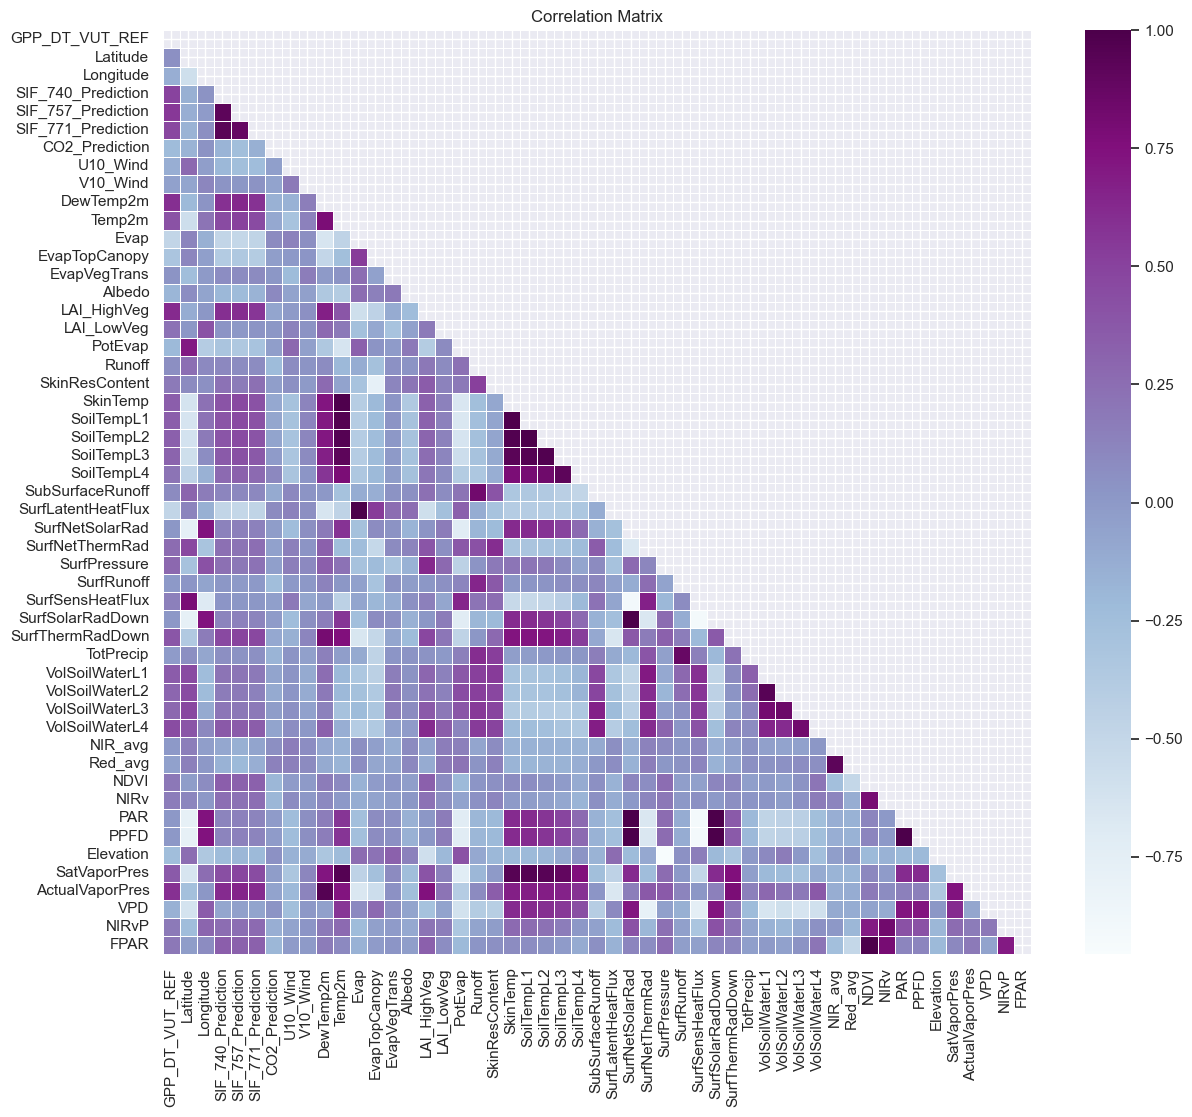

In [69]:
plt.figure(figsize=(14, 12))

sns.set()
corr_matrix = flux_val_corr.corr()
# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, xticklabels=True, yticklabels=True, linewidth=0.5, cmap='BuPu')
plt.title('Correlation Matrix')

Target - feature relationships

Text(0.5, 1.0, 'Individual Feature Correlations with GPP')

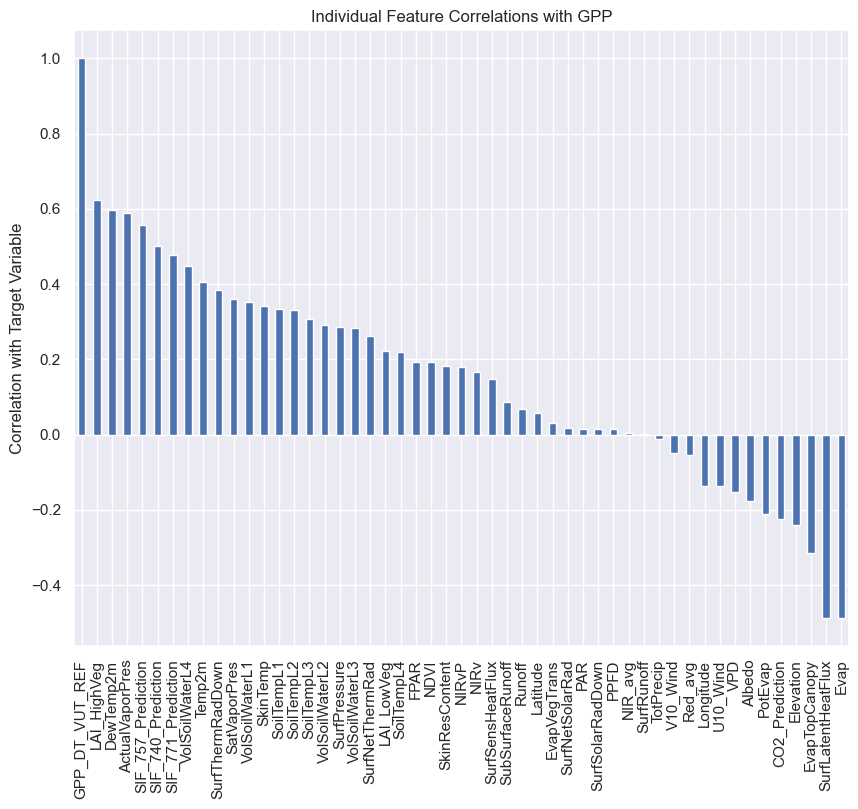

In [71]:
plt.figure(figsize=(10, 8))

corr_matrix['GPP_DT_VUT_REF'].sort_values(ascending = False).plot(kind='bar')

plt.ylabel('Correlation with Target Variable')
plt.title('Individual Feature Correlations with GPP')

# Flux Site Land Cover Map

Adding PFT (planf functional type info for all sites)

In [37]:
flux_val.loc[flux_val['Site'] == 'DE_RUS', 'LandType'] = 'CRO'
flux_val.loc[flux_val['Site'] == 'AU_TTE', 'LandType'] = 'GRA'
flux_val.loc[flux_val['Site'] == 'GF_GUY', 'LandType'] = 'EBF'
flux_val.loc[flux_val['Site'] == 'US_TW3', 'LandType'] = 'CRO'
flux_val.loc[flux_val['Site'] == 'US_PFA', 'LandType'] = 'MF'
flux_val.loc[flux_val['Site'] == 'GH_ANK', 'LandType'] = 'EBF'
flux_val.loc[flux_val['Site'] == 'US_SRM', 'LandType'] = 'WSA'
flux_val.loc[flux_val['Site'] == 'CH_CHA', 'LandType'] = 'GRA'
flux_val.loc[flux_val['Site'] == 'IT_COL', 'LandType'] = 'DBF'
flux_val.loc[flux_val['Site'] == 'US_WCR', 'LandType'] = 'DBF'
flux_val.loc[flux_val['Site'] == 'AU_CPR', 'LandType'] = 'SAV'
flux_val.loc[flux_val['Site'] == 'US_WKG', 'LandType'] = 'GRA'
flux_val.loc[flux_val['Site'] == 'DE_SFN', 'LandType'] = 'WET'
flux_val.loc[flux_val['Site'] == 'US_WHS', 'LandType'] = 'OSH'
flux_val.loc[flux_val['Site'] == 'IT_NOE', 'LandType'] = 'CSH'

In [227]:
# Saving dataset
flux_val.to_excel('Starting Dataset.xlsx')

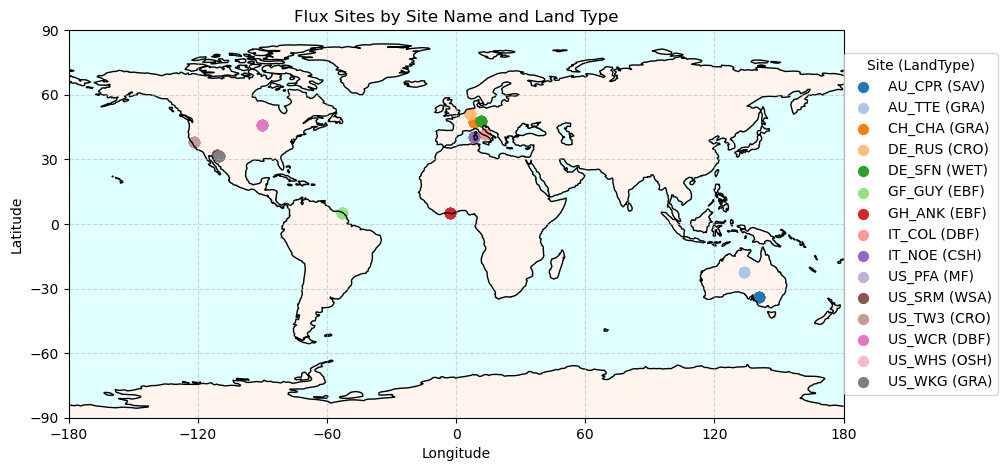

In [44]:
# Order the sites alphabetically
flux_val_sites = flux_val.sort_values('Site')

flux_val_sites['Site_LandType'] = flux_val_sites['Site'] + " (" + flux_val_sites['LandType'] + ")"

# Define a color palette
palette = sns.color_palette('tab20', n_colors=len(flux_val_sites['Site'].unique()))
site_colors = dict(zip(flux_val_sites['Site_LandType'].unique(), palette))

# Create a color list for the scatter plot
flux_val_sites['Colour'] = flux_val_sites['Site_LandType'].map(site_colors)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()  # Optionally set a global view (adjust as needed)

# N=Earth feature additions
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, color='lightcyan')

for site_landtype in flux_val_sites['Site_LandType'].unique():
    subset = flux_val_sites[flux_val_sites['Site_LandType'] == site_landtype]
    ax.scatter(subset['Longitude'], subset['Latitude'], color=site_colors[site_landtype], s=50, transform=ccrs.PlateCarree(), label=site_landtype)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Site (LandType)', borderaxespad=0.)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Flux Sites by Site Name and Land Type')

ax.set_xticks(range(-180, 181, 60), crs=ccrs.PlateCarree())  
ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())    
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

Redoing parts of USA where sites are close geographically

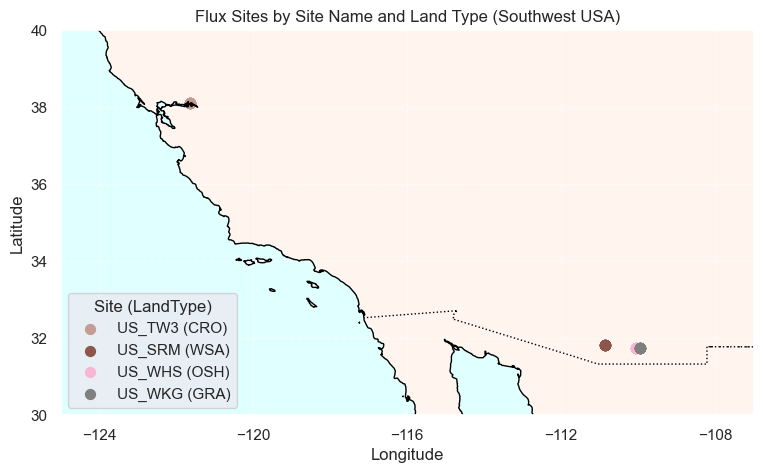

In [272]:
palette = sns.color_palette('tab20', n_colors=len(flux_val_sites['Site'].unique()))
site_colors = dict(zip(flux_val_sites['Site_LandType'].unique(), palette))

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

# Subsets plot 
ax.set_extent([-125, -107, 30, 40], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, color='lightcyan')
ax.add_feature(cfeature.BORDERS, linestyle = ':')

sites = ['US_TW3 (CRO)', 'US_SRM (WSA)', 'US_WHS (OSH)', 'US_WKG (GRA)']
for i in sites:
    subset = flux_val_sites[flux_val_sites['Site_LandType'] == i]
    if not subset.empty:
        ax.scatter(subset['Longitude'], subset['Latitude'], 
                   color=site_colors[i], 
                   s=50, transform=ccrs.PlateCarree(), 
                   label=i) 

plt.legend(loc='lower left', title='Site (LandType)')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Flux Sites by Site Name and Land Type (Southwest USA)')

# Subsets plot 
ax.set_xticks(range(-124, -107, 4), crs=ccrs.PlateCarree())  
ax.set_yticks(range(30, 41, 2), crs=ccrs.PlateCarree())    
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

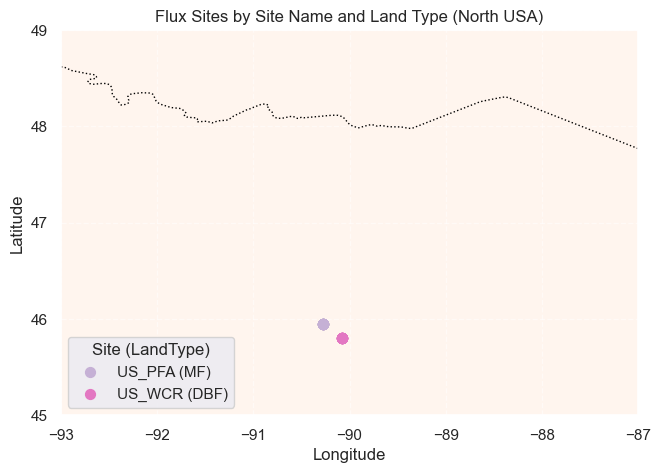

In [271]:
palette = sns.color_palette('tab20', n_colors=len(flux_val_sites['Site'].unique()))
site_colors = dict(zip(flux_val_sites['Site_LandType'].unique(), palette))

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()  

# Subsets plot 
ax.set_extent([-93, -87, 45, 49], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, color='lightcyan')
ax.add_feature(cfeature.BORDERS, linestyle = ':')

sites = ['US_PFA (MF)', 'US_WCR (DBF)']
for i in sites:
    subset = flux_val_sites[flux_val_sites['Site_LandType'] == i]
    if not subset.empty:
        ax.scatter(subset['Longitude'], subset['Latitude'], 
                   color=site_colors[i], 
                   s=50, transform=ccrs.PlateCarree(), 
                   label=i) 

plt.legend(loc='lower left', title='Site (LandType)')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Flux Sites by Site Name and Land Type (North USA)')

# Subsets plot 
ax.set_xticks(range(-93, -86, 1), crs=ccrs.PlateCarree()) 
ax.set_yticks(range(45, 50, 1), crs=ccrs.PlateCarree())  
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

GPP Analysis

Variable Testing - a couple feature - feature against GPP relationships

C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\465659025.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for color bar


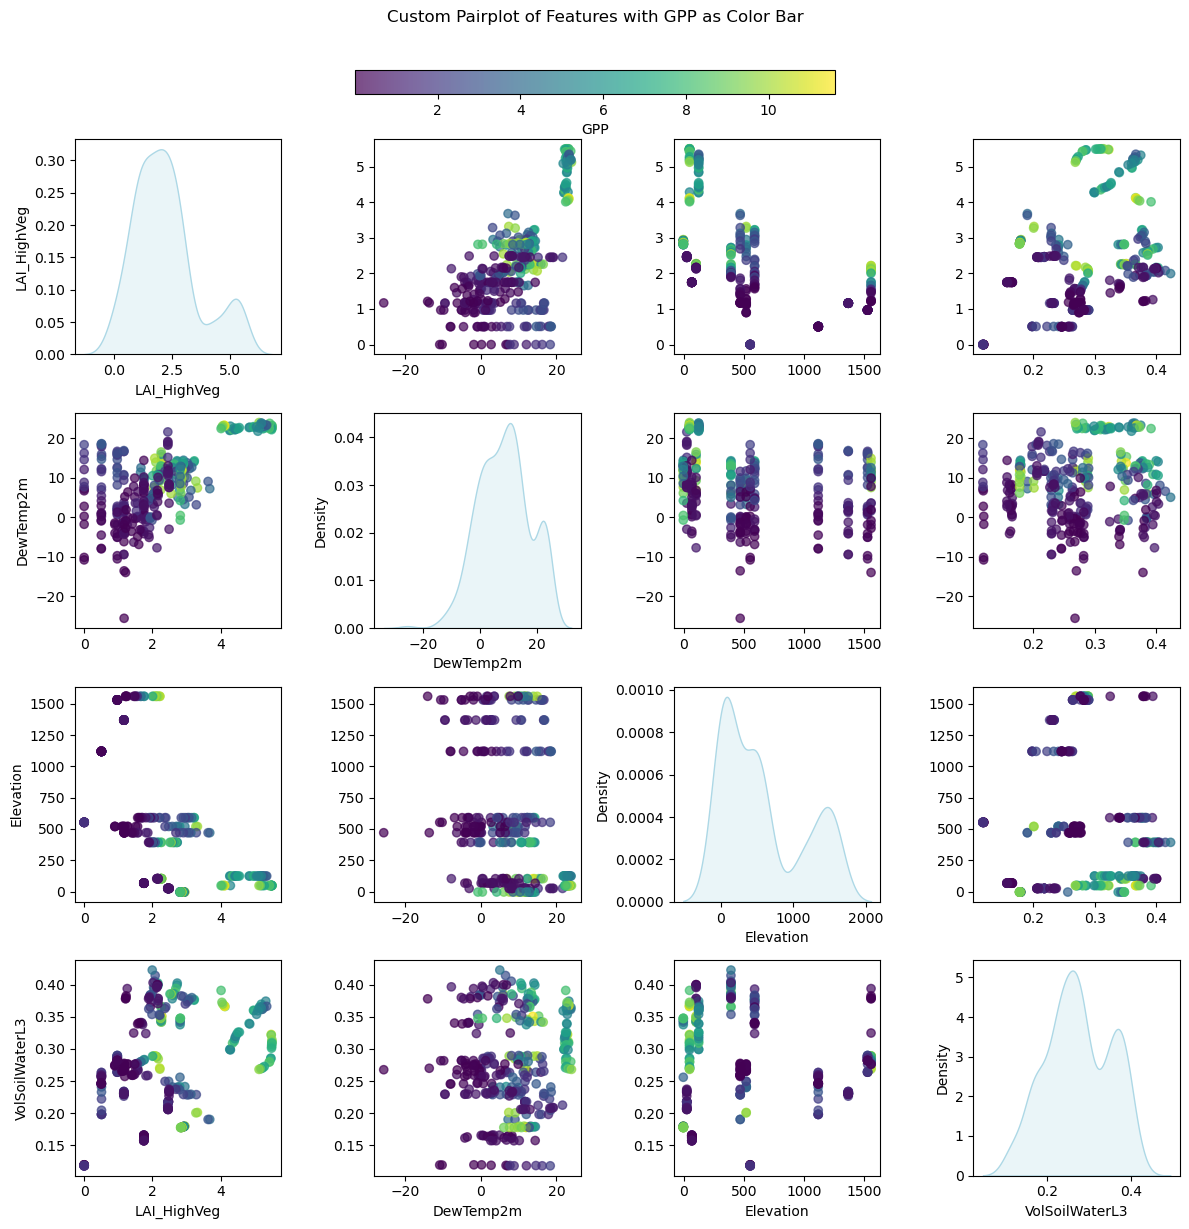

In [234]:
features = ['LAI_HighVeg','DewTemp2m','Elevation','VolSoilWaterL3']
gpp = flux_val['GPP_DT_VUT_REF']

fig, axes = plt.subplots(len(features), len(features), figsize=(12, 12))

for i, feature_i in enumerate(features):
    for j, feature_j in enumerate(features):
        ax = axes[i, j]
        if i == j:
            sns.kdeplot(data=flux_val, x=feature_i, ax=ax, fill=True, color='lightblue')
        else:
            scatter = ax.scatter(flux_val[feature_j], flux_val[feature_i], c=gpp, alpha=0.7)
        if i == len(features) - 1:
            ax.set_xlabel(feature_j)
        if j == 0:
            ax.set_ylabel(feature_i)

# Create an additional axis for the color bar at the top
cbar_ax = fig.add_axes([0.3, 0.95, 0.4, 0.02])  # left, bottom, width, height
fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label='GPP')

plt.suptitle('Custom Pairplot of Features with GPP as Color Bar', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for color bar
plt.show()

C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\122490171.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for color bar


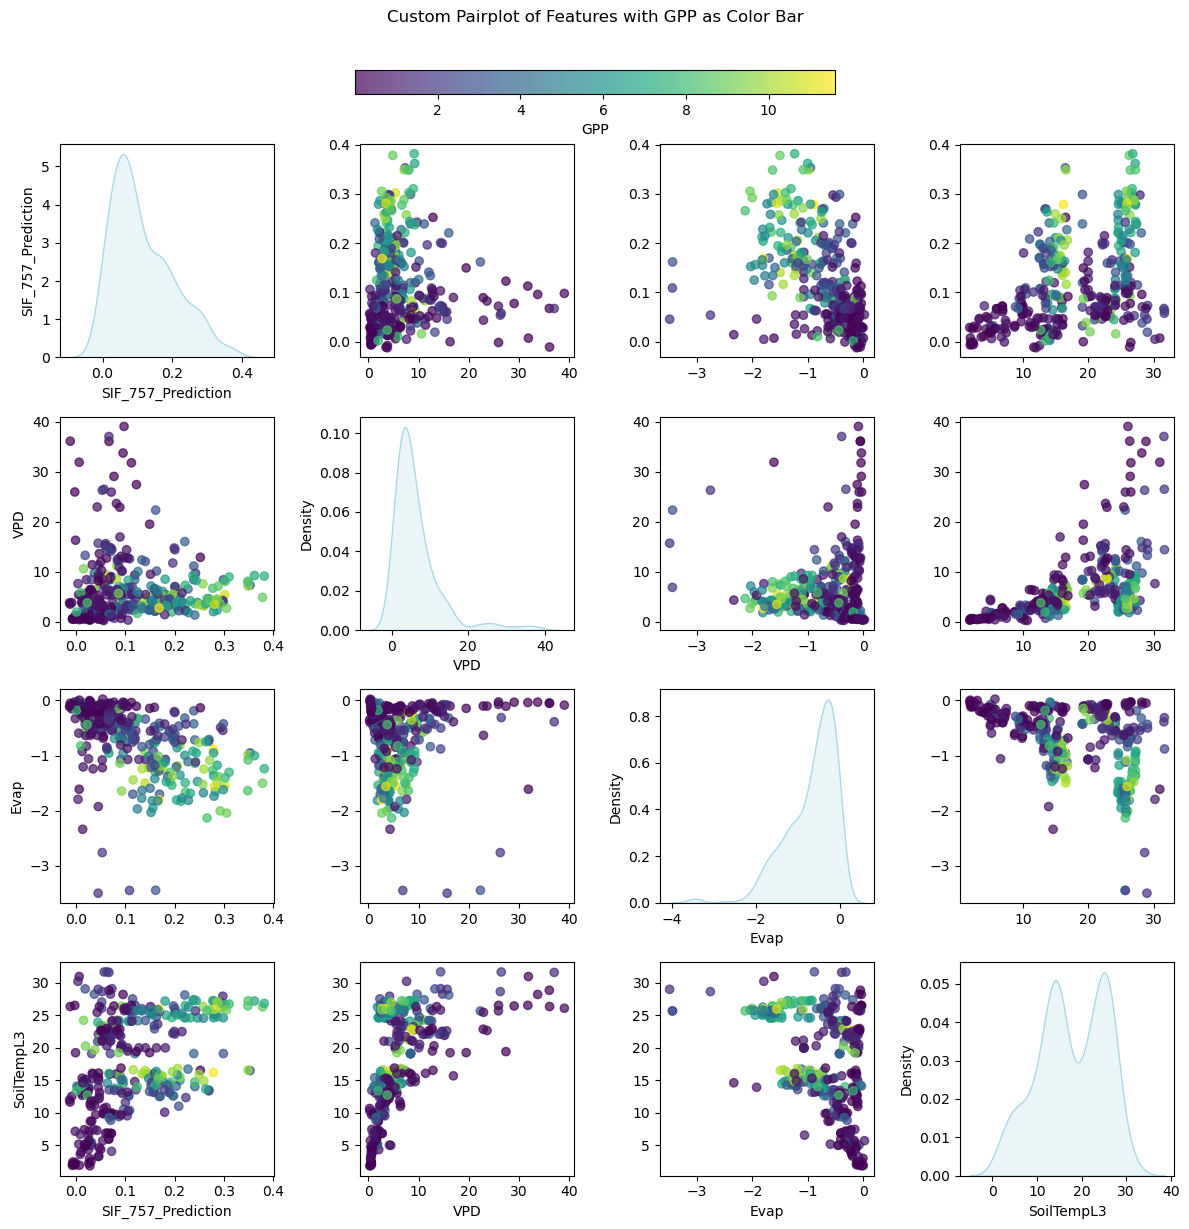

In [235]:
features = ['SIF_757_Prediction','VPD','Evap','SoilTempL3']
gpp = flux_val['GPP_DT_VUT_REF']

fig, axes = plt.subplots(len(features), len(features), figsize=(12, 12))

for i, feature_i in enumerate(features):
    for j, feature_j in enumerate(features):
        ax = axes[i, j]
        if i == j:
            sns.kdeplot(data=flux_val, x=feature_i, ax=ax, fill=True, color='lightblue')
        else:
            scatter = ax.scatter(flux_val[feature_j], flux_val[feature_i], c=gpp, alpha=0.7)
        if i == len(features) - 1:
            ax.set_xlabel(feature_j)
        if j == 0:
            ax.set_ylabel(feature_i)

# Create an additional axis for the color bar at the top
cbar_ax = fig.add_axes([0.3, 0.95, 0.4, 0.02])  # left, bottom, width, height
fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label='GPP')

plt.suptitle('Custom Pairplot of Features with GPP as Color Bar', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for color bar
plt.show()

C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\3170132120.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for color bar


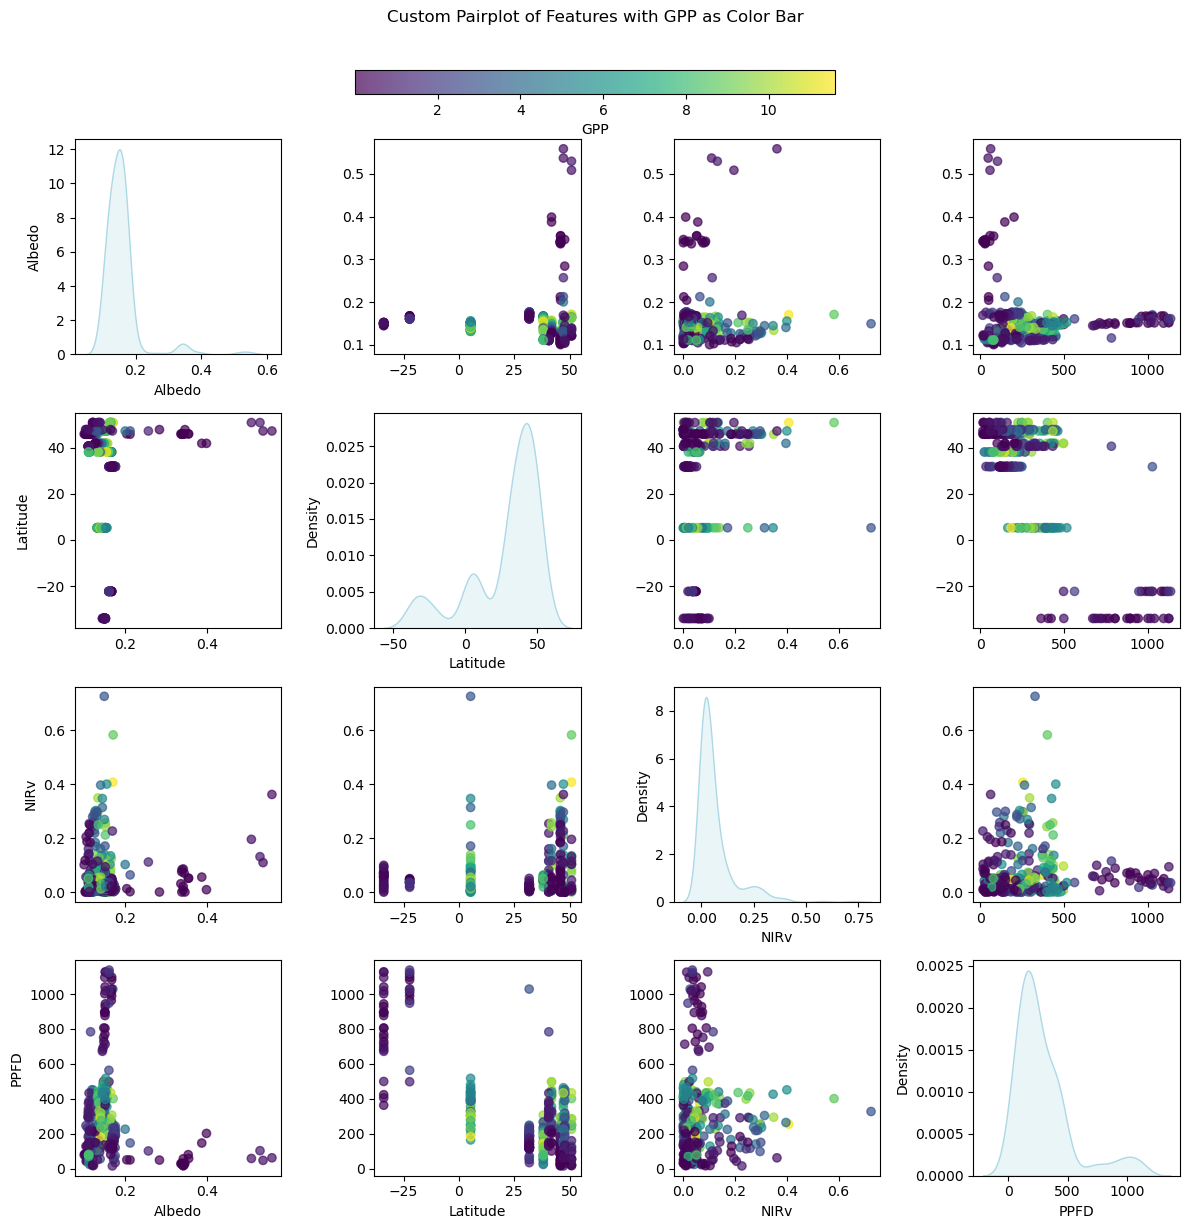

In [236]:
features = ['Albedo','Latitude','NIRv','PPFD']
gpp = flux_val['GPP_DT_VUT_REF']

fig, axes = plt.subplots(len(features), len(features), figsize=(12, 12))

for i, feature_i in enumerate(features):
    for j, feature_j in enumerate(features):
        ax = axes[i, j]
        if i == j:
            sns.kdeplot(data=flux_val, x=feature_i, ax=ax, fill=True, color='lightblue')
        else:
            scatter = ax.scatter(flux_val[feature_j], flux_val[feature_i], c=gpp, alpha=0.7)
        if i == len(features) - 1:
            ax.set_xlabel(feature_j)
        if j == 0:
            ax.set_ylabel(feature_i)

# Create an additional axis for the color bar at the top
cbar_ax = fig.add_axes([0.3, 0.95, 0.4, 0.02])  # left, bottom, width, height
fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label='GPP')

plt.suptitle('Custom Pairplot of Features with GPP as Color Bar', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for color bar
plt.show()

Final Dataset - Importing validation dataset for some EDA

In [2]:
GPP_final = pd.read_excel('Final_Flux_Data.xlsx')
del GPP_final['Unnamed: 0']

In [3]:
GPP_final.loc[GPP_final['Site'] == 'DE_RUS', 'LandType'] = 'CRO'
GPP_final.loc[GPP_final['Site'] == 'AU_TTE', 'LandType'] = 'GRA'
GPP_final.loc[GPP_final['Site'] == 'GF_GUY', 'LandType'] = 'EBF'
GPP_final.loc[GPP_final['Site'] == 'US_PFA', 'LandType'] = 'MF'
GPP_final.loc[GPP_final['Site'] == 'GH_ANK', 'LandType'] = 'EBF'
GPP_final.loc[GPP_final['Site'] == 'US_SRM', 'LandType'] = 'WSA'
GPP_final.loc[GPP_final['Site'] == 'CH_CHA', 'LandType'] = 'GRA'
GPP_final.loc[GPP_final['Site'] == 'IT_COL', 'LandType'] = 'DBF'
GPP_final.loc[GPP_final['Site'] == 'US_WCR', 'LandType'] = 'DBF'
GPP_final.loc[GPP_final['Site'] == 'AU_CPR', 'LandType'] = 'SAV'
GPP_final.loc[GPP_final['Site'] == 'US_WKG', 'LandType'] = 'GRA'
GPP_final.loc[GPP_final['Site'] == 'IT_NOE', 'LandType'] = 'CSH'
GPP_final.loc[GPP_final['Site'] == 'FR_PUE', 'LandType'] = 'EBF'
GPP_final.loc[GPP_final['Site'] == 'NL_LOO', 'LandType'] = 'ENF'
GPP_final.loc[GPP_final['Site'] == 'US_NR1', 'LandType'] = 'ENF'
GPP_final.loc[GPP_final['Site'] == 'AU_GIN', 'LandType'] = 'WSA'

In [4]:
site_info = {
    'DE_RUS': {'Latitude': 50.8659, 'Longitude': 6.4471},
    'GF_GUY': {'Latitude': 5.2788, 'Longitude': -52.9249},
    'US_PFA': {'Latitude': 45.9459, 'Longitude': -90.2723},
    'GH_ANK': {'Latitude': 5.2685, 'Longitude': -2.6942},
    'US_SRM': {'Latitude': 31.8214, 'Longitude': -110.8660},
    'CH_CHA': {'Latitude': 47.2102, 'Longitude': 8.4104},
    'IT_COL': {'Latitude': 41.8494, 'Longitude': 13.5881},
    'US_WCR': {'Latitude': 45.8059, 'Longitude': -90.0799},
    'AU_CPR': {'Latitude': -34.0021, 'Longitude': 140.5891},
    'US_WKG': {'Latitude': 31.7365, 'Longitude': -109.9420},
    'IT_NOE': {'Latitude': 40.6062, 'Longitude': 8.1517},
    'FR_PUE': {'Latitude': 43.7413, 'Longitude': 3.5957},
    'NL_LOO': {'Latitude': 52.1666, 'Longitude': 5.7436},
    'US_NR1': {'Latitude': 40.0329, 'Longitude': -105.5464},
    'AU_GIN': {'Latitude': -31.3764, 'Longitude': 151.7138}
}

In [5]:
for site, info in site_info.items():
    GPP_final.loc[GPP_final['Site'] == site, 'Latitude'] = info['Latitude']
    GPP_final.loc[GPP_final['Site'] == site, 'Longitude'] = info['Longitude']

In [ ]:
# Plotting visualising of removed and added sites for final modelling

In [133]:
removed_sites = [
    {'Site': 'AU_TTE', 'Latitude': -22.2870, 'Longitude': 133.6400, 'LandType': 'GRA'},
    {'Site': 'DE_SFN', 'Latitude': 47.8064, 'Longitude': 11.3275, 'LandType': 'WET'},
    {'Site': 'US_WHS', 'Latitude': 31.7438, 'Longitude': -110.0520, 'LandType': 'OSH'},
    {'Site': 'US_TW3', 'Latitude': 38.1152, 'Longitude': -121.6470, 'LandType': 'CRO'}
]

new_sites = [
    {'Site': 'NL_LOO', 'Latitude': 52.1666, 'Longitude': 5.7436, 'LandType': 'ENF'},
    {'Site': 'FR_PUE', 'Latitude': 43.7413, 'Longitude': 3.5957, 'LandType': 'EBF'},
    {'Site': 'AU_GIN', 'Latitude': -31.3764, 'Longitude': 151.7138, 'LandType': 'WSA'},
    {'Site': 'US_NR1', 'Latitude': 40.0329, 'Longitude': -105.5464, 'LandType': 'ENF'}
]

In [136]:
all_sites = pd.DataFrame(removed_sites + new_sites)

# Indicate removed or new
all_sites['Status'] = ['Removed'] * len(removed_sites) + ['New'] * len(new_sites)
all_sites['Site_LandType'] = all_sites['Site'] + " (" + all_sites['LandType'] + ")"
all_sites

Site  Latitude  Longitude LandType   Status Site_LandType
0  AU_TTE  -22.2870   133.6400      GRA  Removed  AU_TTE (GRA)
1  DE_SFN   47.8064    11.3275      WET  Removed  DE_SFN (WET)
2  US_WHS   31.7438  -110.0520      OSH  Removed  US_WHS (OSH)
3  US_TW3   38.1152  -121.6470      CRO  Removed  US_TW3 (CRO)
4  NL_LOO   52.1666     5.7436      ENF      New  NL_LOO (ENF)
5  FR_PUE   43.7413     3.5957      EBF      New  FR_PUE (EBF)
6  AU_GIN  -31.3764   151.7138      WSA      New  AU_GIN (WSA)
7  US_NR1   40.0329  -105.5464      ENF      New  US_NR1 (ENF)

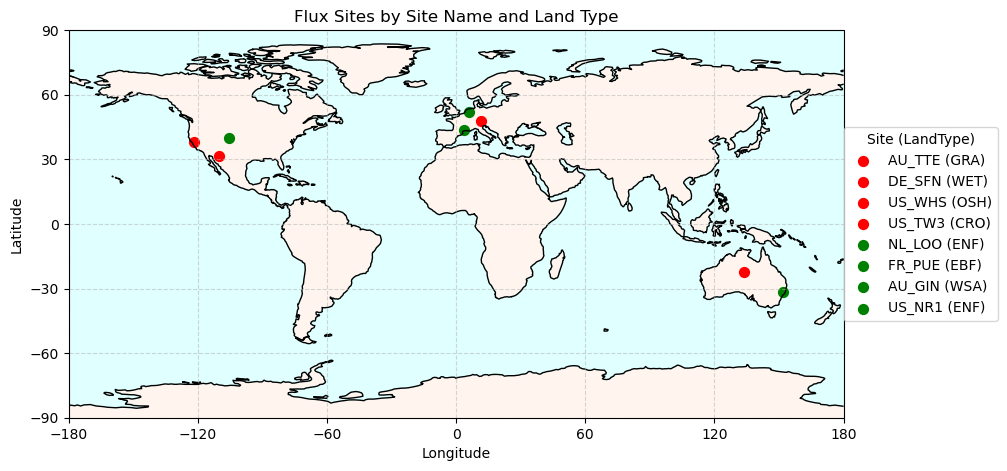

In [137]:
site_colors = {'Removed': 'red', 'New': 'green'}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, color='lightcyan')

# Plot the sites with appropriate colors and prepare legend labels
for index, row in all_sites.iterrows():
    site_label = f"{row['Site_LandType']}"
    ax.scatter(row['Longitude'], row['Latitude'], color=site_colors[row['Status']], s=50, transform=ccrs.PlateCarree(), label=site_label)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) 
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), title='Site (LandType)', borderaxespad=0.)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Flux Sites by Site Name and Land Type')

ax.set_xticks(range(-180, 181, 60), crs=ccrs.PlateCarree()) 
ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())   
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

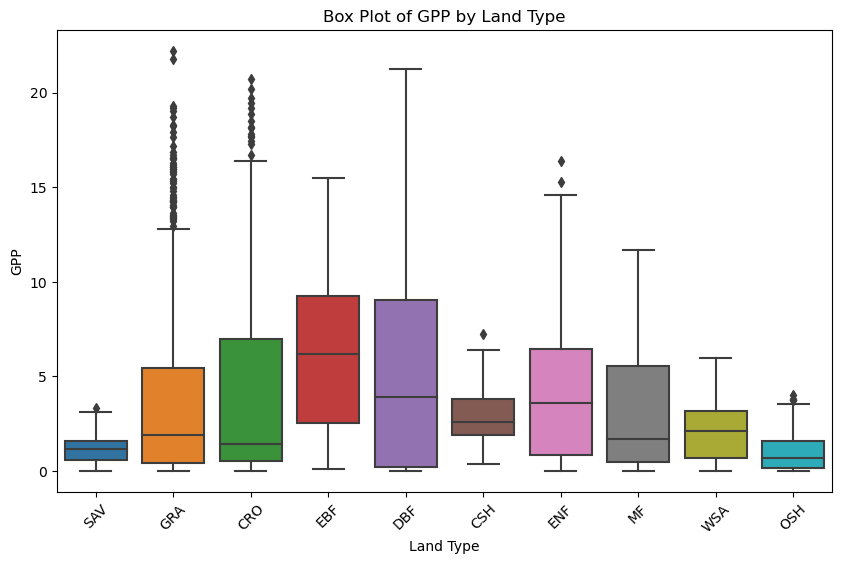

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='LandType', y='GPP_DT_VUT_REF', data=GPP_final)
plt.title('Box Plot of GPP by Land Type')
plt.xlabel('Land Type')
plt.ylabel('GPP')
plt.xticks(rotation=45)
plt.show()

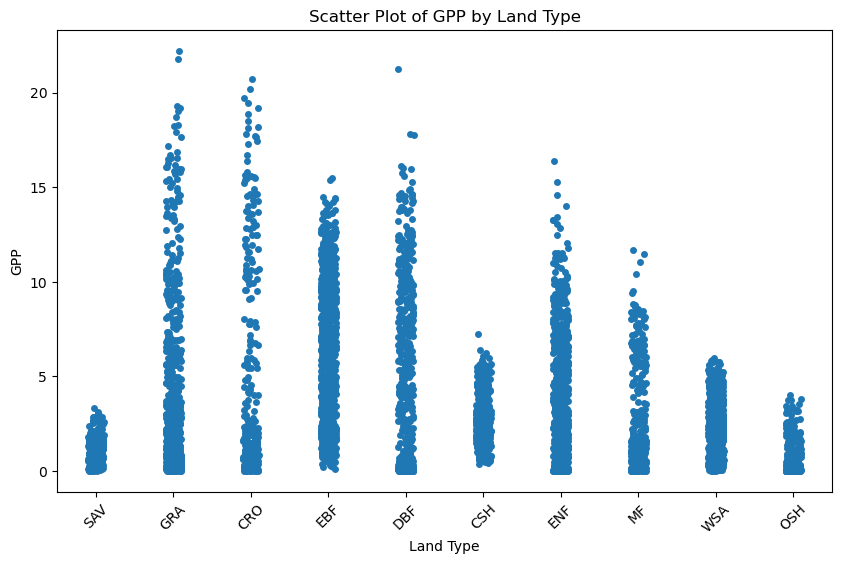

In [8]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='LandType', y='GPP_DT_VUT_REF', data=GPP_final, jitter=True, dodge=True)
plt.title('Scatter Plot of GPP by Land Type')
plt.xlabel('Land Type')
plt.ylabel('GPP')
plt.xticks(rotation=45)
plt.show()

In [25]:
GPP_final['Date'] = pd.to_datetime(GPP_final['Date'])
GPP_final['Year'] = GPP_final['Date'].dt.year
GPP_final['Month'] = GPP_final['Date'].dt.month

#GPP_AUCPR = GPP_final[GPP_final['Site'] == 'AU_CPR']

#GPP_AUCPR['Year'] = GPP_AUCPR['Date'].dt.year
#GPP_AUCPR['Month'] = GPP_AUCPR['Date'].dt.month

monthly_avg = GPP_final.groupby(['Year', 'Month'])['GPP_DT_VUT_REF'].mean().reset_index()

C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\391301772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPP_AUCPR['Year'] = GPP_AUCPR['Date'].dt.year
C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\391301772.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPP_AUCPR['Month'] = GPP_AUCPR['Date'].dt.month


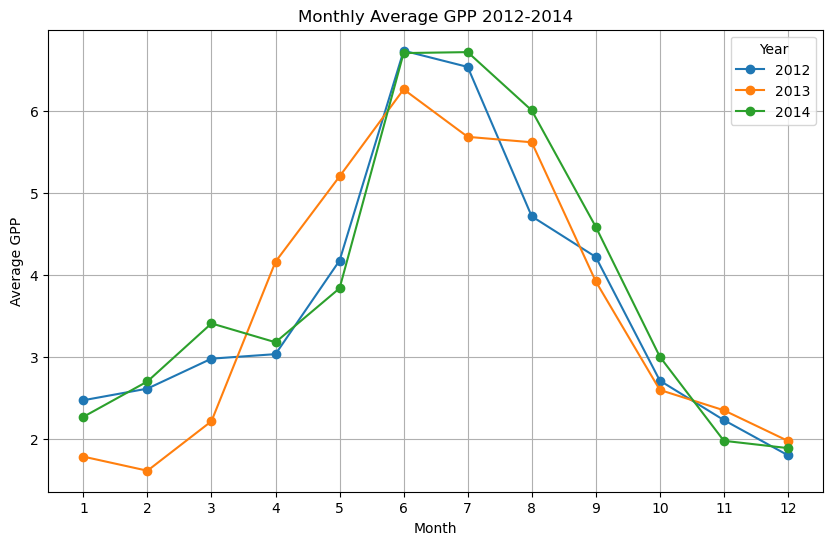

In [29]:
plt.figure(figsize=(10, 6))

# Plot for each year
for year in [2012, 2013, 2014]:
    year_data = monthly_avg[monthly_avg['Year'] == year]
    plt.plot(year_data['Month'], year_data['GPP_DT_VUT_REF'], marker='o', label=str(year))

plt.xlabel('Month')
plt.ylabel('Average GPP')
plt.title('Monthly Average GPP 2012-2014')
plt.xticks(range(1, 13))  
plt.legend(title='Year')
plt.grid(True)

plt.show()

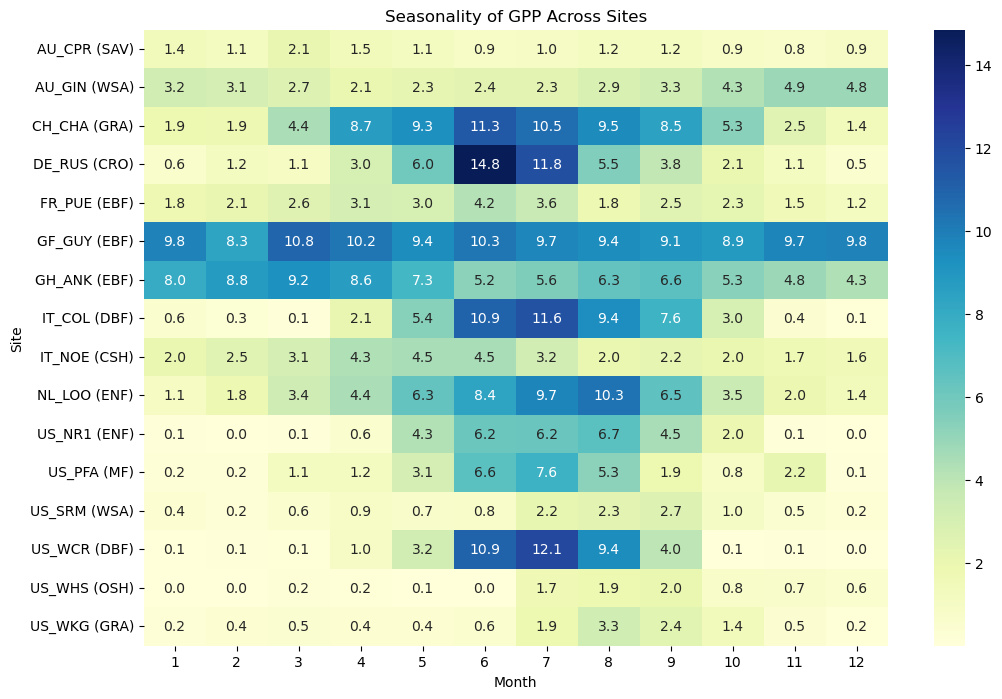

In [35]:
# Seasonality heatmap

GPP_sites['Site_LandType'] = GPP_sites['Site'] + " (" + GPP_sites['LandType'] + ")"

heatmap_data = GPP_final.pivot_table(index='Site_LandType', columns='Month', values='GPP_DT_VUT_REF', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Seasonality of GPP Across Sites')
plt.xlabel('Month')
plt.ylabel('Site')
plt.show()

# Variable choices

Using various feature selection techniques to reduce feature space from 50 - prior to model trials

In [3]:
flux_val = pd.read_excel('Starting Dataset.xlsx')
del flux_val['Unnamed: 0']

In [42]:
flux_val.columns

Index(['Date', 'Site', 'GPP_DT_VUT_REF', 'Latitude', 'Longitude',
       'SIF_740_Prediction', 'SIF_757_Prediction', 'SIF_771_Prediction',
       'CO2_Prediction', 'U10_Wind', 'V10_Wind', 'DewTemp2m', 'Temp2m', 'Evap',
       'EvapTopCanopy', 'EvapVegTrans', 'Albedo', 'LAI_HighVeg', 'LAI_LowVeg',
       'PotEvap', 'Runoff', 'SkinResContent', 'SkinTemp', 'SoilTempL1',
       'SoilTempL2', 'SoilTempL3', 'SoilTempL4', 'SubSurfaceRunoff',
       'SurfLatentHeatFlux', 'SurfNetSolarRad', 'SurfNetThermRad',
       'SurfPressure', 'SurfRunoff', 'SurfSensHeatFlux', 'SurfSolarRadDown',
       'SurfThermRadDown', 'TotPrecip', 'VolSoilWaterL1', 'VolSoilWaterL2',
       'VolSoilWaterL3', 'VolSoilWaterL4', 'NIR_avg', 'Red_avg', 'NDVI',
       'NIRv', 'PAR', 'PPFD', 'Elevation', 'SatVaporPres', 'ActualVaporPres',
       'VPD', 'NIRvP', 'FPAR', 'LandType'],
      dtype='object')

In [3]:
X = flux_val.drop(columns=['Date','GPP_DT_VUT_REF', 'Site','LandType'])
y = flux_val['GPP_DT_VUT_REF']

Mutual information

In [48]:
mi = mir(X, y)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI': mi
})

# Sort by MI 
mi_df = mi_df.sort_values(by='MI', ascending=False)
mi_df

Feature        MI
14         LAI_HighVeg  0.759478
37      VolSoilWaterL4  0.747459
36      VolSoilWaterL3  0.707531
15          LAI_LowVeg  0.704219
23          SoilTempL4  0.613143
13              Albedo  0.579245
0             Latitude  0.557519
22          SoilTempL3  0.517755
44           Elevation  0.490177
1            Longitude  0.489221
35      VolSoilWaterL2  0.467995
24    SubSurfaceRunoff  0.434278
8            DewTemp2m  0.429663
46     ActualVaporPres  0.428543
21          SoilTempL2  0.425862
42                 PAR  0.422052
31    SurfSolarRadDown  0.421901
43                PPFD  0.421332
26     SurfNetSolarRad  0.416414
45        SatVaporPres  0.385283
17              Runoff  0.383545
28        SurfPressure  0.374812
9               Temp2m  0.366375
25  SurfLatentHeatFlux  0.365637
10                Evap  0.354623
20          SoilTempL1  0.341541
34      VolSoilWaterL1  0.340572
19            SkinTemp  0.324767
30    SurfSensHeatFlux  0.321092
3   SIF_757_Prediction  0.293415
16             PotEvap  0.252374
4   SIF_771_Prediction  0.244409
2   SIF_740_Prediction  0.233436
47                 VPD  0.224473
32    SurfThermRadDown  0.174079
49                FPAR  0.171655
40                NDVI  0.170768
27     SurfNetThermRad  0.155396
41                NIRv  0.149063
12        EvapVegTrans  0.141354
11       EvapTopCanopy  0.113670
7             V10_Wind  0.111438
39             Red_avg  0.102131
6             U10_Wind  0.094669
38             NIR_avg  0.088317
18      SkinResContent  0.073608
5       CO2_Prediction  0.057767
33           TotPrecip  0.047181
48               NIRvP  0.037405
29          SurfRunoff  0.019338

Random Forest Basic Model Feature Importances

In [50]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

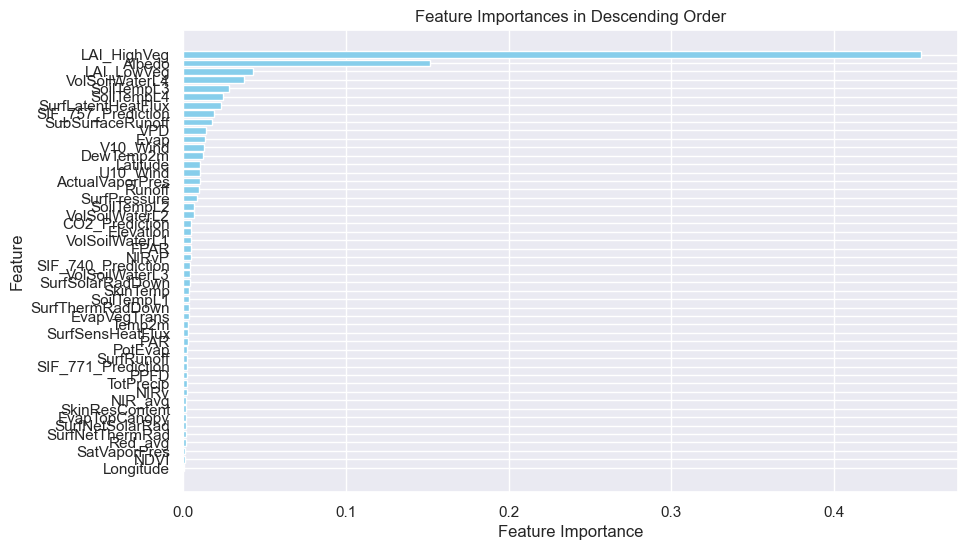

In [57]:
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sortby the importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Descending Order')
plt.show()

LASSO L1 Regularisation

In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [68]:
# LassoCV will automatically perform cross-validation and find the best alpha
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=31)
lasso_cv.fit(X_scaled, y)

C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3602468554589677, tolerance: 0.2647690654838568
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0782983845363106, tolerance: 0.2647690654838568
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.685927921378493, tolerance: 0.2647690654838568
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6875386170934235, tolerance: 0.31052415686457513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9880223926568306, tolerance: 0.31052415686457513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.226292578927541, tolerance: 0.31052415686457513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coor

C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.74329139561638, tolerance: 0.2980801432528594
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.5600095494421, tolerance: 0.2980801432528594
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.87598130722938, tolerance: 0.2980801432528594
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joearthur\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

LassoCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       1.38488637e+02, 1.66810054e+02, 2.00923300e+02, 2.42012826e+02,
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=5, random_state=0)

In [69]:
best_alpha = lasso_cv.alpha_
print(f"Best alpha value: {best_alpha}")

Best alpha value: 0.026560877829466867


In [70]:
#Adusting to search around original best alpha

narrow_alphas = np.logspace(np.log10(0.01), np.log10(0.1), 100)

# Refit LassoCV with the new alpha range
lasso_cv_refined = LassoCV(alphas=narrow_alphas, cv=5, random_state=31)
lasso_cv_refined.fit(X_scaled, y)

# Get the new best alpha
best_alpha_refined = lasso_cv_refined.alpha_
print(f"Refined best alpha value: {best_alpha_refined}")

Refined best alpha value: 0.024770763559917114


In [72]:
#Lasso

lasso = Lasso(alpha=best_alpha_refined) 
lasso.fit(X_scaled, y)

Lasso(alpha=0.024770763559917114)

In [73]:
# Printint all variable with coefficients not reduced to 0

coefficients = lasso.coef_
lasso_features = X.columns[coefficients != 0].tolist()
lasso_features

['Longitude',
 'SIF_757_Prediction',
 'SIF_771_Prediction',
 'CO2_Prediction',
 'U10_Wind',
 'V10_Wind',
 'Temp2m',
 'Evap',
 'EvapTopCanopy',
 'EvapVegTrans',
 'Albedo',
 'LAI_HighVeg',
 'LAI_LowVeg',
 'PotEvap',
 'Runoff',
 'SkinResContent',
 'SoilTempL2',
 'SoilTempL3',
 'SoilTempL4',
 'SubSurfaceRunoff',
 'SurfNetThermRad',
 'SurfPressure',
 'SurfSensHeatFlux',
 'SurfThermRadDown',
 'TotPrecip',
 'VolSoilWaterL1',
 'VolSoilWaterL3',
 'VolSoilWaterL4',
 'NIR_avg',
 'NDVI',
 'SatVaporPres',
 'ActualVaporPres',
 'NIRvP',
 'FPAR']

In [77]:
lasso_df = pd.DataFrame({
    'Feature': X.columns,
    'Coeffs': coefficients
})
lasso_df = lasso_df.sort_values('Coeffs')
lasso_df[lasso_df['Coeffs'] != 0]

Feature    Coeffs
1            Longitude -2.019770
23          SoilTempL4 -1.372689
36      VolSoilWaterL3 -0.745598
45        SatVaporPres -0.706053
10                Evap -0.659199
30    SurfSensHeatFlux -0.538348
32    SurfThermRadDown -0.445383
27     SurfNetThermRad -0.312589
46     ActualVaporPres -0.261542
40                NDVI -0.261257
7             V10_Wind -0.253370
5       CO2_Prediction -0.243143
33           TotPrecip -0.236128
11       EvapTopCanopy -0.187828
18      SkinResContent -0.169138
6             U10_Wind -0.149840
24    SubSurfaceRunoff -0.136336
49                FPAR -0.082078
17              Runoff -0.051152
16             PotEvap  0.018096
38             NIR_avg  0.024882
13              Albedo  0.063626
4   SIF_771_Prediction  0.142939
48               NIRvP  0.179776
3   SIF_757_Prediction  0.210253
14         LAI_HighVeg  0.328474
21          SoilTempL2  0.660729
15          LAI_LowVeg  0.713122
12        EvapVegTrans  0.729596
28        SurfPressure  0.790374
22          SoilTempL3  0.836568
34      VolSoilWaterL1  0.882134
9               Temp2m  1.396197
37      VolSoilWaterL4  1.472845

Recursive Feature Elimination feature selection per model type

RF

In [153]:
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)
rfe.fit(X, y)

RFE(estimator=RandomForestRegressor(), n_features_to_select=10)

In [154]:
selected_features = X.columns[rfe.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['DewTemp2m', 'Evap', 'Albedo', 'LAI_HighVeg', 'LAI_LowVeg',
       'SoilTempL3', 'SoilTempL4', 'SubSurfaceRunoff', 'VolSoilWaterL4',
       'VPD'],
      dtype='object')


Manual store of all iterations

In [ ]:
# 1 Feature: LAI_HighVeg
# 2 Feature: Albedo, LAI_HighVeg
# 3 Feature: Albedo, LAI_HighVeg, LAI_LowVeg
# 4 Feature: Evap, Albedo, LAI_HighVeg, LAI_LowVeg
# 5 Feature: Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, VolSoilWaterL4
# 6 Feature: DewTemp2m, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, VolSoilWaterL4
# 7 Feature: DewTemp2m, Evap, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, VolSoilWaterL4
# 8 Feature: DewTemp2m, Evap, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, SoilTempL4, VolSoilWaterL4
# 9 Feature: DewTemp2m, Evap, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, SoilTempL4, SubSurfaceRunoff, VolSoilWaterL4
# 10 Feature: DewTemp2m, Evap, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, SoilTempL4, SubSurfaceRunoff, VolSoilWaterL4, VPD

XGBoost

In [32]:
rfe = RFE(estimator=xgb.XGBRegressor(), n_features_to_select=9)
rfe.fit(X, y)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=None,
                           num_parallel_tree=None, random_state=None, ...),
    n_features_to_select=9)

In [33]:
selected_features = X.columns[rfe.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['Latitude', 'Albedo', 'LAI_HighVeg', 'LAI_LowVeg', 'SoilTempL3',
       'SoilTempL4', 'SubSurfaceRunoff', 'SurfNetSolarRad', 'VPD'],
      dtype='object')


In [ ]:
# 1 Feature: LAI_HighVeg
# 2 Feature: Albedo, LAI_HighVeg
# 3 Feature: Albedo, LAI_HighVeg, SoilTempL3
# 4 Feature: Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3
# 5 Feature: Latitude, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3
# 6 Feature: Latitude, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, SoilTempL4
# 7 Feature: Latitude, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, SoilTempL4, VPD
# 8 Feature: Latitude, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, SoilTempL4, SubSurfaceRunoff, VPD
# 9 Feature: Latitude, Albedo, LAI_HighVeg, LAI_LowVeg, SoilTempL3, SoilTempL4, SubSurfaceRunoff, SurfNetSolarRad, VPD
# 10 Feature: Latitude, Albedo, LAI_HighVeg, LAI_LowVeg, Runoff, SoilTempL3, SoilTempL4, SubSurfaceRunoff, SurfNetSolarRad, VPD

LGBM

In [51]:
rfe = RFE(estimator=lgb.LGBMRegressor(verbose=-1), n_features_to_select=10)
rfe.fit(X, y)

RFE(estimator=LGBMRegressor(verbose=-1), n_features_to_select=10)

In [52]:
selected_features = X.columns[rfe.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['SIF_740_Prediction', 'U10_Wind', 'EvapVegTrans', 'Albedo',
       'LAI_HighVeg', 'LAI_LowVeg', 'SurfNetSolarRad', 'VolSoilWaterL1',
       'VolSoilWaterL3', 'NDVI'],
      dtype='object')


In [ ]:
# 1 Feature: LAI_LowVeg
# 2 Feature: LAI_HighVeg, LAI_LowVeg
# 3 Feature: EvapVegTrans, LAI_HighVeg, LAI_LowVeg
# 4 Feature: EvapVegTrans, LAI_HighVeg, LAI_LowVeg, VolSoilWaterL3
# 5 Feature: SIF_740_Prediction, EvapVegTrans, LAI_HighVeg, LAI_LowVeg, VolSoilWaterL3
# 6 Feature: SIF_740_Prediction, U10_Wind, EvapVegTrans, LAI_HighVeg, LAI_LowVeg, VolSoilWaterL3
# 7 Feature: SIF_740_Prediction, U10_Wind, EvapVegTrans, LAI_HighVeg, LAI_LowVeg, SurfNetSolarRad, VolSoilWaterL3
# 8 Feature: SIF_740_Prediction, U10_Wind, EvapVegTrans, LAI_HighVeg, LAI_LowVeg, SurfNetSolarRad, VolSoilWaterL3, NDVI
# 9 Feature: SIF_740_Prediction, U10_Wind, EvapVegTrans, Albedo, LAI_HighVeg, LAI_LowVeg, SurfNetSolarRad, VolSoilWaterL3, NDVI
# 10 Feature: SIF_740_Prediction, U10_Wind, EvapVegTrans, Albedo, LAI_HighVeg, LAI_LowVeg, SurfNetSolarRad, VolSoilWaterL1, VolSoilWaterL3, NDVI

P model feature importances

In [9]:
x_p = flux_val[['Temp2m','SurfPressure','VPD','CO2_Prediction','PPFD','NIRv']]
y = flux_val['GPP_DT_VUT_REF']

In [36]:
x_train,x_test,y_train,y_test = train_test_split(x_p,y,test_size=0.2,random_state=31)

In [101]:
params = {
    'n_estimators': [25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80],
    'min_samples_split': list(np.arange(2,20,1)),
    'min_samples_leaf': list(np.arange(1,10,1)),
    'max_features': ['sqrt','log2'] + list(np.arange(1,7,1)), 
    'bootstrap': [True,False]
}

In [103]:
rf=RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=params,
                                   cv=10, verbose=2, n_jobs=-1, n_iter=100,
                                   scoring='neg_root_mean_squared_error',
                                   error_score='raise')

start_time = time.time()
random_search.fit(x_train,y_train)
end_time = time.time()
print('time taken: ' + str(round(end_time - start_time,2)))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
time taken: 128.78


In [104]:
best_params = random_search.best_params_
best_params

{'n_estimators': 275,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [106]:
best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap'],
    random_state=31
)

best_rf.fit(x_train, y_train)

y_pred = best_rf.predict(x_test)

In [110]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mean_bias = np.mean(y_pred - y_test)

# Print the evaluation metrics
print(f'RMSE: {round(rmse,4)}')
print(f'MAE: {round(mae,4)}')
print(f'R²: {round(r2,4)}')
print(f'Mean Bias: {round(mean_bias,4)}')

RMSE: 1.9145
MAE: 1.3709
R²: 0.6759
Mean Bias: 0.0935


Feature Importances:
          Feature  Importance
0          Temp2m    0.222580
4            PPFD    0.219568
1    SurfPressure    0.210600
2             VPD    0.186188
5            NIRv    0.083340
3  CO2_Prediction    0.077725


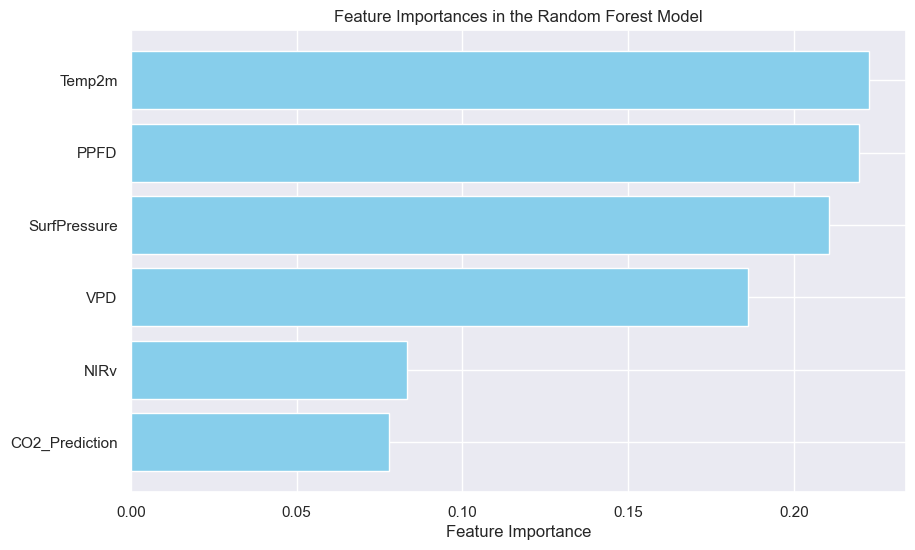

In [113]:
importances = best_rf.feature_importances_

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the Random Forest Model')
plt.show()

Random Forest Practice Model on all features

In [223]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=31)

In [226]:
len(X.columns)

50

In [228]:
params = {
    'n_estimators': [25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80],
    'min_samples_split': list(np.arange(2,20,1)),
    'min_samples_leaf': list(np.arange(1,10,1)),
    'max_features': ['sqrt','log2'] + list(np.arange(1,51,1)), 
    'bootstrap': [True,False]
}

In [229]:
rf=RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=params,
                                   cv=10, verbose=2, n_jobs=-1, n_iter=100,
                                   scoring='neg_root_mean_squared_error',
                                   error_score='raise')

start_time = time.time()
random_search.fit(x_train,y_train)
end_time = time.time()
print('time taken: ' + str(round(end_time - start_time,2)))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
time taken: 514.63


In [230]:
best_params = random_search.best_params_
best_params

{'n_estimators': 475,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 10,
 'max_depth': 80,
 'bootstrap': False}

In [231]:
best_rf = RandomForestRegressor(
    n_estimators = best_params['n_estimators'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    bootstrap = best_params['bootstrap'],
    random_state = 31
)

# Train the model
best_rf.fit(x_train, y_train)

# Predict on the test set
y_pred = best_rf.predict(x_test)

In [232]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate mean bias
mean_bias = np.mean(y_pred - y_test)

# Print the evaluation metrics
print(f'RMSE: {round(rmse,4)}')
print(f'MAE: {round(mae,4)}')
print(f'R²: {round(r2,4)}')
print(f'Mean Bias: {round(mean_bias,4)}')

RMSE: 1.251
MAE: 0.8469
R²: 0.8616
Mean Bias: 0.085


In [199]:
#Best so far

b_vars = X
b_params = best_params
b_rmse = round(rmse,4)
b_mae = round(mae,4)
b_r2 = round(r2,4)
b_bias = round(mean_bias,4)

Feature Importances:
               Feature  Importance
14         LAI_HighVeg    0.150165
8            DewTemp2m    0.063731
46     ActualVaporPres    0.058255
37      VolSoilWaterL4    0.057011
25  SurfLatentHeatFlux    0.054143
10                Evap    0.053403
24    SubSurfaceRunoff    0.042084
2   SIF_740_Prediction    0.035758
44           Elevation    0.035329
1            Longitude    0.030527
3   SIF_757_Prediction    0.030245
17              Runoff    0.029872
15          LAI_LowVeg    0.029022
4   SIF_771_Prediction    0.027989
22          SoilTempL3    0.025973
13              Albedo    0.025277
36      VolSoilWaterL3    0.021341
23          SoilTempL4    0.017525
21          SoilTempL2    0.015941
28        SurfPressure    0.015721
34      VolSoilWaterL1    0.012860
20          SoilTempL1    0.012397
12        EvapVegTrans    0.012020
6             U10_Wind    0.011017
35      VolSoilWaterL2    0.010823
0             Latitude    0.009688
19            SkinTemp    0.007853

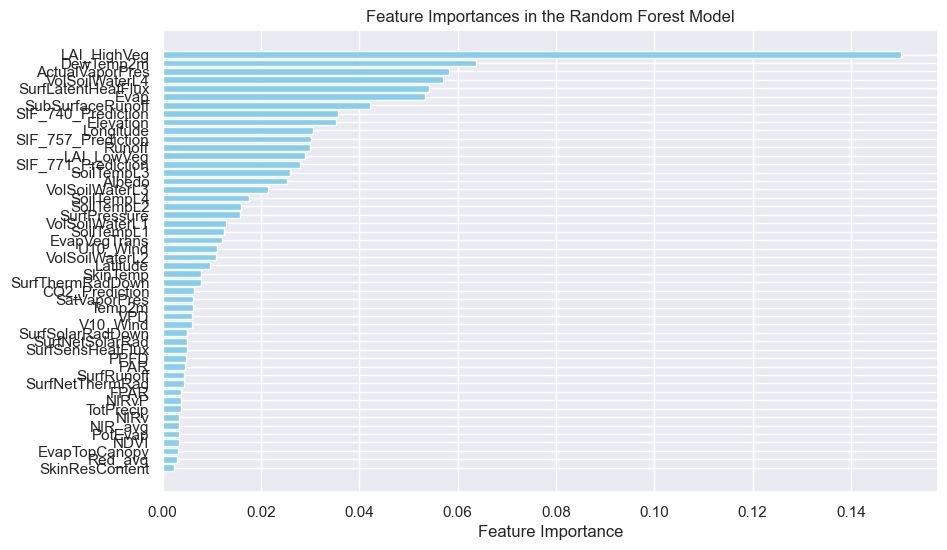

In [233]:
importances = best_rf.feature_importances_

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the Random Forest Model')
plt.show()

In [306]:
b_vars

Index(['LAI_HighVeg', 'SIF_757_Prediction', 'VolSoilWaterL4', 'DewTemp2m',
       'Albedo', 'Evap', 'Elevation'],
      dtype='object')

In [364]:
x = flux_val[['LAI_HighVeg','VolSoilWaterL4','DewTemp2m','Albedo','Evap','VPD']]
y = flux_val['GPP_DT_VUT_REF']

In [365]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=31)

In [366]:
params = {
    'n_estimators': [25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80],
    'min_samples_split': list(np.arange(2,20,1)),
    'min_samples_leaf': list(np.arange(1,10,1)),
    'max_features': ['sqrt','log2'] + list(np.arange(1,7,1)), 
    'bootstrap': [True,False]
}

In [369]:
rf=RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=params,
                                   cv=5, verbose=2, n_jobs=-1, n_iter=100,
                                   scoring='neg_root_mean_squared_error',
                                   error_score='raise')

start_time = time.time()
random_search.fit(x_train,y_train)
end_time = time.time()
print('time taken: ' + str(round(end_time - start_time,2)) + ' seconds.')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
time taken: 33.97 seconds.


In [390]:
best_params = random_search.best_params_
best_params

{'n_estimators': 450,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': False}

In [391]:
best_rf = RandomForestRegressor(
    n_estimators = best_params['n_estimators'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    bootstrap = best_params['bootstrap'],
    random_state = 31
)

# Train the model
best_rf.fit(x_train, y_train)

# Predict on the test set
y_pred = best_rf.predict(x_test)

In [392]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate mean bias
mean_bias = np.mean(y_pred - y_test)

# Print the evaluation metrics
print(f'RMSE: {round(rmse,4)}')
print(f'MAE: {round(mae,4)}')
print(f'R²: {round(r2,4)}')
print(f'Mean Bias: {round(mean_bias,4)}')

RMSE: 1.4013
MAE: 0.9493
R²: 0.8264
Mean Bias: 0.0458


In [ ]:
#LAI, DewTemp, SIF757, Evap, SoilWater4, Albedo, Elevation rmse 1.1746, mae 0.7541, r2 0.878, bias 0.0538
#Using NIRvP, PPFD, VPD and PAR as well as b_vars resultsed in rmse 1.1493, MAE 0.7747, r2 0.8832, mean bias 0.0456
#Just adding VPD rmse 1.1589, MAE 0.7307, r2 0.8812, bias 0.0693
#VPD instead of elevation rmse 1.1717, mae 0.7877, r2 0.8786, bia 0.1563

In [360]:
#Best so far

b_vars = x.columns
print('Best Features: '+str(b_vars))
b_params = best_params
print('Best Params: '+str(b_params))
b_rmse = round(rmse,4)
print('RMSE: '+str(b_rmse))
b_mae = round(mae,4)
print('MAE: '+str(b_mae))
b_r2 = round(r2,4)
print('r2: '+str(b_r2))
b_bias = round(mean_bias,4)
print('Bias: '+str(b_bias))

Best Features: Index(['LAI_HighVeg', 'VolSoilWaterL4', 'DewTemp2m', 'Albedo', 'Evap', 'VPD'], dtype='object')
Best Params: {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
RMSE: 1.1218
MAE: 0.76
r2: 0.8887
Bias: 0.1299


Feature Importances:
              Feature  Importance
0         LAI_HighVeg    0.307608
2           DewTemp2m    0.172515
1      VolSoilWaterL4    0.172075
4                Evap    0.158234
3  SIF_757_Prediction    0.125166
5                 VPD    0.064403


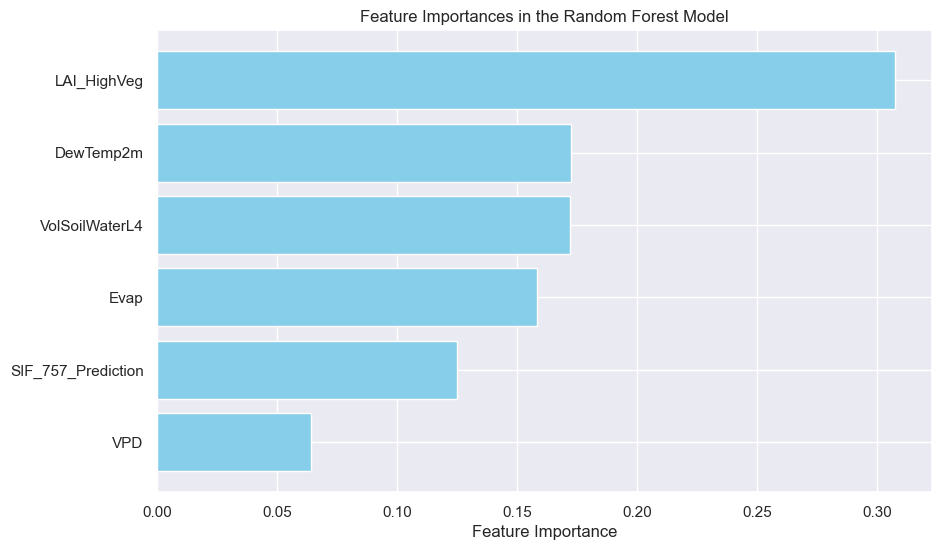

In [393]:
importances = best_rf.feature_importances_

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the Random Forest Model')
plt.show()

Iteration Function

This process is repated for all 6 model types

In [3]:
# Define list of columns based on previous selection methods

subcols = flux_val[['LAI_HighVeg','LAI_LowVeg','Longitude','Latitude','Evap','DewTemp2m','Temp2m','Albedo','VPD','SIF_757_Prediction','Elevation','SoilTempL3','VolSoilWaterL4']]
subcols1 = flux_val[['LAI_HighVeg','Longitude','Latitude','Evap','DewTemp2m','Albedo']]

In [7]:
params = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80],
    'min_samples_split': list(np.arange(2, 20, 1)),
    'min_samples_leaf': list(np.arange(1, 10, 1)),
    'max_features': ['sqrt', 'log2'] + list(np.arange(1, 7, 1)),
    'bootstrap': [True, False]
}

In [20]:
def evaluate_model(x_train, x_test, y_train, y_test):
    RF = RandomForestRegressor()
    
    # Setup the RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=RF,
        param_distributions=params,
        n_iter=40,  # Number of parameter settings that are sampled
        scoring='neg_mean_squared_error', 
        cv=5,  # 5-fold cross-validation
        verbose=0,
        random_state=31,
        n_jobs=-1  # Use all available cores
    )

    random_search.fit(x_train, y_train)
    
    # Best model from RandomizedSearchCV
    best_model = random_search.best_estimator_
    
    # Predict and evaluate
    y_pred = best_model.predict(x_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    
    feature_importances = best_model.feature_importances_
    feature_ranks = np.argsort(-feature_importances) + 1
    
    return rmse, mae, r2, mean_bias, feature_importances, feature_ranks, random_search.best_params_

In [21]:
column_combinations = list(itertools.combinations(subcols.columns, 5))

best_score = float('inf')
best_combination = None
best_model_results = {}
column_stats_rf5 = {col: {'rmse': [], 'mae': [], 'r2': [], 'mean_bias': [], 'importance_rank': []} for col in subcols.columns}

total_combinations = len(column_combinations)
print(f"Total combinations to evaluate: {total_combinations}\n")

Total combinations to evaluate: 1287



In [22]:
# Iterate over each combination and evaluate
counter = 0
start = time.time()
for combination in column_combinations:
    loop_start = time.time()
    counter += 1
    x = subcols[list(combination)]
    y = flux_val['GPP_DT_VUT_REF']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)
    
    rmse, mae, r2, mean_bias, feature_importances, feature_ranks, best_params = evaluate_model(x_train, x_test, y_train, y_test)
    
    if rmse < best_score:
        best_score = rmse
        best_combination = combination
        best_model_results = {
            'variables': combination,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mean_bias': mean_bias,
            'feature_importances': feature_importances,
            'best_params': best_params
        }
    
    for idx, col in enumerate(combination):
        column_stats_rf5[col]['rmse'].append(rmse)
        column_stats_rf5[col]['mae'].append(mae)
        column_stats_rf5[col]['r2'].append(r2)
        column_stats_rf5[col]['mean_bias'].append(mean_bias)
        column_stats_rf5[col]['importance_rank'].append(feature_ranks[idx])
        
    loop_end = time.time()
        
    if counter == 1 or counter % 25 == 0:
        print(f"Completed {counter} out of {total_combinations} combinations")
    if counter == 1:
        print(f"Time taken for the first loop: {round(loop_end - loop_start,2)} seconds")

end = time.time()
print("Evaluation complete.")
print(f"Total time taken: {round(end - start,2)} seconds.")

Completed 1 out of 1287 combinations
Time taken for the first loop: 14.92 seconds
Completed 25 out of 1287 combinations
Completed 50 out of 1287 combinations
Completed 75 out of 1287 combinations
Completed 100 out of 1287 combinations
Completed 125 out of 1287 combinations
Completed 150 out of 1287 combinations
Completed 175 out of 1287 combinations
Completed 200 out of 1287 combinations
Completed 225 out of 1287 combinations
Completed 250 out of 1287 combinations
Completed 275 out of 1287 combinations
Completed 300 out of 1287 combinations
Completed 325 out of 1287 combinations
Completed 350 out of 1287 combinations
Completed 375 out of 1287 combinations
Completed 400 out of 1287 combinations
Completed 425 out of 1287 combinations
Completed 450 out of 1287 combinations
Completed 475 out of 1287 combinations
Completed 500 out of 1287 combinations
Completed 525 out of 1287 combinations
Completed 550 out of 1287 combinations
Completed 575 out of 1287 combinations
Completed 600 out of 128

In [24]:
# Output the best model results
print(f"Best combination of variables: {best_model_results['variables']}")
print(f"Best Hyperparameters: {best_model_results['best_params']}")

print(f"Best RMSE: {best_model_results['rmse']}")
print(f"MAE: {best_model_results['mae']}")
print(f"R²: {best_model_results['r2']}")
print(f"Mean Bias: {best_model_results['mean_bias']}")
print(f"Feature Importances: {best_model_results['feature_importances']}")

Best combination of variables: ('LAI_HighVeg', 'Latitude', 'DewTemp2m', 'Albedo', 'VPD')
Best Hyperparameters: {'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 20, 'bootstrap': True}
Best RMSE: 1.0831037243874668
MAE: 0.7061595907226469
R²: 0.8962627326235653
Mean Bias: 0.10305109909716055
Feature Importances: [0.47786434 0.08165884 0.16997127 0.19075513 0.07975042]


Save best model

In [25]:
best_model_rf5 = best_model_results

In [23]:
# Calculate average metrics for each column
average_column_stats_rf5 = {
    col: {
        'avg_rmse': np.mean(stats['rmse']),
        'avg_mae': np.mean(stats['mae']),
        'avg_r2': np.mean(stats['r2']),
        'avg_mean_bias': np.mean(stats['mean_bias']),
        'avg_importance_rank': np.mean(stats['importance_rank'])
    }
    for col, stats in column_stats_rf5.items()
}

average_stats_rf5 = pd.DataFrame(average_column_stats_rf5).T.reset_index().rename(columns={'index': 'feature'})
average_stats_rf5 = average_stats_rf5.sort_values(by='avg_importance_rank')
average_stats_rf5

feature  avg_rmse   avg_mae    avg_r2  avg_mean_bias  \
0          LAI_HighVeg  1.321351  0.846422  0.844547       0.090385   
12      VolSoilWaterL4  1.360125  0.861108  0.835160       0.054429   
11          SoilTempL3  1.438572  0.935799  0.814138       0.086060   
10           Elevation  1.381467  0.891199  0.829645       0.066571   
4                 Evap  1.444854  0.978976  0.811786       0.077891   
9   SIF_757_Prediction  1.495731  0.988347  0.799711      -0.015544   
5            DewTemp2m  1.445047  0.984706  0.811425       0.084855   
6               Temp2m  1.502801  0.984836  0.797165       0.075218   
7               Albedo  1.338311  0.859689  0.839763       0.047962   
8                  VPD  1.443112  0.960507  0.811822       0.039872   
3             Latitude  1.390892  0.897270  0.826753       0.058144   
1           LAI_LowVeg  1.379715  0.879266  0.829811       0.063138   
2            Longitude  1.392214  0.901395  0.826504       0.059769   

    avg_importance_rank  
0              1.000000  
12             2.478788  
11             2.955556  
10             3.048485  
4              3.050505  
9              3.143434  
5              3.214141  
6              3.224242  
7              3.276768  
8              3.288889  
3              3.420202  
1              3.436364  
2              3.462626

6 columns

In [9]:
subcols = flux_val[['LAI_HighVeg','LAI_LowVeg','Longitude','Latitude','Evap','DewTemp2m','Albedo','VPD','SIF_757_Prediction','Elevation','SoilTempL3','VolSoilWaterL4']]

In [10]:
params = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': list(np.arange(2, 20, 1)),
    'min_samples_leaf': list(np.arange(1, 10, 1)),
    'max_features': ['sqrt', 'log2'] + list(np.arange(1, 7, 1)),
    'bootstrap': [True, False]
}

In [11]:
def evaluate_model(x_train, x_test, y_train, y_test):
    RF = RandomForestRegressor()
    
    # Setup the RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=RF,
        param_distributions=params,
        n_iter=20,  # Number of parameter settings that are sampled
        scoring='neg_mean_squared_error',  # Refitting based on RMSE
        cv=5,  # 5-fold cross-validation
        verbose=0,
        random_state=31,
        n_jobs=-1  # Use all available cores
    )

    # Fit the random search model
    random_search.fit(x_train, y_train)
    
    # Best model from RandomizedSearchCV
    best_model = random_search.best_estimator_
    
    # Predict and evaluate
    y_pred = best_model.predict(x_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    
    feature_importances = best_model.feature_importances_
    feature_ranks = np.argsort(-feature_importances) + 1
    
    return rmse, mae, r2, mean_bias, feature_importances, feature_ranks, random_search.best_params_

In [12]:
column_combinations = list(itertools.combinations(subcols.columns, 6))

best_score = float('inf')
best_combination = None
best_model_results = {}
column_stats_rf6 = {col: {'rmse': [], 'mae': [], 'r2': [], 'mean_bias': [], 'importance_rank': []} for col in subcols.columns}

# Calculate the total number of combinations
total_combinations = len(column_combinations)
print(f"Total combinations to evaluate: {total_combinations}\n")

Total combinations to evaluate: 924



In [13]:
# Iterate over each combination and evaluate
counter = 0
start = time.time()
for combination in column_combinations:
    loop_start = time.time()
    counter += 1
    x = subcols[list(combination)]
    y = flux_val['GPP_DT_VUT_REF']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)
    
    rmse, mae, r2, mean_bias, feature_importances, feature_ranks, best_params = evaluate_model(x_train, x_test, y_train, y_test)
    
    if rmse < best_score:
        best_score = rmse
        best_combination = combination
        best_model_results = {
            'variables': combination,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mean_bias': mean_bias,
            'feature_importances': feature_importances,
            'best_params': best_params
        }
    
    # Update column-wise statistics
    for idx, col in enumerate(combination):
        column_stats_rf6[col]['rmse'].append(rmse)
        column_stats_rf6[col]['mae'].append(mae)
        column_stats_rf6[col]['r2'].append(r2)
        column_stats_rf6[col]['mean_bias'].append(mean_bias)
        column_stats_rf6[col]['importance_rank'].append(feature_ranks[idx])
        
    loop_end = time.time()
        
    if counter == 1 or counter % 100 == 0:
        print(f"Completed {counter} out of {total_combinations} combinations")
    if counter == 1:
        print(f"Time taken for the first loop: {round(loop_end - loop_start,2)} seconds")

end = time.time()
print("Evaluation complete.")
print(f"Total time taken: {round(end - start,2)} seconds.")

Completed 1 out of 924 combinations
Time taken for the first loop: 8.6 seconds
Completed 100 out of 924 combinations
Completed 200 out of 924 combinations
Completed 300 out of 924 combinations
Completed 400 out of 924 combinations
Completed 500 out of 924 combinations
Completed 600 out of 924 combinations
Completed 700 out of 924 combinations
Completed 800 out of 924 combinations
Completed 900 out of 924 combinations
Evaluation complete.
Total time taken: 16848.99 seconds.


In [14]:
# Output the best model results
print(f"Best combination of variables: {best_model_results['variables']}")
print(f"Best Hyperparameters: {best_model_results['best_params']}")

print(f"Best RMSE: {best_model_results['rmse']}")
print(f"MAE: {best_model_results['mae']}")
print(f"R²: {best_model_results['r2']}")
print(f"Mean Bias: {best_model_results['mean_bias']}")
print(f"Feature Importances: {best_model_results['feature_importances']}")

Best combination of variables: ('LAI_HighVeg', 'Evap', 'DewTemp2m', 'Albedo', 'Elevation', 'VolSoilWaterL4')
Best Hyperparameters: {'n_estimators': 175, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 4, 'max_depth': 50, 'bootstrap': True}
Best RMSE: 1.1058154235126907
MAE: 0.7400765058827087
R²: 0.8918665669399982
Mean Bias: 0.13034667980621417
Feature Importances: [0.42414831 0.10504114 0.13965274 0.15180276 0.06729868 0.11205637]


In [15]:
best_model_rf6 = best_model_results

In [16]:
# Calculate average metrics for each column
average_column_stats_rf6 = {
    col: {
        'avg_rmse': np.mean(stats['rmse']),
        'avg_mae': np.mean(stats['mae']),
        'avg_r2': np.mean(stats['r2']),
        'avg_mean_bias': np.mean(stats['mean_bias']),
        'avg_importance_rank': np.mean(stats['importance_rank'])
    }
    for col, stats in column_stats_rf6.items()
}

# Convert the average column stats to a DataFrame and reorder by avg_importance_rank
average_stats_rf6 = pd.DataFrame(average_column_stats_rf6).T.reset_index().rename(columns={'index': 'feature'})
average_stats_rf6 = average_stats_rf6.sort_values(by='avg_importance_rank')
average_stats_rf6

feature  avg_rmse   avg_mae    avg_r2  avg_mean_bias  \
0          LAI_HighVeg  1.261046  0.801950  0.858849       0.078000   
11      VolSoilWaterL4  1.302342  0.828031  0.849276       0.036605   
10          SoilTempL3  1.338698  0.868825  0.840324       0.063665   
9            Elevation  1.311403  0.846509  0.847135       0.038502   
7                  VPD  1.326016  0.877901  0.843076       0.031326   
5            DewTemp2m  1.317782  0.887504  0.844911       0.050937   
4                 Evap  1.330556  0.895549  0.842107       0.055400   
6               Albedo  1.277888  0.818777  0.854697       0.042999   
8   SIF_757_Prediction  1.366687  0.899093  0.833854      -0.004312   
1           LAI_LowVeg  1.315750  0.840012  0.846013       0.040468   
3             Latitude  1.315174  0.848767  0.846047       0.037233   
2            Longitude  1.314208  0.849263  0.846318       0.038586   

    avg_importance_rank  
0              1.008658  
11             2.963203  
10             3.357143  
9              3.597403  
7              3.673160  
5              3.707792  
4              3.738095  
6              3.748918  
8              3.753247  
1              4.090909  
3              4.179654  
2              4.181818

XGBoost

P-Model

In [37]:
x_p = flux_val[['Temp2m','SurfPressure','VPD','CO2_Prediction','PPFD','NIRv']]
y = flux_val['GPP_DT_VUT_REF']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_p,y,test_size=0.2,random_state=31)

In [44]:
XGB = xgb.XGBRegressor()

params = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'gamma': np.linspace(0, 0.5, 10),
    'min_child_weight': np.arange(1, 10, 1),
    'reg_alpha': np.logspace(-3, 1, 10),
    'reg_lambda': np.logspace(-3, 1, 10)
}

In [51]:
random_search = RandomizedSearchCV(
    estimator = XGB,
    param_distributions = params,
    n_iter = 100, 
    scoring = 'neg_mean_squared_error',
    cv = 10,  
    verbose = 2,
    random_state = 31,
    n_jobs = -1  
)

start_time = time.time()
random_search.fit(x_train, y_train)
end_time = time.time()
print('time taken: ' + str(round(end_time - start_time,2)) + ' seconds.')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
time taken: 12.06 seconds.


In [52]:
best_params = random_search.best_params_
best_params

{'subsample': 1.0,
 'reg_lambda': 0.46415888336127775,
 'reg_alpha': 1.2915496650148828,
 'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.07105263157894737,
 'gamma': 0.0,
 'colsample_bytree': 0.5}

In [53]:
best_xgb = xgb.XGBRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    n_estimators = best_params['n_estimators'],
    min_child_weight = best_params['min_child_weight'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    gamma = best_params['gamma'],
    colsample_bytree = best_params['colsample_bytree'],
    random_state = 31
)

best_xgb.fit(x_train, y_train)

y_pred = best_xgb.predict(x_test)

In [54]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate mean bias
mean_bias = np.mean(y_pred - y_test)

# Print the evaluation metrics
print(f'RMSE: {round(rmse,4)}')
print(f'MAE: {round(mae,4)}')
print(f'R²: {round(r2,4)}')
print(f'Mean Bias: {round(mean_bias,4)}')

RMSE: 2.0787
MAE: 1.4655
R²: 0.6179
Mean Bias: -0.0789


Feature Importances:
          Feature  Importance
0          Temp2m    0.271178
4            PPFD    0.268358
1    SurfPressure    0.162327
2             VPD    0.130393
3  CO2_Prediction    0.101368
5            NIRv    0.066376


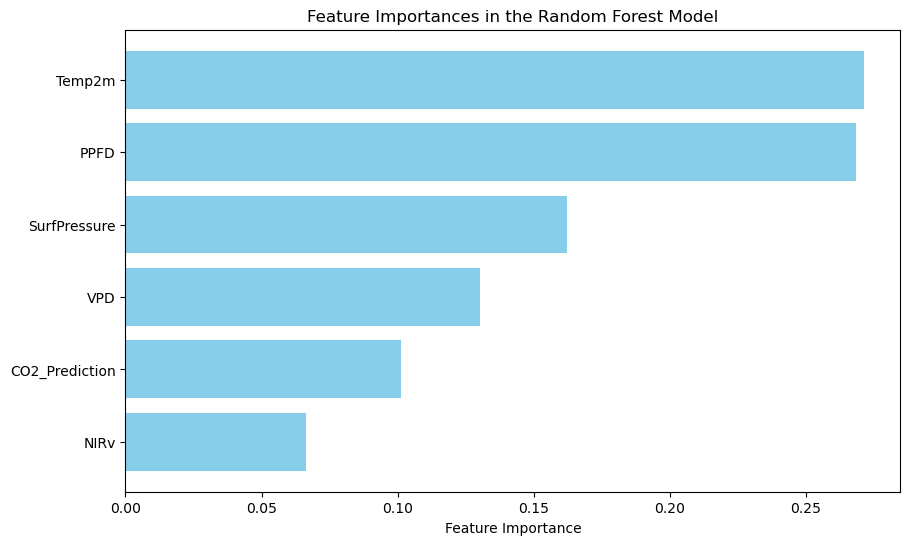

In [55]:
importances = best_xgb.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the XGBoost Model')
plt.show()

Whole dataset

In [74]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [75]:
random_search = RandomizedSearchCV(
    estimator = XGB,
    param_distributions = params,
    n_iter = 100, 
    scoring = 'neg_mean_squared_error',
    cv = 10,  
    verbose = 2,
    random_state = 31,
    n_jobs = -1  
)

start_time = time.time()
random_search.fit(x_train, y_train)
end_time = time.time()
print('time taken: ' + str(round(end_time - start_time,2)) + ' seconds.')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
time taken: 63.9 seconds.


In [76]:
best_params = random_search.best_params_
best_params

{'subsample': 0.6111111111111112,
 'reg_lambda': 1.2915496650148828,
 'reg_alpha': 0.021544346900318832,
 'n_estimators': 350,
 'min_child_weight': 4,
 'max_depth': 14,
 'learning_rate': 0.02526315789473684,
 'gamma': 0.1111111111111111,
 'colsample_bytree': 0.7777777777777778}

In [77]:
best_xgb = xgb.XGBRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    n_estimators = best_params['n_estimators'],
    min_child_weight = best_params['min_child_weight'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    gamma = best_params['gamma'],
    colsample_bytree = best_params['colsample_bytree'],
    random_state = 31
)

best_xgb.fit(x_train, y_train)

y_pred = best_xgb.predict(x_test)

In [78]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mean_bias = np.mean(y_pred - y_test)

# Print the evaluation metrics
print(f'RMSE: {round(rmse,4)}')
print(f'MAE: {round(mae,4)}')
print(f'R²: {round(r2,4)}')
print(f'Mean Bias: {round(mean_bias,4)}')

RMSE: 1.1579
MAE: 0.7958
R²: 0.8815
Mean Bias: 0.0259


Feature Importances:
               Feature  Importance
14         LAI_HighVeg    0.179340
13              Albedo    0.062830
1            Longitude    0.055314
10                Evap    0.052820
25  SurfLatentHeatFlux    0.049120
37      VolSoilWaterL4    0.042636
15          LAI_LowVeg    0.035474
22          SoilTempL3    0.034807
8            DewTemp2m    0.029869
0             Latitude    0.026329
24    SubSurfaceRunoff    0.024966
17              Runoff    0.023403
2   SIF_740_Prediction    0.021379
12        EvapVegTrans    0.019565
28        SurfPressure    0.019328
20          SoilTempL1    0.018967
47                 VPD    0.017935
34      VolSoilWaterL1    0.017510
43                PPFD    0.017449
44           Elevation    0.016431
6             U10_Wind    0.016296
23          SoilTempL4    0.015097
36      VolSoilWaterL3    0.014568
7             V10_Wind    0.013011
3   SIF_757_Prediction    0.012994
39             Red_avg    0.011374
21          SoilTempL2    0.011212

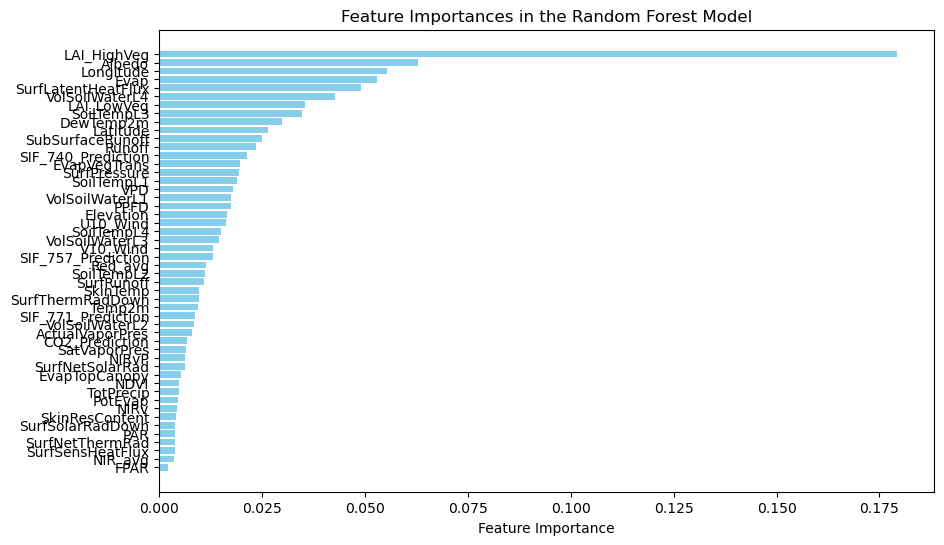

In [79]:
importances = best_xgb.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the XGBoost Model')
plt.show()

Actual modelling

In [300]:
x = flux_val[['LAI_HighVeg', 'Longitude', 'Albedo', 'Evap', 'Elevation']]
y = flux_val['GPP_DT_VUT_REF']

In [301]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=31)

In [302]:
XGB = xgb.XGBRegressor()

params = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'gamma': np.linspace(0, 0.5, 10),
    'min_child_weight': np.arange(1, 10, 1),
    'reg_alpha': np.logspace(-3, 1, 10),
    'reg_lambda': np.logspace(-3, 1, 10)
}

In [303]:
random_search = RandomizedSearchCV(
    estimator = XGB,
    param_distributions = params,
    n_iter = 100,
    scoring = 'neg_mean_squared_error',
    cv = 10,  
    verbose = 2,
    random_state = 31,
    n_jobs = -1  
)

start_time = time.time()
random_search.fit(x_train, y_train)
end_time = time.time()
print('time taken: ' + str(round(end_time - start_time,2)) + ' seconds.')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
time taken: 5.56 seconds.


In [304]:
best_params = random_search.best_params_
best_params

{'subsample': 0.5555555555555556,
 'reg_lambda': 0.05994842503189409,
 'reg_alpha': 0.1668100537200059,
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 7,
 'learning_rate': 0.10157894736842105,
 'gamma': 0.0,
 'colsample_bytree': 0.8333333333333333}

In [305]:
best_xgb = xgb.XGBRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    n_estimators = best_params['n_estimators'],
    min_child_weight = best_params['min_child_weight'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    gamma = best_params['gamma'],
    colsample_bytree = best_params['colsample_bytree'],
    random_state = 31
)

best_xgb.fit(x_train, y_train)

y_pred = best_xgb.predict(x_test)

In [306]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mean_bias = np.mean(y_pred - y_test)

# Print the evaluation metrics
print(f'RMSE: {round(rmse,4)}')
print(f'MAE: {round(mae,4)}')
print(f'R²: {round(r2,4)}')
print(f'Mean Bias: {round(mean_bias,4)}')

RMSE: 1.3574
MAE: 0.8365
R²: 0.8371
Mean Bias: 0.1874


Feature Importances:
       Feature  Importance
0  LAI_HighVeg    0.303632
4    Elevation    0.199371
1    Longitude    0.195486
2       Albedo    0.175722
3         Evap    0.125790


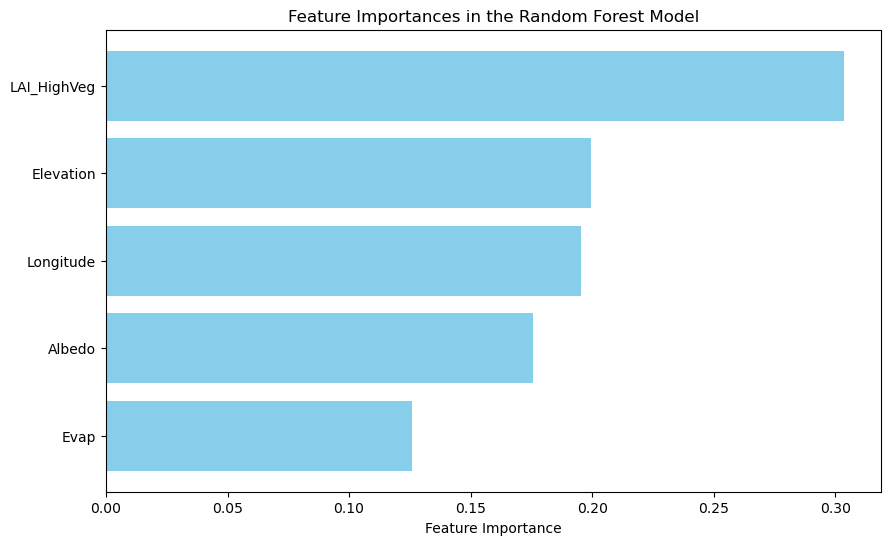

In [307]:
importances = best_xgb.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the Random Forest Model')
plt.show()

In [ ]:
# Best RF as XGB rmse 1,3557, mae 0.8703, r2 0.8375, bias 0.2094
# 'LAI_HighVeg', 'VolSoilWaterL4', 'Longitude', 'Albedo', 'Evap', 'DewTemp2m','Latitude'
# - rmse 1.1691, mae 0.8116, r2 0.8791, bias 0.1485

Iterative function

In [106]:
subcols = flux_val[['LAI_HighVeg','LAI_LowVeg','Longitude','Latitude','Evap','DewTemp2m','Temp2m','Albedo','VPD','SIF_757_Prediction','Elevation','SoilTempL3','VolSoilWaterL4']]
subcols1 = flux_val[['LAI_HighVeg','Longitude','Latitude','Evap','DewTemp2m','Albedo']]

5 columns

In [75]:
# Define the parameter grid for RandomizedSearchCV
params = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'gamma': np.linspace(0, 0.5, 10),
    'min_child_weight': np.arange(1, 10, 1),
    'reg_alpha': np.logspace(-3, 1, 10),
    'reg_lambda': np.logspace(-3, 1, 10)
}

In [76]:
def evaluate_model(x_train, x_test, y_train, y_test):
    XGB = xgb.XGBRegressor()

    random_search = RandomizedSearchCV(
        estimator = XGB,
        param_distributions = params,
        n_iter = 100,  
        scoring = 'neg_mean_squared_error', 
        cv = 5,  # 5-fold cross-validation
        verbose = 0,
        random_state = 31,
        n_jobs = -1  # Use all available cores
    )

    random_search.fit(x_train, y_train)
    
    # Best model from RandomizedSearchCV
    best_model = random_search.best_estimator_
    
    y_pred = best_model.predict(x_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    
    feature_importances = best_model.feature_importances_
    feature_ranks = np.argsort(-feature_importances) + 1
    
    return rmse, mae, r2, mean_bias, feature_importances,  feature_ranks, random_search.best_params_

In [107]:
# Generate all possible combinations of 5 columns out of the 10
column_combinations = list(itertools.combinations(subcols.columns, 5))

best_score = float('inf')
best_combination = None
best_model_results = {}
column_stats_xgb5 = {col: {'rmse': [], 'mae': [], 'r2': [], 'mean_bias': [], 'importance_rank': []} for col in subcols.columns}

total_combinations = comb(len(subcols.columns), 5)
print(f"Total combinations to evaluate: {total_combinations}")

Total combinations to evaluate: 1287


In [78]:
# Iterate over each combination and evaluate
counter = 0
start = time.time()
for combination in column_combinations:
    loop_start = time.time()
    counter += 1
    x = subcols[list(combination)]
    y = flux_val['GPP_DT_VUT_REF']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)
    
    rmse, mae, r2, mean_bias, feature_importances, feature_ranks, best_params = evaluate_model(x_train, x_test, y_train, y_test)
    
    if rmse < best_score:
        best_score = rmse
        best_combination = combination
        best_model_results = {
            'variables': combination,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mean_bias': mean_bias,
            'feature_importances': feature_importances,
            'best_params': best_params
        }
    
    # Update column statistics
    for idx, col in enumerate(combination):
        column_stats_xgb5[col]['rmse'].append(rmse)
        column_stats_xgb5[col]['mae'].append(mae)
        column_stats_xgb5[col]['r2'].append(r2)
        column_stats_xgb5[col]['mean_bias'].append(mean_bias)
        column_stats_xgb5[col]['importance_rank'].append(feature_ranks[idx])
        
    loop_end = time.time()
        
    if counter == 1 or counter % 25 == 0:
        print(f"Completed {counter} out of {total_combinations} combinations")
    if counter == 1:
        print(f"Time taken: {round(loop_end - loop_start,2)}")

end = time.time()
print("Evaluation complete.")
print(f"Time taken: {round(end - start,2)} seconds.")

# Calculate average metrics for each column
average_column_stats_xgb5 = {
    col: {
        'avg_rmse': np.mean(stats['rmse']),
        'avg_mae': np.mean(stats['mae']),
        'avg_r2': np.mean(stats['r2']),
        'avg_mean_bias': np.mean(stats['mean_bias']),
        'avg_importance_rank': np.mean(stats['importance_rank'])
    }
    for col, stats in column_stats_xgb5.items()
}

Completed 1 out of 1287 combinations
Time taken: 5.21
Completed 25 out of 1287 combinations
Completed 50 out of 1287 combinations
Completed 75 out of 1287 combinations
Completed 100 out of 1287 combinations
Completed 125 out of 1287 combinations
Completed 150 out of 1287 combinations
Completed 175 out of 1287 combinations
Completed 200 out of 1287 combinations
Completed 225 out of 1287 combinations
Completed 250 out of 1287 combinations
Completed 275 out of 1287 combinations
Completed 300 out of 1287 combinations
Completed 325 out of 1287 combinations
Completed 350 out of 1287 combinations
Completed 375 out of 1287 combinations
Completed 400 out of 1287 combinations
Completed 425 out of 1287 combinations
Completed 450 out of 1287 combinations
Completed 475 out of 1287 combinations
Completed 500 out of 1287 combinations
Completed 525 out of 1287 combinations
Completed 550 out of 1287 combinations
Completed 575 out of 1287 combinations
Completed 600 out of 1287 combinations
Completed 625

In [79]:
# Output the best model results
print(f"Best combination of variables: {best_model_results['variables']}")
print(f"Best Hyperparameters: {best_model_results['best_params']}")

print(f"Best RMSE: {best_model_results['rmse']}")
print(f"MAE: {best_model_results['mae']}")
print(f"R²: {best_model_results['r2']}")
print(f"Mean Bias: {best_model_results['mean_bias']}")
print(f"Feature Importances: {best_model_results['feature_importances']}")

Best combination of variables: ('LAI_HighVeg', 'Longitude', 'Albedo', 'VPD', 'VolSoilWaterL4')
Best Hyperparameters: {'subsample': 0.9444444444444444, 'reg_lambda': 0.1668100537200059, 'reg_alpha': 0.0027825594022071257, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 13, 'learning_rate': 0.25421052631578944, 'gamma': 0.2777777777777778, 'colsample_bytree': 0.9444444444444444}
Best RMSE: 1.0731247966215138
MAE: 0.6796531407832777
R²: 0.8981654459962004
Mean Bias: 0.16161900156514883
Feature Importances: [0.40650088 0.2855589  0.13573512 0.07015482 0.10205027]


In [116]:
best_model_xgb5 = best_model_results

best_model_xgb5

{'variables': ('LAI_HighVeg', 'Longitude', 'Albedo', 'VPD', 'VolSoilWaterL4'),
 'rmse': 1.0731247966215138,
 'mae': 0.6796531407832777,
 'r2': 0.8981654459962004,
 'mean_bias': 0.16161900156514883,
 'feature_importances': [0.40650088,
  0.2855589,
  0.13573512,
  0.07015482,
  0.10205027],
 'best_params': {'subsample': 0.9444444444444444,
  'reg_lambda': 0.1668100537200059,
  'reg_alpha': 0.0027825594022071257,
  'n_estimators': 50,
  'min_child_weight': 1,
  'max_depth': 13,
  'learning_rate': 0.25421052631578944,
  'gamma': 0.2777777777777778,
  'colsample_bytree': 0.9444444444444444}}

In [99]:
average_stats_xgb5 = pd.DataFrame(average_column_stats_xgb5).T.reset_index().rename(columns={'index': 'feature'})
average_stats_xgb5 = average_stats_xgb5.sort_values(by='avg_importance_rank')
average_stats_xgb5

feature  avg_rmse   avg_mae    avg_r2  avg_mean_bias  \
0          LAI_HighVeg  1.371709  0.875953  0.832683       0.078832   
2            Longitude  1.436955  0.946002  0.815750       0.064653   
3             Latitude  1.437203  0.948289  0.815804       0.063142   
1           LAI_LowVeg  1.442611  0.928128  0.814664       0.086882   
4                 Evap  1.478887  1.005249  0.804128       0.088750   
5            DewTemp2m  1.450229  0.978474  0.810917       0.054359   
12      VolSoilWaterL4  1.399882  0.905738  0.825554       0.064449   
6               Temp2m  1.523271  0.994707  0.792300       0.087273   
7               Albedo  1.417654  0.922405  0.820549       0.072567   
10           Elevation  1.434434  0.936256  0.816620       0.061178   
11          SoilTempL3  1.457280  0.961756  0.809968       0.089760   
9   SIF_757_Prediction  1.517464  1.015810  0.794164       0.010552   
8                  VPD  1.476986  0.983753  0.803936       0.044699   

    avg_importance_rank  
0              1.325253  
2              2.284848  
3              2.731313  
1              2.921212  
4              2.997980  
5              3.014141  
12             3.127273  
6              3.264646  
7              3.309091  
10             3.359596  
11             3.531313  
9              3.563636  
8              3.569697

6 columns

In [109]:
# Generate all possible combinations of 5 columns out of the 10
column_combinations = list(itertools.combinations(subcols.columns, 6))

best_score = float('inf')
best_combination = None
best_model_results = {}
column_stats_xgb6 = {col: {'rmse': [], 'mae': [], 'r2': [], 'mean_bias': [], 'importance_rank': []} for col in subcols.columns}

total_combinations = comb(len(subcols.columns), 6)
print(f"Total combinations to evaluate: {total_combinations}")

Total combinations to evaluate: 1716


In [110]:
# Iterate over each combination and evaluate
counter = 0
start = time.time()
for combination in column_combinations:
    loop_start = time.time()
    counter += 1
    x = subcols[list(combination)]
    y = flux_val['GPP_DT_VUT_REF']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)
    
    rmse, mae, r2, mean_bias, feature_importances, feature_ranks, best_params = evaluate_model(x_train, x_test, y_train, y_test)
    
    if rmse < best_score:
        best_score = rmse
        best_combination = combination
        best_model_results = {
            'variables': combination,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mean_bias': mean_bias,
            'feature_importances': feature_importances,
            'best_params': best_params
        }
    
    # Update column statistics
    for idx, col in enumerate(combination):
        column_stats_xgb6[col]['rmse'].append(rmse)
        column_stats_xgb6[col]['mae'].append(mae)
        column_stats_xgb6[col]['r2'].append(r2)
        column_stats_xgb6[col]['mean_bias'].append(mean_bias)
        column_stats_xgb6[col]['importance_rank'].append(feature_ranks[idx])
        
    loop_end = time.time()
        
    if counter == 1 or counter % 100 == 0:
        print(f"Completed {counter} out of {total_combinations} combinations")
    if counter == 1:
        print(f"Time taken: {round(loop_end - loop_start,2)}")

end = time.time()
print("Evaluation complete.")
print(f"Time taken: {round(end - start,2)} seconds.")

# Calculate average metrics for each column
average_column_stats_xgb6 = {
    col: {
        'avg_rmse': np.mean(stats['rmse']),
        'avg_mae': np.mean(stats['mae']),
        'avg_r2': np.mean(stats['r2']),
        'avg_mean_bias': np.mean(stats['mean_bias']),
        'avg_importance_rank': np.mean(stats['importance_rank'])
    }
    for col, stats in column_stats_xgb6.items()
}

Completed 1 out of 1716 combinations
Time taken: 5.73
Completed 100 out of 1716 combinations
Completed 200 out of 1716 combinations
Completed 300 out of 1716 combinations
Completed 400 out of 1716 combinations
Completed 500 out of 1716 combinations
Completed 600 out of 1716 combinations
Completed 700 out of 1716 combinations
Completed 800 out of 1716 combinations
Completed 900 out of 1716 combinations
Completed 1000 out of 1716 combinations
Completed 1100 out of 1716 combinations
Completed 1200 out of 1716 combinations
Completed 1300 out of 1716 combinations
Completed 1400 out of 1716 combinations
Completed 1500 out of 1716 combinations
Completed 1600 out of 1716 combinations
Completed 1700 out of 1716 combinations
Evaluation complete.
Time taken: 9521.69 seconds.


In [111]:
# Output the best model results
print(f"Best combination of variables: {best_model_results['variables']}")
print(f"Best Hyperparameters: {best_model_results['best_params']}")

print(f"Best RMSE: {best_model_results['rmse']}")
print(f"MAE: {best_model_results['mae']}")
print(f"R²: {best_model_results['r2']}")
print(f"Mean Bias: {best_model_results['mean_bias']}")
print(f"Feature Importances: {best_model_results['feature_importances']}")

Best combination of variables: ('LAI_HighVeg', 'LAI_LowVeg', 'Longitude', 'DewTemp2m', 'VPD', 'SoilTempL3')
Best Hyperparameters: {'subsample': 0.9444444444444444, 'reg_lambda': 0.0027825594022071257, 'reg_alpha': 0.46415888336127775, 'n_estimators': 350, 'min_child_weight': 7, 'max_depth': 14, 'learning_rate': 0.16263157894736843, 'gamma': 0.0, 'colsample_bytree': 0.6666666666666666}
Best RMSE: 1.040053182143163
MAE: 0.6568365477887735
R²: 0.9043454133124216
Mean Bias: 0.051379607856091865
Feature Importances: [0.57137364 0.18483026 0.05818783 0.07500412 0.06028716 0.050317  ]


In [112]:
best_model_xgb6 = best_model_results
best_model_xgb6

{'variables': ('LAI_HighVeg',
  'LAI_LowVeg',
  'Longitude',
  'DewTemp2m',
  'VPD',
  'SoilTempL3'),
 'rmse': 1.040053182143163,
 'mae': 0.6568365477887735,
 'r2': 0.9043454133124216,
 'mean_bias': 0.051379607856091865,
 'feature_importances': array([0.57137364, 0.18483026, 0.05818783, 0.07500412, 0.06028716,
        0.050317  ], dtype=float32),
 'best_params': {'subsample': 0.9444444444444444,
  'reg_lambda': 0.0027825594022071257,
  'reg_alpha': 0.46415888336127775,
  'n_estimators': 350,
  'min_child_weight': 7,
  'max_depth': 14,
  'learning_rate': 0.16263157894736843,
  'gamma': 0.0,
  'colsample_bytree': 0.6666666666666666}}

In [117]:
average_stats_xgb6 = pd.DataFrame(average_column_stats_xgb6).T.reset_index().rename(columns={'index': 'feature'})
average_stats_xgb6 = average_stats_xgb6.sort_values(by='avg_importance_rank')
average_stats_xgb6

feature  avg_rmse   avg_mae    avg_r2  avg_mean_bias  \
0          LAI_HighVeg  1.329254  0.840725  0.842885       0.089202   
2            Longitude  1.376730  0.900572  0.831100       0.079446   
3             Latitude  1.381713  0.902629  0.829791       0.079093   
1           LAI_LowVeg  1.388225  0.886838  0.828394       0.094283   
4                 Evap  1.406710  0.947023  0.823493       0.096231   
5            DewTemp2m  1.371937  0.921511  0.831537       0.071638   
6               Temp2m  1.440350  0.933349  0.815006       0.096239   
7               Albedo  1.352732  0.877942  0.837189       0.086292   
12      VolSoilWaterL4  1.358271  0.879434  0.835791       0.079019   
10           Elevation  1.388091  0.904158  0.828335       0.076399   
8                  VPD  1.397140  0.918042  0.825582       0.071440   
9   SIF_757_Prediction  1.435670  0.944951  0.816393       0.032705   
11          SoilTempL3  1.386481  0.904329  0.828684       0.092176   

    avg_importance_rank  
0              1.051768  
2              2.539141  
3              3.054293  
1              3.061869  
4              3.324495  
5              3.443182  
6              3.708333  
7              3.779040  
12             3.915404  
10             4.228535  
8              4.347222  
9              4.361111  
11             4.685606

LightGBM

In [62]:
x_train,x_test,y_train,y_test = train_test_split(x_p,y,test_size=0.2,random_state=31)

In [126]:
LGBM = lgb.LGBMRegressor(verbose=-1)

params = {
    'n_estimators': [50, 100, 150, 200, 250, 300],  
    'max_depth': [-1, 5, 10, 15, 20],  
    'num_leaves': list(np.arange(10, 100, 10)),  
    'min_child_samples': list(np.arange(5, 50, 5)),  
    'learning_rate': np.linspace(0.01, 0.2, 10), 
    'subsample': np.linspace(0.6, 1.0, 5),  
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  
    'boosting_type': ['gbdt', 'dart'],  
    'reg_alpha': [0, 0.01, 0.1, 0.5],  
    'reg_lambda': [0, 0.01, 0.1, 0.5]
}

In [64]:
random_search = RandomizedSearchCV(
    estimator = LGBM,
    param_distributions = params,
    n_iter = 50,  # Number of parameter settings that are sampled
    scoring = 'neg_mean_squared_error',
    cv = 10,  
    verbose = 2,
    random_state = 31,
    n_jobs = -1  
)

start_time = time.time()
random_search.fit(x_train, y_train)
end_time = time.time()
print('time taken: ' + str(round(end_time - start_time,2)) + ' seconds.')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 6
[LightGBM] [Info] Start training from score 3.127669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [65]:
best_params = random_search.best_params_
best_params

{'subsample': 0.7,
 'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'num_leaves': 60,
 'n_estimators': 150,
 'min_child_samples': 10,
 'max_depth': -1,
 'learning_rate': 0.11555555555555555,
 'colsample_bytree': 0.8,
 'boosting_type': 'dart'}

In [66]:
best_lgbm = lgb.LGBMRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    num_leaves = best_params['num_leaves'],
    n_estimators = best_params['n_estimators'],
    min_child_samples = best_params['min_child_samples'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    colsample_bytree = best_params['colsample_bytree'],
    boosting_type = best_params['boosting_type'],
    random_state = 31
)

best_lgbm.fit(x_train, y_train)

y_pred = best_lgbm.predict(x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 6
[LightGBM] [Info] Start training from score 3.127669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [67]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate mean bias
mean_bias = np.mean(y_pred - y_test)

# Print the evaluation metrics
print(f'RMSE: {round(rmse,4)}')
print(f'MAE: {round(mae,4)}')
print(f'R²: {round(r2,4)}')
print(f'Mean Bias: {round(mean_bias,4)}')

RMSE: 2.1496
MAE: 1.5672
R²: 0.5914
Mean Bias: -0.146


Feature Importances:
          Feature  Importance
1    SurfPressure         706
0          Temp2m         614
4            PPFD         555
2             VPD         488
3  CO2_Prediction         393
5            NIRv         317


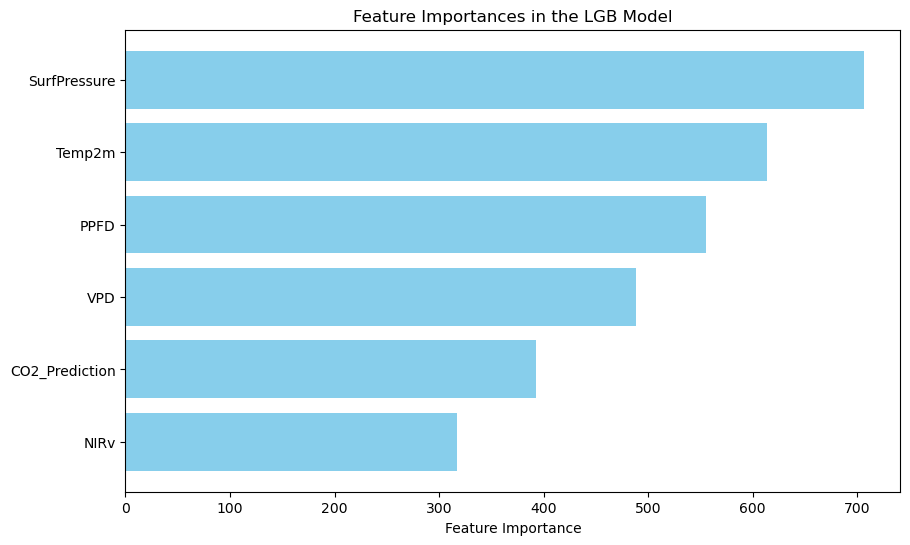

In [68]:
importances = best_lgbm.feature_importances_

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the LGB Model')
plt.show()

In [127]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [128]:
random_search = RandomizedSearchCV(
    estimator = LGBM,
    param_distributions = params,
    n_iter = 100,  
    scoring = 'neg_mean_squared_error',
    cv = 5,  
    verbose = 2,
    random_state = 31,
    n_jobs = -1  
)

start_time = time.time()
random_search.fit(x_train, y_train)
end_time = time.time()
print('time taken: ' + str(round(end_time - start_time,2)) + ' seconds.')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
time taken: 32.86 seconds.


In [129]:
best_lgbm = lgb.LGBMRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    num_leaves = best_params['num_leaves'],
    n_estimators = best_params['n_estimators'],
    min_child_samples = best_params['min_child_samples'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    colsample_bytree = best_params['colsample_bytree'],
    boosting_type = best_params['boosting_type'],
    random_state = 31,
    verbose=-1
)

best_lgbm.fit(x_train, y_train)

y_pred = best_lgbm.predict(x_test)

In [130]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate mean bias
mean_bias = np.mean(y_pred - y_test)

# Print the evaluation metrics
print(f'RMSE: {round(rmse,4)}')
print(f'MAE: {round(mae,4)}')
print(f'R²: {round(r2,4)}')
print(f'Mean Bias: {round(mean_bias,4)}')

RMSE: 1.2097
MAE: 0.7995
R²: 0.8706
Mean Bias: 0.0892


Feature Importances:
               Feature  Importance
14         LAI_HighVeg          85
12        EvapVegTrans          63
10                Evap          62
30    SurfSensHeatFlux          59
2   SIF_740_Prediction          58
36      VolSoilWaterL3          54
5       CO2_Prediction          51
7             V10_Wind          49
13              Albedo          48
8            DewTemp2m          43
28        SurfPressure          43
35      VolSoilWaterL2          42
38             NIR_avg          40
3   SIF_757_Prediction          39
15          LAI_LowVeg          38
11       EvapTopCanopy          36
17              Runoff          35
32    SurfThermRadDown          34
39             Red_avg          33
6             U10_Wind          33
33           TotPrecip          33
9               Temp2m          30
16             PotEvap          29
37      VolSoilWaterL4          28
41                NIRv          28
48               NIRvP          28
27     SurfNetThermRad          26

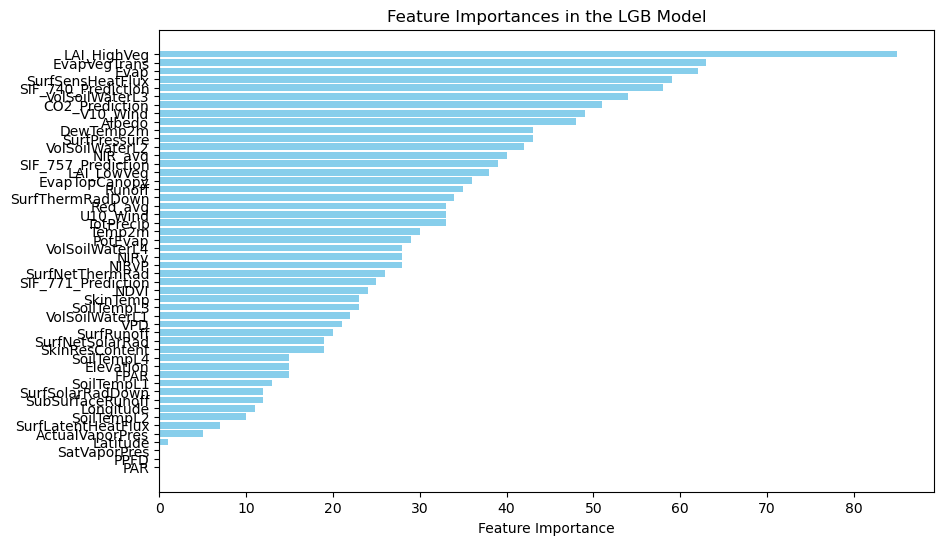

In [131]:
importances = best_lgbm.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the LGB Model')
plt.show()

Iteration

In [9]:
subcols = flux_val[['LAI_HighVeg','LAI_LowVeg','DewTemp2m', 'EvapVegTrans',
                    'Albedo','VPD','SIF_757_Prediction', 'U10_Wind',
                    'VolSoilWaterL3', 'VolSoilWaterL1', 'SIF_740_Prediction', 'NDVI', 'CO2_Prediction']]

In [10]:
params = {
    'n_estimators': [50, 100, 150, 200, 250],  
    'max_depth': [-1, 5, 10, 15, 20],  
    'num_leaves': list(np.arange(10, 100, 10)),  
    'min_child_samples': list(np.arange(5, 50, 5)),  
    'learning_rate': np.linspace(0.01, 0.2, 10), 
    'subsample': np.linspace(0.6, 1.0, 5),  
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  
    'boosting_type': ['gbdt', 'dart'],  
    'reg_alpha': [0, 0.01, 0.1, 0.5],  
    'reg_lambda': [0, 0.01, 0.1, 0.5]
}

In [11]:
def evaluate_model(x_train, x_test, y_train, y_test):
    LGBM = lgb.LGBMRegressor(verbose=-1)
    
    # Setup the RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=LGBM,
        param_distributions=params,
        n_iter=25, 
        scoring='neg_mean_squared_error', 
        cv=5,  
        verbose=0,
        random_state=31,
        n_jobs=-1  
    )

    random_search.fit(x_train, y_train)
    
    # Best model from RandomizedSearchCV
    best_model = random_search.best_estimator_
    
    y_pred = best_model.predict(x_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    
    feature_importances = best_model.feature_importances_
    feature_ranks = np.argsort(-feature_importances) + 1
    
    return rmse, mae, r2, mean_bias, feature_importances, feature_ranks, random_search.best_params_

In [12]:
column_combinations = list(itertools.combinations(subcols.columns, 5))

best_score = float('inf')
best_combination = None
best_model_results = {}
column_stats_lgbm5 = {col: {'rmse': [], 'mae': [], 'r2': [], 'mean_bias': [], 'importance_rank': []} for col in subcols.columns}

# Calculate the total number of combinations
total_combinations = len(column_combinations)
print(f"Total combinations to evaluate: {total_combinations}")

Total combinations to evaluate: 1287


In [13]:
# Iterate over each combination and evaluate
counter = 0
start = time.time()
for combination in column_combinations:
    loop_start = time.time()
    counter += 1
    x = subcols[list(combination)]
    y = flux_val['GPP_DT_VUT_REF']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)
    
    rmse, mae, r2, mean_bias, feature_importances, feature_ranks, best_params = evaluate_model(x_train, x_test, y_train, y_test)
    
    if rmse < best_score:
        best_score = rmse
        best_combination = combination
        best_model_results = {
            'variables': combination,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mean_bias': mean_bias,
            'feature_importances': feature_importances,
            'best_params': best_params
        }
    
    # Update column statistics
    for idx, col in enumerate(combination):
        column_stats_lgbm5[col]['rmse'].append(rmse)
        column_stats_lgbm5[col]['mae'].append(mae)
        column_stats_lgbm5[col]['r2'].append(r2)
        column_stats_lgbm5[col]['mean_bias'].append(mean_bias)
        column_stats_lgbm5[col]['importance_rank'].append(feature_ranks[idx])
        
    loop_end = time.time()
        
    if counter == 1 or counter % 50 == 0:
        print(f"Completed {counter} out of {total_combinations} combinations")
    if counter == 1:
        print(f"Time taken for the first loop: {round(loop_end - loop_start,2)} seconds")

end = time.time()
print("Evaluation complete.")
print(f"Total time taken: {round(end - start,2)} seconds.")

Completed 1 out of 1287 combinations
Time taken for the first loop: 7.68 seconds
Completed 50 out of 1287 combinations
Completed 100 out of 1287 combinations
Completed 150 out of 1287 combinations
Completed 200 out of 1287 combinations
Completed 250 out of 1287 combinations
Completed 300 out of 1287 combinations
Completed 350 out of 1287 combinations
Completed 400 out of 1287 combinations
Completed 450 out of 1287 combinations
Completed 500 out of 1287 combinations
Completed 550 out of 1287 combinations
Completed 600 out of 1287 combinations
Completed 650 out of 1287 combinations
Completed 700 out of 1287 combinations
Completed 750 out of 1287 combinations
Completed 800 out of 1287 combinations
Completed 850 out of 1287 combinations
Completed 900 out of 1287 combinations
Completed 950 out of 1287 combinations
Completed 1000 out of 1287 combinations
Completed 1050 out of 1287 combinations
Completed 1100 out of 1287 combinations
Completed 1150 out of 1287 combinations
Completed 1200 out 

In [14]:
# Output the best model results
print(f"Best combination of variables: {best_model_results['variables']}")
print(f"Best Hyperparameters: {best_model_results['best_params']}")

print(f"Best RMSE: {best_model_results['rmse']}")
print(f"MAE: {best_model_results['mae']}")
print(f"R²: {best_model_results['r2']}")
print(f"Mean Bias: {best_model_results['mean_bias']}")
print(f"Feature Importances: {best_model_results['feature_importances']}")

Best combination of variables: ('LAI_HighVeg', 'LAI_LowVeg', 'DewTemp2m', 'EvapVegTrans', 'Albedo')
Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0, 'num_leaves': 60, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.1577777777777778, 'colsample_bytree': 1.0, 'boosting_type': 'dart'}
Best RMSE: 1.1451327268641986
MAE: 0.7537019812483914
R²: 0.884040493483373
Mean Bias: -0.09765445219782037
Feature Importances: [398 413 507 365 409]


In [15]:
# Calculate average metrics for each column
average_column_stats_lgbm5 = {
    col: {
        'avg_rmse': np.mean(stats['rmse']),
        'avg_mae': np.mean(stats['mae']),
        'avg_r2': np.mean(stats['r2']),
        'avg_mean_bias': np.mean(stats['mean_bias']),
        'avg_importance_rank': np.mean(stats['importance_rank'])
    }
    for col, stats in column_stats_lgbm5.items()
}

# Convert the average column stats to a DataFrame and reorder by avg_importance_rank
average_stats_lgbm5 = pd.DataFrame(average_column_stats_lgbm5).T.reset_index().rename(columns={'index': 'feature'})
average_stats_lgbm5 = average_stats_lgbm5.sort_values(by='avg_importance_rank')
average_stats_lgbm5

feature  avg_rmse   avg_mae    avg_r2  avg_mean_bias  \
1           LAI_LowVeg  1.661788  1.101511  0.751880      -0.013943   
0          LAI_HighVeg  1.601125  1.040118  0.770158      -0.021964   
4               Albedo  1.657776  1.101052  0.751065      -0.068271   
3         EvapVegTrans  1.834355  1.221454  0.694836      -0.084098   
2            DewTemp2m  1.805500  1.191171  0.702862      -0.091975   
5                  VPD  1.816444  1.222293  0.699885      -0.133238   
6   SIF_757_Prediction  1.859875  1.240912  0.686423      -0.132466   
8       VolSoilWaterL3  1.752449  1.161254  0.721600      -0.090198   
7             U10_Wind  1.904509  1.293027  0.670993      -0.131638   
9       VolSoilWaterL1  1.843849  1.233332  0.692571      -0.106183   
10  SIF_740_Prediction  1.906735  1.285320  0.670824      -0.131502   
12      CO2_Prediction  1.887412  1.266417  0.677537      -0.137178   
11                NDVI  1.871138  1.250128  0.682867      -0.082761   

    avg_importance_rank  
1              2.298990  
0              2.468687  
4              2.632323  
3              2.652525  
2              2.703030  
5              2.945455  
6              3.076768  
8              3.088889  
7              3.137374  
9              3.367677  
10             3.505051  
12             3.505051  
11             3.618182

In [16]:
best_model_lgbm5 = best_model_results

6 columns

In [21]:
subcols = flux_val[['LAI_HighVeg','LAI_LowVeg','DewTemp2m', 'EvapVegTrans',
                    'Albedo','VPD','SIF_757_Prediction', 'U10_Wind',
                    'VolSoilWaterL3', 'VolSoilWaterL1', 'SIF_740_Prediction', 'CO2_Prediction']]

In [22]:
column_combinations = list(itertools.combinations(subcols.columns, 6))

best_score = float('inf')
best_combination = None
best_model_results = {}
column_stats_lgbm6 = {col: {'rmse': [], 'mae': [], 'r2': [], 'mean_bias': [], 'importance_rank': []} for col in subcols.columns}

# Calculate the total number of combinations
total_combinations = len(column_combinations)
print(f"Total combinations to evaluate: {total_combinations}")

Total combinations to evaluate: 924


In [23]:
# Iterate over each combination and evaluate
counter = 0
start = time.time()
for combination in column_combinations:
    loop_start = time.time()
    counter += 1
    x = subcols[list(combination)]
    y = flux_val['GPP_DT_VUT_REF']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)
    
    rmse, mae, r2, mean_bias, feature_importances, feature_ranks, best_params = evaluate_model(x_train, x_test, y_train, y_test)
    
    if rmse < best_score:
        best_score = rmse
        best_combination = combination
        best_model_results = {
            'variables': combination,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mean_bias': mean_bias,
            'feature_importances': feature_importances,
            'best_params': best_params
        }

    for idx, col in enumerate(combination):
        column_stats_lgbm6[col]['rmse'].append(rmse)
        column_stats_lgbm6[col]['mae'].append(mae)
        column_stats_lgbm6[col]['r2'].append(r2)
        column_stats_lgbm6[col]['mean_bias'].append(mean_bias)
        column_stats_lgbm6[col]['importance_rank'].append(feature_ranks[idx])
        
    loop_end = time.time()
        
    if counter == 1 or counter % 50 == 0:
        print(f"Completed {counter} out of {total_combinations} combinations")
    if counter == 1:
        print(f"Time taken for the first loop: {round(loop_end - loop_start,2)} seconds")

end = time.time()
print("Evaluation complete.")
print(f"Total time taken: {round(end - start,2)} seconds.")

Completed 1 out of 924 combinations
Time taken for the first loop: 7.57 seconds
Completed 50 out of 924 combinations
Completed 100 out of 924 combinations
Completed 150 out of 924 combinations
Completed 200 out of 924 combinations
Completed 250 out of 924 combinations
Completed 300 out of 924 combinations
Completed 350 out of 924 combinations
Completed 400 out of 924 combinations
Completed 450 out of 924 combinations
Completed 500 out of 924 combinations
Completed 550 out of 924 combinations
Completed 600 out of 924 combinations
Completed 650 out of 924 combinations
Completed 700 out of 924 combinations
Completed 750 out of 924 combinations
Completed 800 out of 924 combinations
Completed 850 out of 924 combinations
Completed 900 out of 924 combinations
Evaluation complete.
Total time taken: 19413.99 seconds.


In [24]:
# Output the best model results
print(f"Best combination of variables: {best_model_results['variables']}")
print(f"Best Hyperparameters: {best_model_results['best_params']}")

print(f"Best RMSE: {best_model_results['rmse']}")
print(f"MAE: {best_model_results['mae']}")
print(f"R²: {best_model_results['r2']}")
print(f"Mean Bias: {best_model_results['mean_bias']}")
print(f"Feature Importances: {best_model_results['feature_importances']}")

Best combination of variables: ('LAI_HighVeg', 'DewTemp2m', 'Albedo', 'VPD', 'U10_Wind', 'VolSoilWaterL3')
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'num_leaves': 90, 'n_estimators': 150, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6, 'boosting_type': 'dart'}
Best RMSE: 1.0959092810148037
MAE: 0.7443714650391257
R²: 0.8937952563314157
Mean Bias: -0.09176140884753614
Feature Importances: [602 503 460 391 418 525]


In [37]:
best_model_results_lgbm6 = best_model_resuts

In [25]:
# Calculate average metrics for each column
average_column_stats_lgbm6 = {
    col: {
        'avg_rmse': np.mean(stats['rmse']),
        'avg_mae': np.mean(stats['mae']),
        'avg_r2': np.mean(stats['r2']),
        'avg_mean_bias': np.mean(stats['mean_bias']),
        'avg_importance_rank': np.mean(stats['importance_rank'])
    }
    for col, stats in column_stats_lgbm6.items()
}

# Convert the average column stats to a DataFrame and reorder by avg_importance_rank
average_stats_lgbm6 = pd.DataFrame(average_column_stats_lgbm6).T.reset_index().rename(columns={'index': 'feature'})
average_stats_lgbm6 = average_stats_lgbm6.sort_values(by='avg_importance_rank')
average_stats_lgbm6

feature  avg_rmse   avg_mae    avg_r2  avg_mean_bias  \
1           LAI_LowVeg  1.572464  1.035987  0.778624      -0.051142   
0          LAI_HighVeg  1.511837  0.986068  0.795650      -0.041639   
3         EvapVegTrans  1.677344  1.112688  0.745440      -0.082815   
2            DewTemp2m  1.636735  1.079202  0.756997      -0.083082   
4               Albedo  1.540137  1.018207  0.786725      -0.073166   
5                  VPD  1.655695  1.108770  0.751527      -0.118968   
6   SIF_757_Prediction  1.688483  1.120308  0.742264      -0.115585   
11      CO2_Prediction  1.708028  1.138030  0.736642      -0.113568   
8       VolSoilWaterL3  1.642438  1.091158  0.756086      -0.094158   
7             U10_Wind  1.700016  1.142779  0.738489      -0.117988   
9       VolSoilWaterL1  1.686562  1.120910  0.742710      -0.093927   
10  SIF_740_Prediction  1.726659  1.149746  0.731016      -0.106527   

    avg_importance_rank  
1              2.162338  
0              2.469697  
3              3.116883  
2              3.125541  
4              3.173160  
5              3.692641  
6              3.705628  
11             3.997835  
8              4.041126  
7              4.145022  
9              4.173160  
10             4.196970

Tracking which features were used in all 6 models

In [18]:
features_used = ['LAI_HighVeg', 'DewTemp2m', 'Albedo', 'VPD', 'U10_Wind', 'Longitude', 'Latitude', 'Elevation',
                 'VolSoilWaterL3', 'LAI_LowVeg', 'EvapVegTrans', 'SoilTempL3', 'VolSoilWaterL4', 'Evap']

Validation Dataset importation

In [6]:
valid = pd.read_excel('ERA5_Validation_Data.xlsx')
del valid['Unnamed: 0']
valid.describe()

Date     U10_Wind    DewTemp2m       Temp2m  \
count                 5400  5400.000000  5400.000000  5400.000000   
mean   2013-07-03 11:06:40     0.477065     6.567550    13.547207   
min    2012-01-11 00:00:00    -7.037473   -30.242034   -25.919803   
25%    2012-10-07 18:00:00    -0.702064     0.216310     7.527368   
50%    2013-07-11 00:00:00     0.529340     7.290866    14.499876   
75%    2014-03-31 12:00:00     1.653141    13.300111    22.166383   
max    2014-12-28 00:00:00    12.001357    24.735058    37.402329   
std                    NaN     2.027803    10.644807    10.212348   

              Evap  EvapVegTrans       Albedo  LAI_HighVeg   LAI_LowVeg  \
count  5400.000000   5400.000000  5400.000000  5400.000000  5400.000000   
mean     -0.825884     -0.046797     0.174677     2.461178     1.693093   
min      -3.834637     -2.691413     0.096248     0.501678     0.000000   
25%      -1.353307     -0.011286     0.134073     1.748016     0.748749   
50%      -0.711827     -0.001742     0.153114     2.438034     2.054825   
75%      -0.207257     -0.000178     0.173130     3.041229     2.510849   
max       0.649314      0.328512     0.625419     5.506439     3.361481   
std       0.660981      0.166193     0.076656     1.241888     1.004180   

        SoilTempL3  SurfPressure  VolSoilWaterL3  VolSoilWaterL4    Longitude  \
count  5400.000000   5400.000000     5400.000000     5400.000000  5400.000000   
mean     14.977257     94.745314        0.270367        0.278882   -14.939080   
min      -1.165956     69.019677        0.076918        0.079204  -110.866000   
25%       8.391802     90.290395        0.200770        0.199939   -90.272300   
50%      15.092419     97.715913        0.265855        0.291240     3.595700   
75%      23.467259    100.596320        0.341336        0.362346     8.410400   
max      31.180758    103.268756        0.450280        0.454718   151.713800   
std       8.673290      8.158439        0.088398        0.099674    79.352321   

          Latitude  
count  5400.000000  
mean     27.796733  
min     -34.002100  
25%       5.278800  
50%      40.606200  
75%      45.945900  
max      52.166600  
std      27.436156

Adding site demographics based on coords

In [7]:
sites = [
    {'Site': 'DE_RUS', 'Latitude': 50.8659, 'Longitude': 6.4471},
    {'Site': 'GF_GUY', 'Latitude': 5.2788, 'Longitude': -52.9249},
    {'Site': 'US_PFA', 'Latitude': 45.9459, 'Longitude': -90.2723},
    {'Site': 'GH_ANK', 'Latitude': 5.2685, 'Longitude': -2.6942},
    {'Site': 'US_SRM', 'Latitude': 31.8214, 'Longitude': -110.8660},
    {'Site': 'CH_CHA', 'Latitude': 47.2102, 'Longitude': 8.4104},
    {'Site': 'IT_COL', 'Latitude': 41.8494, 'Longitude': 13.5881},
    {'Site': 'US_WCR', 'Latitude': 45.8059, 'Longitude': -90.0799},
    {'Site': 'AU_CPR', 'Latitude': -34.0021, 'Longitude': 140.5891},
    {'Site': 'US_WKG', 'Latitude': 31.7365, 'Longitude': -109.9420},
    {'Site': 'IT_NOE', 'Latitude': 40.6062, 'Longitude': 8.1517},
    {'Site': 'FR_PUE', 'Latitude': 43.7413, 'Longitude': 3.5957},
    {'Site': 'NL_LOO', 'Latitude': 52.1666, 'Longitude': 5.7436},
    {'Site': 'US_NR1', 'Latitude': 40.0329, 'Longitude': -105.5464},
    {'Site': 'AU_GIN', 'Latitude': -31.3764, 'Longitude': 151.7138}
]

In [8]:
def find_site_name(lat, lon):
    for site in sites:
        if site['Latitude'] == lat and site['Longitude'] == lon:
            return site['Site']
    return None

valid['Site'] = valid.apply(lambda row: find_site_name(row['Latitude'], row['Longitude']), axis=1)

Adding elevation and VPD, then deleting Pressure and Temp - used for VPD, not in modelling. Elevetaions found at Fluxnet, TERN and OzFlux

In [9]:
valid.loc[valid['Site'] == 'AU_GIN', 'Elevation'] = 51
valid.loc[valid['Site'] == 'FR_PUE', 'Elevation'] = 270
valid.loc[valid['Site'] == 'NL_LOO', 'Elevation'] = 25
valid.loc[valid['Site'] == 'US_NR1', 'Elevation'] = 3050
valid.loc[valid['Site'] == 'DE_RUS', 'Elevation'] = 102.755
valid.loc[valid['Site'] == 'GF_GUY', 'Elevation'] = 48
valid.loc[valid['Site'] == 'US_PFA', 'Elevation'] = 470
valid.loc[valid['Site'] == 'GH_ANK', 'Elevation'] = 124
valid.loc[valid['Site'] == 'US_SRM', 'Elevation'] = 1120
valid.loc[valid['Site'] == 'CH_CHA', 'Elevation'] = 393
valid.loc[valid['Site'] == 'IT_COL', 'Elevation'] = 1560
valid.loc[valid['Site'] == 'US_WCR', 'Elevation'] = 520
valid.loc[valid['Site'] == 'AU_CPR', 'Elevation'] = 67
valid.loc[valid['Site'] == 'US_WKG', 'Elevation'] = 1531
valid.loc[valid['Site'] == 'IT_NOE', 'Elevation'] = 25

In [10]:
valid['SurfPressure'] = valid['SurfPressure'] * 10

In [11]:
def calculate_vpd(temp, dewpoint, press):
    #Calculate VPD from temperature and dewpoint temperature.

    #FW equation
    fw = 1 + 7 * 1e-4 + 3.46 * 1e-6 * press
    
    #Returns: VPD in kPa.
    # Calculate saturation vapor pressure
    svp = 6.112 * fw * np.exp((17.67 * temp) / (temp + 243.5))
    
    # Calculate actual vapor pressure
    avp = 6.112 * fw * np.exp((17.67 * dewpoint) / (dewpoint + 243.5))
    
    # Calculate VPD
    vpd = svp - avp
    #vpd = vpd / 1000
    return vpd

valid['VPD'] = valid.apply(lambda row: calculate_vpd(row['Temp2m'], row['DewTemp2m'], row['SurfPressure']), axis=1)

In [12]:
del valid['Temp2m']
del valid['SurfPressure']

In [13]:
valid.describe()

Date     U10_Wind    DewTemp2m         Evap  \
count                 5400  5400.000000  5400.000000  5400.000000   
mean   2013-07-03 11:06:40     0.477065     6.567550    -0.825884   
min    2012-01-11 00:00:00    -7.037473   -30.242034    -3.834637   
25%    2012-10-07 18:00:00    -0.702064     0.216310    -1.353307   
50%    2013-07-11 00:00:00     0.529340     7.290866    -0.711827   
75%    2014-03-31 12:00:00     1.653141    13.300111    -0.207257   
max    2014-12-28 00:00:00    12.001357    24.735058     0.649314   
std                    NaN     2.027803    10.644807     0.660981   

       EvapVegTrans       Albedo  LAI_HighVeg   LAI_LowVeg   SoilTempL3  \
count   5400.000000  5400.000000  5400.000000  5400.000000  5400.000000   
mean      -0.046797     0.174677     2.461178     1.693093    14.977257   
min       -2.691413     0.096248     0.501678     0.000000    -1.165956   
25%       -0.011286     0.134073     1.748016     0.748749     8.391802   
50%       -0.001742     0.153114     2.438034     2.054825    15.092419   
75%       -0.000178     0.173130     3.041229     2.510849    23.467259   
max        0.328512     0.625419     5.506439     3.361481    31.180758   
std        0.166193     0.076656     1.241888     1.004180     8.673290   

       VolSoilWaterL3  VolSoilWaterL4    Longitude     Latitude    Elevation  \
count     5400.000000     5400.000000  5400.000000  5400.000000  5400.000000   
mean         0.270367        0.278882   -14.939080    27.796733   623.783667   
min          0.076918        0.079204  -110.866000   -34.002100    25.000000   
25%          0.200770        0.199939   -90.272300     5.278800    51.000000   
50%          0.265855        0.291240     3.595700    40.606200   270.000000   
75%          0.341336        0.362346     8.410400    45.945900  1120.000000   
max          0.450280        0.454718   151.713800    52.166600  3050.000000   
std          0.088398        0.099674    79.352321    27.436156   826.841247   

               VPD  
count  5400.000000  
mean      6.359214  
min       0.015101  
25%       2.276284  
50%       4.298409  
75%       7.851415  
max      54.994147  
std       6.551378

In [68]:
valid.isnull().sum()

Date              0
U10_Wind          0
DewTemp2m         0
Evap              0
EvapVegTrans      0
Albedo            0
LAI_HighVeg       0
LAI_LowVeg        0
SoilTempL3        0
VolSoilWaterL3    0
VolSoilWaterL4    0
Longitude         0
Latitude          0
Site              0
Elevation         0
VPD               0
dtype: int64

In [69]:
GPP_final.head()

Date    Site LandType  GPP_DT_VUT_REF  Latitude  Longitude
0 2012-01-11  AU_CPR      SAV         3.14294  -34.0021   140.5891
1 2012-01-12  AU_CPR      SAV         3.33879  -34.0021   140.5891
2 2012-01-13  AU_CPR      SAV         2.84944  -34.0021   140.5891
3 2012-01-14  AU_CPR      SAV         3.06008  -34.0021   140.5891
4 2012-01-15  AU_CPR      SAV         2.77582  -34.0021   140.5891

In [70]:
len(GPP_final)

4916

In [14]:
valid['Date'] = pd.to_datetime(valid['Date'], format='%Y%m%d')
valid['Date'] = valid['Date'].dt.strftime('%Y-%m-%d')

GPP_final['Date'] = pd.to_datetime(GPP_final['Date'], format='%Y%m%d')
GPP_final['Date'] = GPP_final['Date'].dt.strftime('%Y-%m-%d')

Merging validation dataset with validation GPP from fluxnet

In [15]:
valid_data = pd.merge(GPP_final, valid, on=['Site', 'Date', 'Latitude', 'Longitude'], how='left')
print(f'Validation Dataset Length: {len(valid_data)}')
valid_data.describe()

Validation Dataset Length: 4936


GPP_DT_VUT_REF     Latitude    Longitude     U10_Wind    DewTemp2m  \
count     4936.000000  4936.000000  4936.000000  4921.000000  4921.000000   
mean         3.927360    27.853202   -12.555662     0.421006     7.129802   
std          3.894264    27.661653    79.697065     2.062715     9.835931   
min          0.000003   -34.002100  -110.866000    -7.037473   -30.167115   
25%          0.868694     5.278800   -90.272300    -0.822782     1.353280   
50%          2.540865    40.606200     3.595700     0.453343     7.632988   
75%          5.986377    45.945900     8.410400     1.622246    13.230563   
max         22.200900    52.166600   151.713800    12.001357    24.735058   

              Evap  EvapVegTrans       Albedo  LAI_HighVeg   LAI_LowVeg  \
count  4921.000000   4921.000000  4921.000000  4921.000000  4921.000000   
mean     -0.845465     -0.050464     0.167533     2.483330     1.743096   
std       0.652895      0.173480     0.069021     1.198450     0.985759   
min      -3.834637     -2.691413     0.096248     0.501678     0.000000   
25%      -1.357332     -0.011483     0.132953     1.748657     0.847260   
50%      -0.752059     -0.001832     0.151312     2.452393     2.076752   
75%      -0.241248     -0.000175     0.171830     3.041229     2.564606   
max       0.649314      0.328512     0.625419     5.506439     3.361481   

        SoilTempL3  VolSoilWaterL3  VolSoilWaterL4    Elevation          VPD  
count  4921.000000     4921.000000     4921.000000  4921.000000  4921.000000  
mean     15.315785        0.270459        0.279533   611.939590     6.553762  
std       8.244712        0.090179        0.101930   821.721576     6.511940  
min      -1.158754        0.076918        0.079204    25.000000     0.026228  
25%       9.429091        0.200185        0.199802    51.000000     2.473197  
50%      15.286493        0.266136        0.293774   270.000000     4.490501  
75%      22.987895        0.342902        0.364348  1120.000000     8.169239  
max      30.360071        0.450280        0.454718  3050.000000    54.994147

In [76]:
valid_data.isna().sum()

Date               0
Site               0
LandType           0
GPP_DT_VUT_REF     0
Latitude           0
Longitude          0
U10_Wind          15
DewTemp2m         15
Evap              15
EvapVegTrans      15
Albedo            15
LAI_HighVeg       15
LAI_LowVeg        15
SoilTempL3        15
VolSoilWaterL3    15
VolSoilWaterL4    15
Elevation         15
VPD               15
dtype: int64

In [16]:
valid_data.dropna(inplace=True)
valid_data.describe()

GPP_DT_VUT_REF     Latitude    Longitude     U10_Wind    DewTemp2m  \
count     4921.000000  4921.000000  4921.000000  4921.000000  4921.000000   
mean         3.938658    27.816076   -12.272211     0.421006     7.129802   
std          3.894720    27.695599    79.652639     2.062715     9.835931   
min          0.000003   -34.002100  -110.866000    -7.037473   -30.167115   
25%          0.875914     5.278800   -90.272300    -0.822782     1.353280   
50%          2.549220    40.606200     3.595700     0.453343     7.632988   
75%          6.004320    45.945900     8.410400     1.622246    13.230563   
max         22.200900    52.166600   151.713800    12.001357    24.735058   

              Evap  EvapVegTrans       Albedo  LAI_HighVeg   LAI_LowVeg  \
count  4921.000000   4921.000000  4921.000000  4921.000000  4921.000000   
mean     -0.845465     -0.050464     0.167533     2.483330     1.743096   
std       0.652895      0.173480     0.069021     1.198450     0.985759   
min      -3.834637     -2.691413     0.096248     0.501678     0.000000   
25%      -1.357332     -0.011483     0.132953     1.748657     0.847260   
50%      -0.752059     -0.001832     0.151312     2.452393     2.076752   
75%      -0.241248     -0.000175     0.171830     3.041229     2.564606   
max       0.649314      0.328512     0.625419     5.506439     3.361481   

        SoilTempL3  VolSoilWaterL3  VolSoilWaterL4    Elevation          VPD  
count  4921.000000     4921.000000     4921.000000  4921.000000  4921.000000  
mean     15.315785        0.270459        0.279533   611.939590     6.553762  
std       8.244712        0.090179        0.101930   821.721576     6.511940  
min      -1.158754        0.076918        0.079204    25.000000     0.026228  
25%       9.429091        0.200185        0.199802    51.000000     2.473197  
50%      15.286493        0.266136        0.293774   270.000000     4.490501  
75%      22.987895        0.342902        0.364348  1120.000000     8.169239  
max      30.360071        0.450280        0.454718  3050.000000    54.994147

Creating training and testing datasets

In [17]:
valid_data['Date'] = pd.to_datetime(valid_data['Date'])

valid_x = valid_data[valid_data['Date'].dt.year.isin([2012, 2013])]
valid_x.describe()

Date  GPP_DT_VUT_REF     Latitude  \
count                           3278     3278.000000  3278.000000   
mean   2012-12-29 18:17:21.122635776        3.844311    27.656023   
min              2012-01-11 00:00:00        0.000003   -34.002100   
25%              2012-07-11 00:00:00        0.932281     5.278800   
50%              2012-12-18 00:00:00        2.498405    40.606200   
75%              2013-06-28 00:00:00        5.697125    45.945900   
max              2013-12-28 00:00:00       20.743600    52.166600   
std                              NaN        3.803597    28.143459   

         Longitude     U10_Wind    DewTemp2m         Evap  EvapVegTrans  \
count  3278.000000  3278.000000  3278.000000  3278.000000   3278.000000   
mean    -11.667667     0.415187     6.654144    -0.829977     -0.052598   
min    -110.866000    -7.037473   -28.282186    -3.834637     -2.691413   
25%     -90.272300    -0.826688     0.529189    -1.348283     -0.011826   
50%       5.743600     0.445834     7.198050    -0.719388     -0.001786   
75%       8.410400     1.589847    12.840990    -0.207163     -0.000162   
max     151.713800    12.001357    24.735058     0.649314      0.328512   
std      81.030557     2.067083     9.835726     0.665909      0.186041   

            Albedo  LAI_HighVeg   LAI_LowVeg   SoilTempL3  VolSoilWaterL3  \
count  3278.000000  3278.000000  3278.000000  3278.000000     3278.000000   
mean      0.169475     2.442200     1.723667    15.214896        0.265010   
min       0.096248     0.501678     0.000000    -1.158754        0.076918   
25%       0.133455     1.748383     0.841248     9.266306        0.199601   
50%       0.151783     2.440201     2.048767    15.217275        0.265216   
75%       0.172573     3.028732     2.565086    22.796876        0.338880   
max       0.625419     5.506439     3.361481    30.360071        0.450280   
std       0.071648     1.174115     0.990124     8.335348        0.092408   

       VolSoilWaterL4    Elevation          VPD  
count     3278.000000  3278.000000  3278.000000  
mean         0.274635   609.168600     6.787370  
min          0.079716    25.000000     0.077151  
25%          0.199574    51.000000     2.484781  
50%          0.284846   270.000000     4.726592  
75%          0.358969  1120.000000     8.512297  
max          0.451806  3050.000000    46.707145  
std          0.101596   816.495974     6.661273

In [18]:
valid_y = valid_data[valid_data['Date'].dt.year.isin([2014])]
valid_y.describe()

Date  GPP_DT_VUT_REF     Latitude  \
count                           1643     1643.000000  1643.000000   
mean   2014-07-07 03:17:12.014607360        4.126893    28.135404   
min              2014-01-11 00:00:00        0.000051   -34.002100   
25%              2014-04-14 00:00:00        0.737386     5.278800   
50%              2014-07-14 00:00:00        2.687820    40.606200   
75%              2014-09-28 00:00:00        6.607850    45.945900   
max              2014-12-28 00:00:00       22.200900    52.166600   
std                              NaN        4.065076    26.785270   

         Longitude     U10_Wind    DewTemp2m         Evap  EvapVegTrans  \
count  1643.000000  1643.000000  1643.000000  1643.000000   1643.000000   
mean    -13.478356     0.432615     8.078800    -0.876365     -0.046207   
min    -110.866000    -6.189756   -30.167115    -2.662505     -1.905423   
25%     -90.176100    -0.781491     2.489866    -1.371819     -0.011081   
50%       3.595700     0.474489     8.599296    -0.820257     -0.001870   
75%       8.410400     1.642948    14.221645    -0.305588     -0.000186   
max     151.713800     9.880015    24.714124     0.316952      0.168426   
std      76.839760     2.054551     9.770349     0.625175      0.145169   

            Albedo  LAI_HighVeg   LAI_LowVeg   SoilTempL3  VolSoilWaterL3  \
count  1643.000000  1643.000000  1643.000000  1643.000000     1643.000000   
mean      0.163657     2.565391     1.781860    15.517071        0.281331   
min       0.100485     0.501678     0.000000    -0.725919        0.080728   
25%       0.132182     1.750671     0.877335     9.558443        0.212366   
50%       0.149993     2.458771     2.176239    15.389174        0.283953   
75%       0.169467     3.161270     2.564240    23.422084        0.347498   
max       0.536826     5.506439     3.361481    29.747077        0.449283   
std       0.063298     1.241883     0.976136     8.059572        0.084540   

       VolSoilWaterL4    Elevation          VPD  
count     1643.000000  1643.000000  1643.000000  
mean         0.289304   617.468077     6.087684  
min          0.079204    25.000000     0.026228  
25%          0.200243    51.000000     2.432006  
50%          0.308540   270.000000     4.174367  
75%          0.371438  1120.000000     7.393380  
max          0.454718  3050.000000    54.994147  
std          0.101924   832.271897     6.178906

RF5 Final Modelling 

Parameter tuning and CV

In [83]:
x_rf5 = valid_x[['LAI_HighVeg', 'Latitude', 'DewTemp2m', 'Albedo', 'VPD']]
y = valid_x['GPP_DT_VUT_REF']

In [84]:
xrf5_train, xrf5_test, yrf5_train, yrf5_test = train_test_split(x_rf5, y, test_size=0.2, random_state=31)

In [85]:
params = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80],
    'min_samples_split': list(np.arange(2, 20, 1)),
    'min_samples_leaf': list(np.arange(1, 10, 1)),
    'max_features': ['sqrt', 'log2'] + list(np.arange(1, 7, 1)),
    'bootstrap': [True, False]
}

RF = RandomForestRegressor()

random_search = RandomizedSearchCV(
    estimator=RF,
    param_distributions=params,
    n_iter=40, 
    scoring='neg_mean_squared_error',  
    cv=5, 
    verbose=0,
    random_state=31,
    n_jobs=-1  
)
random_search.fit(xrf5_train, yrf5_train)

best_params = random_search.best_params_
best_params

{'n_estimators': 475,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': 30,
 'bootstrap': True}

In [87]:
rf5 = RandomForestRegressor(
    n_estimators = best_params['n_estimators'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    bootstrap = best_params['bootstrap'],
    random_state = 31
)

rf5.fit(xrf5_train, yrf5_train)

yrf5_pred = rf5.predict(xrf5_test)

In [88]:
# Calculate metrics
rmse_rf5 = np.sqrt(mean_squared_error(yrf5_test, yrf5_pred))
mae_rf5 = mean_absolute_error(yrf5_test, yrf5_pred)
r2_rf5 = r2_score(yrf5_test, yrf5_pred)

# Calculate mean bias
mean_bias_rf5 = np.mean(yrf5_pred - yrf5_test)

# Print the evaluation metrics
print('Results for Best 5 Feature RF Model:')
print(f'RMSE: {round(rmse_rf5,4)}')
print(f'MAE: {round(mae_rf5,4)}')
print(f'R²: {round(r2_rf5,4)}')
print(f'Mean Bias: {round(mean_bias_rf5,4)}')

Results for Best 5 Feature RF Model:
RMSE: 1.6401
MAE: 0.9948
R²: 0.8123
Mean Bias: 0.0434


In [90]:
# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=31)

rmse_list = []
mae_list = []
r2_list = []
mean_bias_list = []

In [91]:
# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(xrf5_train), 1): 
    fold_start = time.time() 
    
    x_train, x_test = xrf5_train.iloc[train_index], xrf5_train.iloc[test_index]
    y_train, y_test = yrf5_train.iloc[train_index], yrf5_train.iloc[test_index]
    
    rf5.fit(x_train, y_train)
    
    y_pred = rf5.predict(x_test)

    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    mean_bias = round(np.mean(y_pred - y_test), 4)
    
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mean_bias_list.append(mean_bias)
    
    fold_end = time.time()  
    fold_time = round(fold_end - fold_start, 2) 
    print(f"Fold {fold} complete. Time taken = {fold_time} seconds")

Fold 1 complete. Time taken = 13.73 seconds
Fold 2 complete. Time taken = 13.42 seconds
Fold 3 complete. Time taken = 13.3 seconds
Fold 4 complete. Time taken = 13.88 seconds
Fold 5 complete. Time taken = 13.48 seconds
Fold 6 complete. Time taken = 13.79 seconds
Fold 7 complete. Time taken = 13.36 seconds
Fold 8 complete. Time taken = 13.64 seconds
Fold 9 complete. Time taken = 13.35 seconds
Fold 10 complete. Time taken = 13.51 seconds


In [92]:
# Calculate average and standard deviation
rmse_avg = round(np.mean(rmse_list),4)
rmse_std = round(np.std(rmse_list),4)
mae_avg = round(np.mean(mae_list),4)
mae_std = round(np.std(mae_list),4)
r2_avg = round(np.mean(r2_list),4)
r2_std = round(np.std(r2_list),4)
mean_bias_avg = round(np.mean(mean_bias_list),4)
mean_bias_std = round(np.std(mean_bias_list),4)

metrics_rf5 = pd.DataFrame({
    'RMSE': rmse_list + [rmse_avg, rmse_std],
    'MAE': mae_list + [mae_avg, mae_std],
    'R²': r2_list + [r2_avg, r2_std],
    'Mean Bias': mean_bias_list + [mean_bias_avg, mean_bias_std]
})

metrics_rf5.index = [f'Fold {i+1}' for i in range(10)] + ['Mean', 'Std']
metrics_rf5

RMSE     MAE      R²  Mean Bias
Fold 1   1.6029  1.0114  0.7988    -0.0108
Fold 2   1.8151  1.0466  0.7941    -0.2129
Fold 3   1.6553  0.9654  0.7752     0.1652
Fold 4   1.8324  1.1097  0.7844    -0.0427
Fold 5   1.5247  0.9810  0.8042     0.1543
Fold 6   1.5851  1.0274  0.8246     0.1201
Fold 7   1.7795  0.9972  0.7776     0.0346
Fold 8   2.0280  1.1762  0.7581    -0.0095
Fold 9   1.7268  1.0324  0.7996    -0.0113
Fold 10  1.6091  1.0143  0.8319    -0.0410
Mean     1.7159  1.0362  0.7949     0.0146
Std      0.1437  0.0599  0.0213     0.1067

RF5 Model testing

In [93]:
rf5.fit(x_rf5,y)

RandomForestRegressor(max_depth=30, max_features=2, n_estimators=475,
                      random_state=42)

In [118]:
rf5_valid = valid_y[['LAI_HighVeg', 'Latitude', 'DewTemp2m', 'Albedo', 'VPD']]
y_valid = valid_y['GPP_DT_VUT_REF']

In [95]:
rf5_preds = rf5.predict(rf5_valid)

In [96]:
# Calculate metrics
rmse_rf5 = np.sqrt(mean_squared_error(y_valid, rf5_preds))
mae_rf5 = mean_absolute_error(y_valid, rf5_preds)
r2_rf5 = r2_score(y_valid, rf5_preds)

# Calculate mean bias
mean_bias_rf5 = np.mean(rf5_preds - y_valid)

# Print the evaluation metrics
print('Results for Best 5 Feature RF Model:')
print(f'RMSE: {round(rmse_rf5,4)}')
print(f'MAE: {round(mae_rf5,4)}')
print(f'R²: {round(r2_rf5,4)}')
print(f'Mean Bias: {round(mean_bias_rf5,4)}')

Results for Best 5 Feature RF Model:
RMSE: 2.2988
MAE: 1.4649
R²: 0.68
Mean Bias: -0.0881


In [119]:
rf5_valid['GPP'] = y_valid
rf5_valid['Preds'] = rf5_preds
rf5_valid

C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\1451580732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf5_valid['GPP'] = y_valid
C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\1451580732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf5_valid['Preds'] = rf5_preds


LAI_HighVeg  Latitude  DewTemp2m    Albedo        VPD       GPP  \
240      1.750397  -34.0021   8.866446  0.153787  24.842053  0.780719   
241      1.750458  -34.0021   7.628482  0.153896  30.258117  1.108890   
242      1.750519  -34.0021   5.262294  0.154010  48.305428  0.571638   
243      1.750610  -34.0021  10.841006  0.154124  44.121832  0.301918   
244      1.750671  -34.0021   6.234149  0.154237  54.994147  0.270572   
...           ...       ...        ...       ...        ...       ...   
4931     2.458771  -31.3764   8.985218  0.156508   9.286755  5.865940   
4932     2.458771  -31.3764   8.414743  0.156770  18.900271  5.009090   
4933     2.458771  -31.3764  11.868119  0.157172  13.724124  5.998770   
4934     2.458771  -31.3764   5.869875  0.157835  24.893138  4.558250   
4935     2.458771  -31.3764  13.387697  0.158101  14.520785  4.454580   

         Preds  
240   1.171180  
241   0.889716  
242   0.946996  
243   1.220387  
244   1.045447  
...        ...  
4931  4.386568  
4932  4.778916  
4933  4.964488  
4934  4.200443  
4935  3.829479  

[1643 rows x 7 columns]

PFT Plot

In [153]:
rf5_valid = rf5_valid.merge(valid_y[['LandType','Site']], left_index=True, right_index=True, how='left')

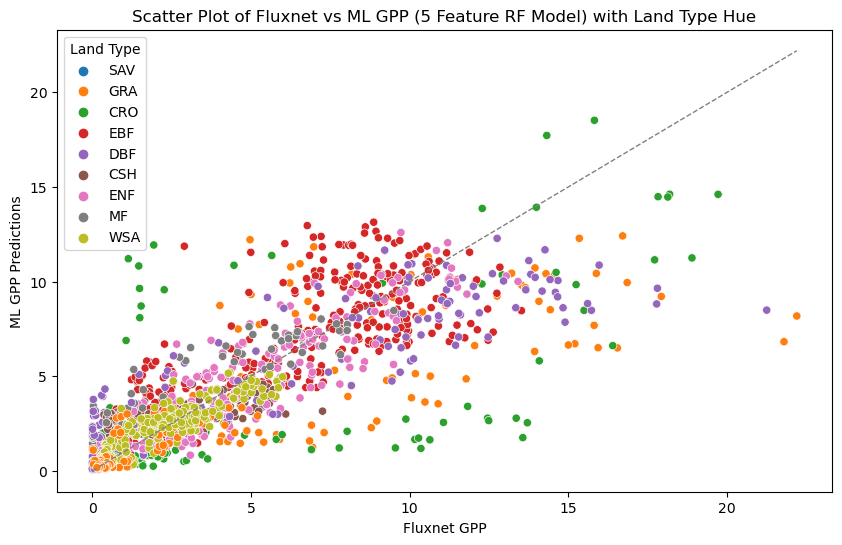

In [154]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rf5_valid, x='GPP', y='Preds', hue='LandType', palette='tab10')

max_val = max(rf5_valid['GPP'].max(), rf5_valid['Preds'].max())
min_val = min(rf5_valid['GPP'].min(), rf5_valid['Preds'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1)

plt.xlabel('Fluxnet GPP')
plt.ylabel('ML GPP Predictions')
plt.title('Scatter Plot of Fluxnet vs ML GPP (5 Feature RF Model) with Land Type Hue')
plt.legend(title='Land Type')
plt.show()

Seasonality plot

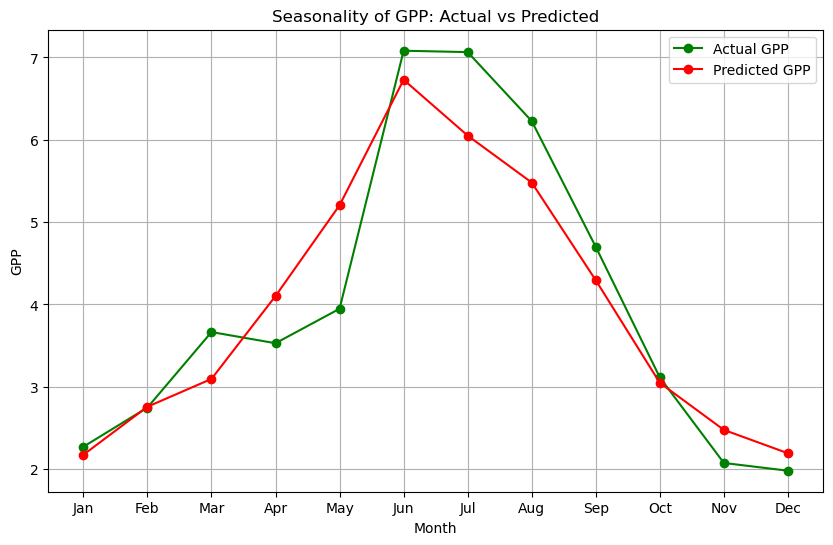

In [157]:
rf5_valid = rf5_valid.merge(valid_y['Date'], left_index=True, right_index=True, how='left')

rf5_valid['Date'] = pd.to_datetime(rf5_valid['Date'])
rf5_valid['Month'] = rf5_valid['Date'].dt.month

monthly_gpp = rf5_valid.groupby('Month').agg({
    'GPP': 'mean',
    'Preds': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_gpp['Month'], monthly_gpp['GPP'], marker='o', label='Actual GPP', color='green')
plt.plot(monthly_gpp['Month'], monthly_gpp['Preds'], marker='o', label='Predicted GPP', color='red')
plt.title('Seasonality of GPP: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('GPP')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

Per land type evaluation

In [136]:
grouped = rf5_valid.groupby('LandType')

In [128]:
#from scipy.stats import boxcox

In [131]:
# Calculate metrics for each land type
#metrics = []

#for name, group in grouped:
#    actuals = group['GPP'].values
#    predictions = group['Preds'].values
    
#    if name == 'SAV':
        # Option 1: Square root transformation
        #transformed_actuals = np.sqrt(actuals)
        #transformed_predictions = np.sqrt(predictions)
        
        # Option 2: Box-Cox transformation
        #actuals_positive = actuals + 1e-6
        #predictions_positive = predictions + 1e-6
#        transformed_actuals, _ = boxcox(actuals)
#        transformed_predictions, _ = boxcox(predictions)

        # Calculate metrics on transformed data
#        r2 = r2_score(transformed_actuals, transformed_predictions)
#        mae = mean_absolute_error(transformed_actuals, transformed_predictions)
#        rmse = np.sqrt(mean_squared_error(transformed_actuals, transformed_predictions))
#        mean_bias = np.mean(transformed_predictions - transformed_actuals)
#    else:
        # Calculate metrics on untransformed data
#        if len(actuals) > 1 and np.var(actuals) > 0:
#            r2 = r2_score(actuals, predictions)
#        else:
#            r2 = np.nan  # or another placeholder value, like 0 or -1
        
#        mae = mean_absolute_error(actuals, predictions)
#        rmse = np.sqrt(mean_squared_error(actuals, predictions))
#        mean_bias = np.mean(predictions - actuals)
    
#    metrics.append({
#        'LandType': name,
#        'R2': r2,
#        'MAE': mae,
#        'RMSE': rmse,
#        'Bias': mean_bias
#    })

#land_type_metrics = pd.DataFrame(metrics)

In [148]:
metrics = []

for name, group in grouped:
    actuals = group['GPP'].values
    predictions = group['Preds'].values
    
    # Calculate metrics 
    if len(actuals) > 1 and np.var(actuals) > 0:
        r2 = r2_score(actuals, predictions)
    else:
        r2 = np.nan
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mean_bias = np.mean(predictions - actuals)
    
    metrics.append({
        'LandType': name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Bias': mean_bias,
        'Quantity' : len(group)
    })

land_type_metrics = pd.DataFrame(metrics)

In [149]:
# Exclude 'SAV' from the overall R2 calculation due to low variance impacting R2 score
r2_metrics = land_type_metrics[land_type_metrics['LandType'] != 'SAV']

overall_r2_std = r2_metrics['R2'].std()

# Calculate the overall std dev for other metrics 
overall_mae_std = land_type_metrics['MAE'].std()

overall_rmse_std = land_type_metrics['RMSE'].std()

overall_bias_std = land_type_metrics['Bias'].std()

overall_metrics = pd.DataFrame({
    'LandType': ['Mean', 'Std Dev'],
    'R2': [r2_rf5, overall_r2_std],
    'MAE': [mae_rf5, overall_mae_std],
    'RMSE': [rmse_rf5, overall_rmse_std],
    'Bias': [mean_bias_rf5, overall_bias_std]
})

# Combine the land type metrics with the overall metrics
final_df = pd.concat([land_type_metrics, overall_metrics], ignore_index=True)
final_df

LandType         R2       MAE      RMSE      Bias  Quantity
0       CRO   0.310020  3.436424  4.755834 -1.281113     110.0
1       CSH   0.380868  1.209005  1.426044  0.237136     120.0
2       DBF   0.768245  1.803894  2.619143 -0.655807     200.0
3       EBF   0.630761  1.591369  2.113781  0.559311     360.0
4       ENF   0.833714  0.969868  1.331847 -0.098725     230.0
5       GRA   0.588298  1.913959  3.130809 -1.100595     223.0
6        MF   0.696086  1.137614  1.475465  0.940390      85.0
7       SAV -15.227617  0.961555  1.017892  0.956209      82.0
8       WSA   0.809926  0.534883  0.675215  0.031606     233.0
9      Mean   0.680010  1.464890  2.298819 -0.088076       NaN
10  Std Dev   0.194012  0.847041  1.275102  0.824795       NaN

RF 6 Column

In [23]:
x_rf6 = valid_x[['LAI_HighVeg', 'Evap', 'DewTemp2m', 'Albedo', 'Elevation', 'VolSoilWaterL4']]
y = valid_x['GPP_DT_VUT_REF']

In [24]:
xrf6_train, xrf6_test, yrf6_train, yrf6_test = train_test_split(x_rf6, y, test_size=0.2, random_state=31)

In [39]:
params = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80],
    'min_samples_split': list(np.arange(2, 20, 1)),
    'min_samples_leaf': list(np.arange(1, 10, 1)),
    'max_features': ['sqrt', 'log2'] + list(np.arange(1, 7, 1)),
    'bootstrap': [True, False]
}

RF = RandomForestRegressor()
    
# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RF,
    param_distributions=params,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=5, 
    verbose=0,
    random_state=31,
    n_jobs=-1  
)

random_search.fit(xrf6_train, yrf6_train)

best_params = random_search.best_params_
best_params

{'n_estimators': 475,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': 30,
 'bootstrap': True}

In [40]:
rf6 = RandomForestRegressor(
    n_estimators = best_params['n_estimators'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    bootstrap = best_params['bootstrap'],
    random_state = 31
)

In [41]:
# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=31)

rmse_list = []
mae_list = []
r2_list = []
mean_bias_list = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(xrf6_train), 1): 
    fold_start = time.time() 
    
    x_train, x_test = xrf6_train.iloc[train_index], xrf6_train.iloc[test_index]
    y_train, y_test = yrf6_train.iloc[train_index], yrf6_train.iloc[test_index]
    
    rf6.fit(x_train, y_train)
    
    y_pred = rf6.predict(x_test)
    
    # Calculate metrics
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    mean_bias = round(np.mean(y_pred - y_test), 4)
    
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mean_bias_list.append(mean_bias)
    
    fold_end = time.time()  
    fold_time = round(fold_end - fold_start, 2)  # Calculate time taken per fold
    print(f"Fold {fold} complete. Time taken = {fold_time} seconds")

Fold 1 complete. Time taken = 10.47 seconds
Fold 2 complete. Time taken = 10.61 seconds
Fold 3 complete. Time taken = 10.93 seconds
Fold 4 complete. Time taken = 10.48 seconds
Fold 5 complete. Time taken = 10.74 seconds
Fold 6 complete. Time taken = 10.75 seconds
Fold 7 complete. Time taken = 10.42 seconds
Fold 8 complete. Time taken = 11.03 seconds
Fold 9 complete. Time taken = 10.88 seconds
Fold 10 complete. Time taken = 11.07 seconds


In [42]:
# Calculate average and standard deviation of the metrics
rmse_avg = round(np.mean(rmse_list),4)
rmse_std = round(np.std(rmse_list),4)
mae_avg = round(np.mean(mae_list),4)
mae_std = round(np.std(mae_list),4)
r2_avg = round(np.mean(r2_list),4)
r2_std = round(np.std(r2_list),4)
mean_bias_avg = round(np.mean(mean_bias_list),4)
mean_bias_std = round(np.std(mean_bias_list),4)

metrics_rf6 = pd.DataFrame({
    'RMSE': rmse_list + [rmse_avg, rmse_std],
    'MAE': mae_list + [mae_avg, mae_std],
    'R²': r2_list + [r2_avg, r2_std],
    'Mean Bias': mean_bias_list + [mean_bias_avg, mean_bias_std]
})

metrics_rf6.index = [f'Fold {i+1}' for i in range(10)] + ['Mean', 'Std']
metrics_rf6

RMSE     MAE      R²  Mean Bias
Fold 1   1.2988  0.9066  0.8679     0.0450
Fold 2   1.5650  0.9258  0.8469    -0.2150
Fold 3   1.3460  0.8701  0.8513     0.1552
Fold 4   1.5620  0.9519  0.8433    -0.0493
Fold 5   1.2183  0.8021  0.8750     0.1243
Fold 6   1.5327  0.9872  0.8360     0.0669
Fold 7   1.4397  0.7933  0.8544     0.0477
Fold 8   1.7513  1.0418  0.8196    -0.0571
Fold 9   1.4478  0.8714  0.8591     0.0029
Fold 10  1.5410  0.9436  0.8459     0.0286
Mean     1.4703  0.9094  0.8499     0.0149
Std      0.1466  0.0740  0.0150     0.0994

In [43]:
rf6.fit(x_rf6,y)

RandomForestRegressor(max_depth=30, max_features=2, n_estimators=475,
                      random_state=42)

In [44]:
rf6_valid = valid_y[['LAI_HighVeg', 'Evap', 'DewTemp2m', 'Albedo', 'Elevation', 'VolSoilWaterL4']]
y_valid = valid_y['GPP_DT_VUT_REF']

In [45]:
rf6_preds = rf6.predict(rf6_valid)

# Calculate metrics
rmse_rf6 = np.sqrt(mean_squared_error(y_valid, rf6_preds))
mae_rf6 = mean_absolute_error(y_valid, rf6_preds)
r2_rf6 = r2_score(y_valid, rf6_preds)

# Calculate mean bias
mean_bias_rf6 = np.mean(rf6_preds - y_valid)

# Print the evaluation metrics
print('Results for Best 6 Feature RF Model:')
print(f'RMSE: {round(rmse_rf6,4)}')
print(f'MAE: {round(mae_rf6,4)}')
print(f'R²: {round(r2_rf6,4)}')
print(f'Mean Bias: {round(mean_bias_rf6,4)}')

Results for Best 6 Feature RF Model:
RMSE: 2.1891
MAE: 1.4531
R²: 0.7098
Mean Bias: -0.1331


In [46]:
rf6_valid['GPP'] = y_valid
rf6_valid['Preds'] = rf6_preds

C:\Users\joearthur\AppData\Local\Temp\ipykernel_10288\4099089878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf6_valid['GPP'] = y_valid
C:\Users\joearthur\AppData\Local\Temp\ipykernel_10288\4099089878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf6_valid['Preds'] = rf6_preds


In [117]:
rf6_valid = rf6_valid.merge(valid_y[['LandType','Site']], left_index=True, right_index=True, how='left')
rf6_sav_enf = rf6_valid[(rf6_valid['LandType'] == 'SAV') | (rf6_valid['LandType'] == 'ENF')]

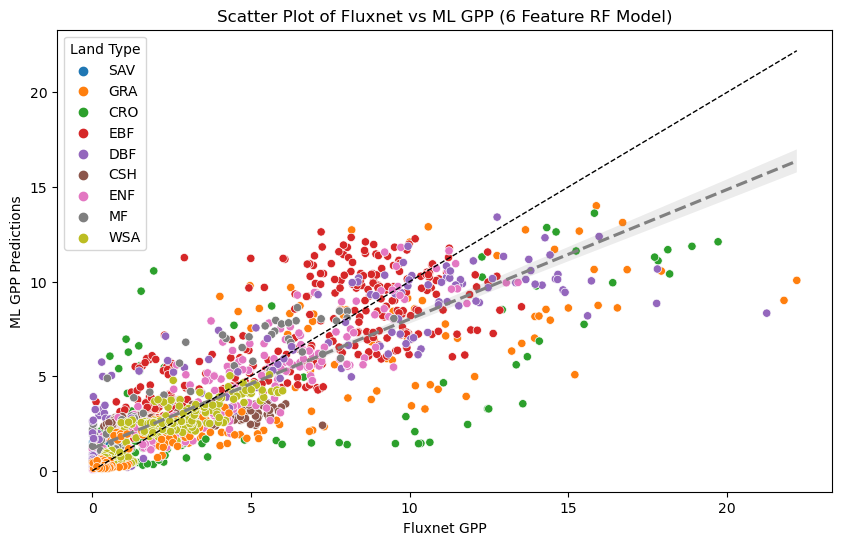

In [122]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rf6_valid, x='GPP', y='Preds', hue='LandType', palette='tab10')

# Add line of best fit
sns.regplot(data=rf6_valid, x='GPP', y='Preds', scatter=False, color='gray', line_kws={"linestyle": "--"})

# Add (y = x)
max_val = max(rf6_valid['GPP'].max(), rf6_valid['Preds'].max())
min_val = min(rf6_valid['GPP'].min(), rf6_valid['Preds'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

plt.xlabel('Fluxnet GPP')
plt.ylabel('ML GPP Predictions')
plt.title('Scatter Plot of Fluxnet vs ML GPP (6 Feature RF Model)')
plt.legend(title='Land Type')
plt.show()

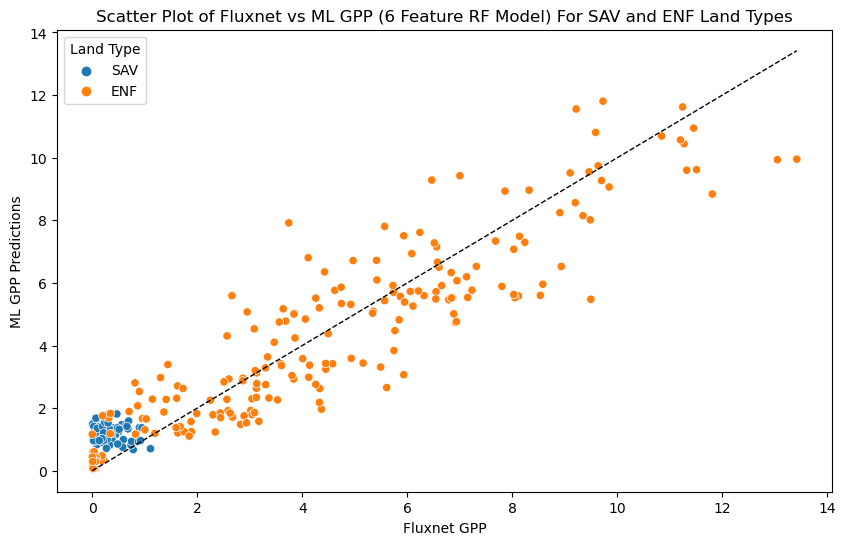

In [118]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rf6_sav_enf, x='GPP', y='Preds', hue='LandType', palette='tab10')

# Add a line of best fit across all points
#sns.regplot(data=rf6_sav_csh, x='GPP', y='Preds', scatter=False, color='gray', line_kws={"linestyle": "--"})

max_val = max(rf6_sav_enf['GPP'].max(), rf6_sav_enf['Preds'].max())
min_val = min(rf6_sav_enf['GPP'].min(), rf6_sav_enf['Preds'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Fluxnet GPP')
plt.ylabel('ML GPP Predictions')
plt.title('Scatter Plot of Fluxnet vs ML GPP (6 Feature RF Model) For SAV and ENF Land Types')
plt.legend(title='Land Type')
plt.show()

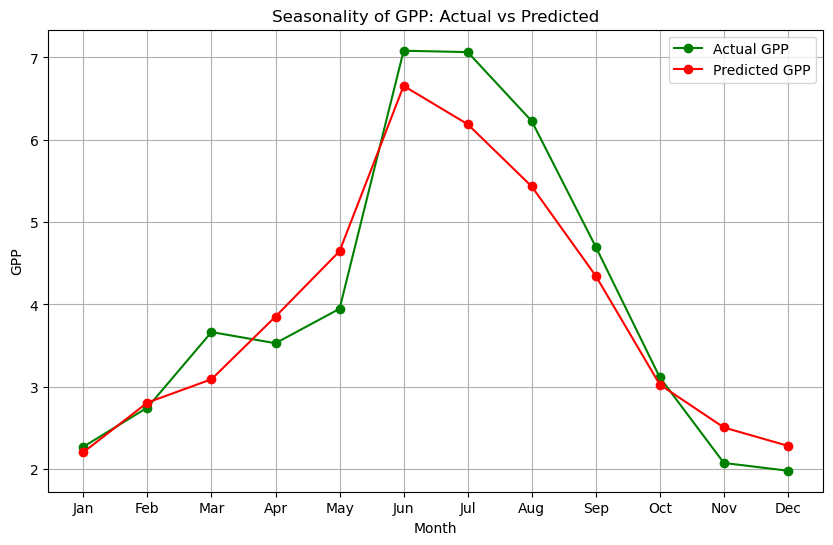

In [49]:
rf6_valid = rf6_valid.merge(valid_y['Date'], left_index=True, right_index=True, how='left')

rf6_valid['Date'] = pd.to_datetime(rf6_valid['Date'])
rf6_valid['Month'] = rf6_valid['Date'].dt.month

monthly_gpp = rf6_valid.groupby('Month').agg({
    'GPP': 'mean',
    'Preds': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_gpp['Month'], monthly_gpp['GPP'], marker='o', label='Actual GPP', color='green')
plt.plot(monthly_gpp['Month'], monthly_gpp['Preds'], marker='o', label='Predicted GPP', color='red')
plt.title('Seasonality of GPP: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('GPP')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

In [125]:
grouped = rf6_valid.groupby('LandType')

metrics = []
variances = []

for name, group in grouped:
    actuals = group['GPP'].values
    predictions = group['Preds'].values
    
    # Calculate metrics 
    if len(actuals) > 1 and np.var(actuals) > 0:
        r2 = r2_score(actuals, predictions)
    else:
        r2 = np.nan
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mean_bias = np.mean(predictions - actuals)
    
    variance_actuals = np.var(actuals)
    variances.append({
        'LandType': name,
        'Var': variance_actuals
    })
    
    metrics.append({
        'LandType': name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Bias': mean_bias,
        'Quantity' : len(group)
    })

land_type_metrics = pd.DataFrame(metrics)

In [126]:
variances

[{'LandType': 'CRO', 'Var': 32.780612101316194},
 {'LandType': 'CSH', 'Var': 3.284602388156375},
 {'LandType': 'DBF', 'Var': 29.59985179383385},
 {'LandType': 'EBF', 'Var': 12.100749541447211},
 {'LandType': 'ENF', 'Var': 10.667247487171627},
 {'LandType': 'GRA', 'Var': 23.80840545810439},
 {'LandType': 'MF', 'Var': 7.163198199485384},
 {'LandType': 'SAV', 'Var': 0.06384817116396152},
 {'LandType': 'WSA', 'Var': 2.39861333104195}]

In [128]:
grouped_site = rf6_valid.groupby(['LandType','Site'])
vars_site = []
for name, group in grouped_site:
    actuals = group['GPP'].values
    predictions = group['Preds'].values
    
    variance_actuals = np.var(actuals)
    vars_site.append({
        'LandType': name,
        'Var': variance_actuals
    })
    
vars_site

[{'LandType': ('CRO', 'DE_RUS'), 'Var': 32.780612101316194},
 {'LandType': ('CSH', 'IT_NOE'), 'Var': 3.284602388156375},
 {'LandType': ('DBF', 'IT_COL'), 'Var': 27.21974508276494},
 {'LandType': ('DBF', 'US_WCR'), 'Var': 32.94771396726},
 {'LandType': ('EBF', 'FR_PUE'), 'Var': 0.4650044801156196},
 {'LandType': ('EBF', 'GF_GUY'), 'Var': 3.04922641385416},
 {'LandType': ('EBF', 'GH_ANK'), 'Var': 5.461497052179},
 {'LandType': ('ENF', 'NL_LOO'), 'Var': 10.381044413934497},
 {'LandType': ('ENF', 'US_NR1'), 'Var': 9.175526223645631},
 {'LandType': ('GRA', 'CH_CHA'), 'Var': 24.623896717864643},
 {'LandType': ('GRA', 'US_WKG'), 'Var': 1.7944970461644802},
 {'LandType': ('MF', 'US_PFA'), 'Var': 7.163198199485384},
 {'LandType': ('SAV', 'AU_CPR'), 'Var': 0.06384817116396152},
 {'LandType': ('WSA', 'AU_GIN'), 'Var': 1.4927818337207706},
 {'LandType': ('WSA', 'US_SRM'), 'Var': 1.02834139207645}]

In [98]:
r2_metrics = land_type_metrics[(land_type_metrics['LandType'] != 'SAV') & 
                               (land_type_metrics['LandType'] != 'CSH')]

overall_r2_std = r2_metrics['R2'].std()

# Calculate the overall std dev for other metrics 
overall_mae_std = land_type_metrics['MAE'].std()

overall_rmse_std = land_type_metrics['RMSE'].std()

overall_bias_std = land_type_metrics['Bias'].std()

# Create a DataFrame for the overall mean and standard deviation
overall_metrics = pd.DataFrame({
    'LandType': ['Mean', 'Std Dev'],
    'R2': [r2_rf6, overall_r2_std],
    'MAE': [mae_rf6, overall_mae_std],
    'RMSE': [rmse_rf6, overall_rmse_std],
    'Bias': [mean_bias_rf6, overall_bias_std]
})

final_df = pd.concat([land_type_metrics, overall_metrics], ignore_index=True)
final_df

LandType         R2       MAE      RMSE      Bias  Quantity
0       CRO   0.432002  3.149510  4.315010 -1.517281     110.0
1       CSH   0.191892  1.404787  1.629206 -0.092754     120.0
2       DBF   0.805536  1.652481  2.399191 -0.300482     200.0
3       EBF   0.614940  1.699456  2.158591  0.504374     360.0
4       ENF   0.845842  0.968561  1.282356 -0.188653     230.0
5       GRA   0.639524  1.826021  2.929567 -1.221976     223.0
6        MF   0.679674  1.215234  1.514780  1.032180      85.0
7       SAV -13.854399  0.900309  0.973872  0.887803      82.0
8       WSA   0.797518  0.528108  0.696904 -0.028814     233.0
9      Mean   0.709832  1.453111  2.189077 -0.133063       NaN
10  Std Dev   0.143768  0.755340  1.120585  0.861936       NaN

XG 5 Column

In [69]:
x_xg5 = valid_x[['LAI_HighVeg', 'Longitude', 'Albedo', 'VPD', 'VolSoilWaterL4']]
y = valid_x['GPP_DT_VUT_REF']

In [77]:
scaler = StandardScaler()

x_xg5s = scaler.fit_transform(x_xg5)
x_xg5s = pd.DataFrame(x_xg5s, columns=x_xg5.columns)

In [72]:
xxg5_train, xxg5_test, yxg5_train, yxg5_test = train_test_split(x_xg5, y, test_size=0.2, random_state=31)

In [89]:
# Scaled version
xxg5s_train, xxg5s_test, yxg5s_train, yxg5s_test = train_test_split(x_xg5s, y, test_size=0.2, random_state=31)

In [181]:
# Define the parameter grid
params = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'gamma': np.linspace(0, 0.5, 10),
    'min_child_weight': np.arange(1, 10, 1),
    'reg_alpha': np.logspace(-3, 1, 10),
    'reg_lambda': np.logspace(-3, 1, 10)
}

XG = xgb.XGBRegressor()

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XG,
    param_distributions=params,
    n_iter=40,  
    scoring='neg_mean_squared_error', 
    cv=5,
    verbose=0,
    random_state=31,
    n_jobs=-1  
)

random_search.fit(xxg5_train, yxg5_train)

best_params = random_search.best_params_
best_params

{'subsample': 1.0,
 'reg_lambda': 0.0027825594022071257,
 'reg_alpha': 0.05994842503189409,
 'n_estimators': 350,
 'min_child_weight': 5,
 'max_depth': 11,
 'learning_rate': 0.07105263157894737,
 'gamma': 0.2222222222222222,
 'colsample_bytree': 0.9444444444444444}

In [90]:
# Scaled version
params = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'gamma': np.linspace(0, 0.5, 10),
    'min_child_weight': np.arange(1, 10, 1),
    'reg_alpha': np.logspace(-3, 1, 10),
    'reg_lambda': np.logspace(-3, 1, 10)
}

XG = xgb.XGBRegressor()

random_search = RandomizedSearchCV(
    estimator=XG,
    param_distributions=params,
    n_iter=40,  
    scoring='neg_mean_squared_error', 
    cv=5,  
    verbose=0,
    random_state=31,
    n_jobs=-1  
)

random_search.fit(xxg5s_train, yxg5s_train)

best_params_s = random_search.best_params_
best_params_s

{'subsample': 1.0,
 'reg_lambda': 0.0027825594022071257,
 'reg_alpha': 0.05994842503189409,
 'n_estimators': 350,
 'min_child_weight': 5,
 'max_depth': 11,
 'learning_rate': 0.07105263157894737,
 'gamma': 0.2222222222222222,
 'colsample_bytree': 0.9444444444444444}

In [182]:
xg5 = xgb.XGBRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    n_estimators = best_params['n_estimators'],
    min_child_weight = best_params['min_child_weight'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    gamma = best_params['gamma'],
    colsample_bytree = best_params['colsample_bytree'],
    random_state = 31
)

In [91]:
# Scaled version
xg5s = xgb.XGBRegressor(
    subsample = best_params_s['subsample'],
    reg_lambda = best_params_s['reg_lambda'],
    reg_alpha = best_params_s['reg_alpha'],
    n_estimators = best_params_s['n_estimators'],
    min_child_weight = best_params_s['min_child_weight'],
    max_depth = best_params_s['max_depth'],
    learning_rate = best_params_s['learning_rate'],
    gamma = best_params_s['gamma'],
    colsample_bytree = best_params_s['colsample_bytree'],
    random_state = 31
)

In [183]:
# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=31)

rmse_list = []
mae_list = []
r2_list = []
mean_bias_list = []

for fold, (train_index, test_index) in enumerate(kf.split(xxg5_train), 1): 
    fold_start = time.time() 
    
    x_train, x_test = xxg5_train.iloc[train_index], xxg5_train.iloc[test_index]
    y_train, y_test = yxg5_train.iloc[train_index], yxg5_train.iloc[test_index]
    
    xg5.fit(x_train, y_train)
    
    y_pred = xg5.predict(x_test)

    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    mean_bias = round(np.mean(y_pred - y_test), 4)
    
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mean_bias_list.append(mean_bias)
    
    fold_end = time.time()  
    fold_time = round(fold_end - fold_start, 2)  # Calculate time taken per fold
    print(f"Fold {fold} complete. Time taken = {fold_time} seconds")

Fold 1 complete. Time taken = 0.44 seconds
Fold 2 complete. Time taken = 0.41 seconds
Fold 3 complete. Time taken = 0.39 seconds
Fold 4 complete. Time taken = 0.4 seconds
Fold 5 complete. Time taken = 0.42 seconds
Fold 6 complete. Time taken = 0.4 seconds
Fold 7 complete. Time taken = 0.4 seconds
Fold 8 complete. Time taken = 0.41 seconds
Fold 9 complete. Time taken = 0.44 seconds
Fold 10 complete. Time taken = 0.36 seconds


In [92]:
# Scaled version
kf = KFold(n_splits=10, shuffle=True, random_state=31)

rmse_list = []
mae_list = []
r2_list = []
mean_bias_list = []

for fold, (train_index, test_index) in enumerate(kf.split(xxg5s_train), 1): 
    fold_start = time.time() 
    
    x_train, x_test = xxg5s_train.iloc[train_index], xxg5s_train.iloc[test_index]
    y_train, y_test = yxg5s_train.iloc[train_index], yxg5s_train.iloc[test_index]
    
    xg5s.fit(x_train, y_train)
    
    y_pred = xg5s.predict(x_test)

    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    mean_bias = round(np.mean(y_pred - y_test), 4)
    
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mean_bias_list.append(mean_bias)
    
    fold_end = time.time()  
    fold_time = round(fold_end - fold_start, 2)  # Calculate time taken per fold
    print(f"Fold {fold} complete. Time taken = {fold_time} seconds")

Fold 1 complete. Time taken = 0.88 seconds
Fold 2 complete. Time taken = 0.81 seconds
Fold 3 complete. Time taken = 1.01 seconds
Fold 4 complete. Time taken = 0.81 seconds
Fold 5 complete. Time taken = 0.83 seconds
Fold 6 complete. Time taken = 0.8 seconds
Fold 7 complete. Time taken = 0.86 seconds
Fold 8 complete. Time taken = 0.82 seconds
Fold 9 complete. Time taken = 1.13 seconds
Fold 10 complete. Time taken = 1.0 seconds


In [184]:
# Calculate average and standard deviation of the metrics
rmse_avg = round(np.mean(rmse_list),4)
rmse_std = round(np.std(rmse_list),4)
mae_avg = round(np.mean(mae_list),4)
mae_std = round(np.std(mae_list),4)
r2_avg = round(np.mean(r2_list),4)
r2_std = round(np.std(r2_list),4)
mean_bias_avg = round(np.mean(mean_bias_list),4)
mean_bias_std = round(np.std(mean_bias_list),4)

metrics_xg5 = pd.DataFrame({
    'RMSE': rmse_list + [rmse_avg, rmse_std],
    'MAE': mae_list + [mae_avg, mae_std],
    'R²': r2_list + [r2_avg, r2_std],
    'Mean Bias': mean_bias_list + [mean_bias_avg, mean_bias_std]
})

metrics_xg5.index = [f'Fold {i+1}' for i in range(10)] + ['Mean', 'Std']
metrics_xg5

RMSE     MAE      R²  Mean Bias
Fold 1   1.3341  0.8732  0.8606     0.0430
Fold 2   1.4980  0.8993  0.8598    -0.1780
Fold 3   1.2617  0.7773  0.8694     0.1385
Fold 4   1.5051  0.9038  0.8545    -0.0140
Fold 5   1.1303  0.7474  0.8924     0.0892
Fold 6   1.3689  0.8945  0.8692     0.0766
Fold 7   1.3906  0.8229  0.8642     0.0806
Fold 8   1.7298  0.9994  0.8240    -0.0644
Fold 9   1.2559  0.8148  0.8940     0.0245
Fold 10  1.4082  0.8544  0.8713     0.0150
Mean     1.3883  0.8587  0.8659     0.0211
Std      0.1569  0.0687  0.0187     0.0859

In [93]:
# Scaled version
rmse_avg = round(np.mean(rmse_list),4)
rmse_std = round(np.std(rmse_list),4)
mae_avg = round(np.mean(mae_list),4)
mae_std = round(np.std(mae_list),4)
r2_avg = round(np.mean(r2_list),4)
r2_std = round(np.std(r2_list),4)
mean_bias_avg = round(np.mean(mean_bias_list),4)
mean_bias_std = round(np.std(mean_bias_list),4)

metrics_xg5s = pd.DataFrame({
    'RMSE': rmse_list + [rmse_avg, rmse_std],
    'MAE': mae_list + [mae_avg, mae_std],
    'R²': r2_list + [r2_avg, r2_std],
    'Mean Bias': mean_bias_list + [mean_bias_avg, mean_bias_std]
})

metrics_xg5s.index = [f'Fold {i+1}' for i in range(10)] + ['Mean', 'Std']
metrics_xg5s

RMSE     MAE      R²  Mean Bias
Fold 1   1.3406  0.8717  0.8592     0.0344
Fold 2   1.4980  0.8993  0.8598    -0.1780
Fold 3   1.2708  0.7807  0.8675     0.1264
Fold 4   1.4997  0.9061  0.8556    -0.0143
Fold 5   1.1346  0.7508  0.8916     0.0807
Fold 6   1.3612  0.8894  0.8707     0.0630
Fold 7   1.3564  0.8041  0.8708     0.0727
Fold 8   1.7821  1.0167  0.8132    -0.0717
Fold 9   1.2263  0.7966  0.8989     0.0244
Fold 10  1.4061  0.8436  0.8717     0.0092
Mean     1.3876  0.8559  0.8659     0.0147
Std      0.1698  0.0739  0.0219     0.0828

In [186]:
xg5.fit(x_xg5,y)

xg5_valid = valid_y[['LAI_HighVeg', 'Longitude', 'Albedo', 'VPD', 'VolSoilWaterL4']]
y_valid = valid_y['GPP_DT_VUT_REF']

xg5_preds = xg5.predict(xg5_valid)

In [94]:
# Scaled version
xg5s.fit(x_xg5s,y)

xg5_valid = valid_y[['LAI_HighVeg', 'Longitude', 'Albedo', 'VPD', 'VolSoilWaterL4']]
y_valid = valid_y['GPP_DT_VUT_REF']

x_xg5vs = scaler.fit_transform(xg5_valid)
x_xg5vs = pd.DataFrame(x_xg5vs, columns=xg5_valid.columns)

xg5s_preds = xg5s.predict(x_xg5vs)

In [187]:
rmse_xg5 = np.sqrt(mean_squared_error(y_valid, xg5_preds))
mae_xg5 = mean_absolute_error(y_valid, xg5_preds)
r2_xg5 = r2_score(y_valid, xg5_preds)

mean_bias_xg5 = np.mean(xg5_preds - y_valid)

print('Results for Best 5 Feature XGB Model:')
print(f'RMSE: {round(rmse_xg5,4)}')
print(f'MAE: {round(mae_xg5,4)}')
print(f'R²: {round(r2_xg5,4)}')
print(f'Mean Bias: {round(mean_bias_xg5,4)}')

Results for Best 6 Feature RF Model:
RMSE: 2.5392
MAE: 1.6663
R²: 0.6096
Mean Bias: -0.1832


In [95]:
# Scaled version
rmse_xg5s = np.sqrt(mean_squared_error(y_valid, xg5s_preds))
mae_xg5s = mean_absolute_error(y_valid, xg5s_preds)
r2_xg5s = r2_score(y_valid, xg5s_preds)

mean_bias_xg5s = np.mean(xg5s_preds - y_valid)

print('Results for Best 5 Feature XGB Scaled Model:')
print(f'RMSE: {round(rmse_xg5s,4)}')
print(f'MAE: {round(mae_xg5s,4)}')
print(f'R²: {round(r2_xg5s,4)}')
print(f'Mean Bias: {round(mean_bias_xg5s,4)}')

Results for Best 5 Feature XGB Scaled Model:
RMSE: 2.6048
MAE: 1.8617
R²: 0.5891
Mean Bias: -0.0524


In [189]:
xg5_valid['GPP'] = y_valid
xg5_valid['Preds'] = xg5_preds

xg5_valid = xg5_valid.merge(valid_y[['LandType','Site']], left_index=True, right_index=True, how='left')

C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\2811069090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xg5_valid['GPP'] = y_valid
C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\2811069090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xg5_valid['Preds'] = xg5_preds


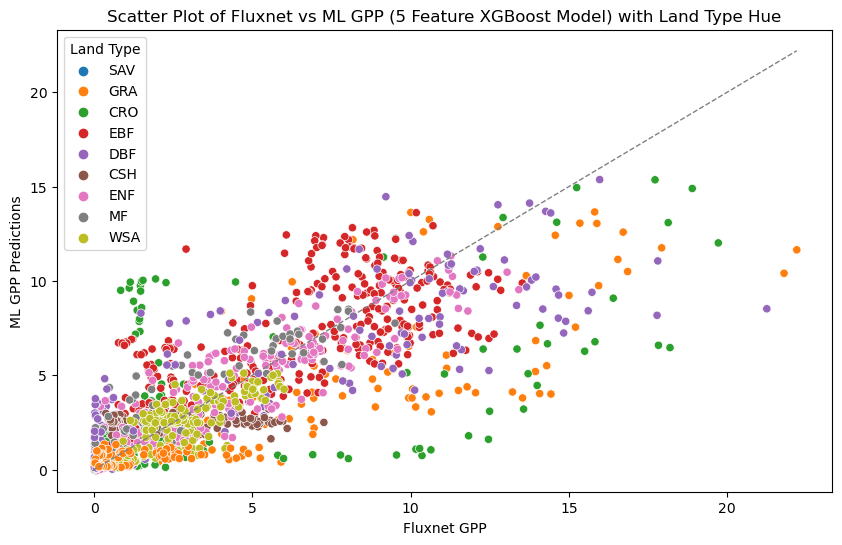

In [190]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=xg5_valid, x='GPP', y='Preds', hue='LandType', palette='tab10')

max_val = max(xg5_valid['GPP'].max(), xg5_valid['Preds'].max())
min_val = min(xg5_valid['GPP'].min(), xg5_valid['Preds'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1)

plt.xlabel('Fluxnet GPP')
plt.ylabel('ML GPP Predictions')
plt.title('Scatter Plot of Fluxnet vs ML GPP (5 Feature XGBoost Model)')
plt.legend(title='Land Type')
plt.show()

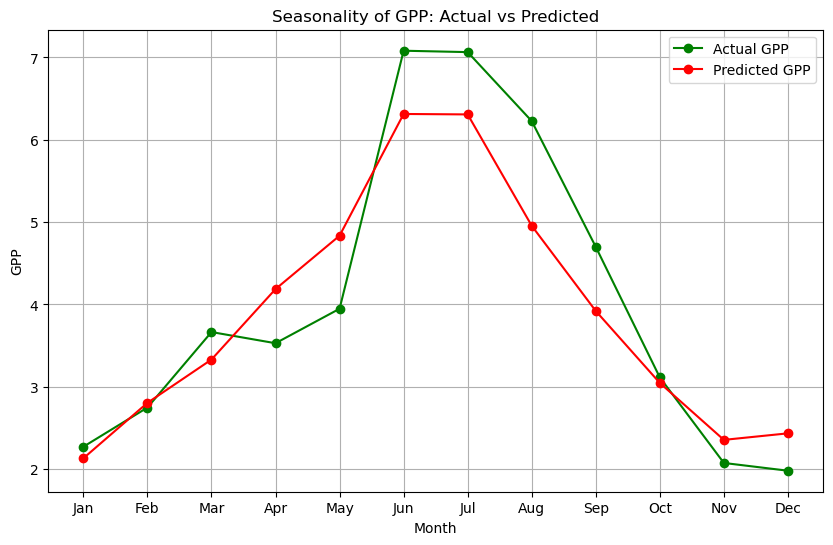

In [191]:
xg5_valid = xg5_valid.merge(valid_y['Date'], left_index=True, right_index=True, how='left')

xg5_valid['Date'] = pd.to_datetime(xg5_valid['Date'])
xg5_valid['Month'] = xg5_valid['Date'].dt.month

monthly_gpp = xg5_valid.groupby('Month').agg({
    'GPP': 'mean',
    'Preds': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_gpp['Month'], monthly_gpp['GPP'], marker='o', label='Actual GPP', color='green')
plt.plot(monthly_gpp['Month'], monthly_gpp['Preds'], marker='o', label='Predicted GPP', color='red')
plt.title('Seasonality of GPP: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('GPP')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

In [192]:
grouped = xg5_valid.groupby('LandType')

metrics = []

for name, group in grouped:
    actuals = group['GPP'].values
    predictions = group['Preds'].values
    
    # Calculate metrics 
    if len(actuals) > 1 and np.var(actuals) > 0:
        r2 = r2_score(actuals, predictions)
    else:
        r2 = np.nan
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mean_bias = np.mean(predictions - actuals)
    
    metrics.append({
        'LandType': name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Bias': mean_bias,
        'Quantity' : len(group)
    })

land_type_metrics = pd.DataFrame(metrics)

In [193]:
r2_metrics = land_type_metrics[land_type_metrics['LandType'] != 'SAV']

overall_r2_std = r2_metrics['R2'].std()

overall_mae_std = land_type_metrics['MAE'].std()

overall_rmse_std = land_type_metrics['RMSE'].std()

overall_bias_std = land_type_metrics['Bias'].std()

overall_metrics = pd.DataFrame({
    'LandType': ['Mean', 'Std Dev'],
    'R2': [r2_xg5, overall_r2_std],
    'MAE': [mae_xg5, overall_mae_std],
    'RMSE': [rmse_xg5, overall_rmse_std],
    'Bias': [mean_bias_xg5, overall_bias_std]
})

final_df = pd.concat([land_type_metrics, overall_metrics], ignore_index=True)
final_df

LandType         R2       MAE      RMSE      Bias  Quantity
0       CRO   0.119534  4.085209  5.372355 -0.935939     110.0
1       CSH  -0.032171  1.567171  1.841269 -0.215559     120.0
2       DBF   0.724838  1.988959  2.853901 -0.303665     200.0
3       EBF   0.514729  1.858306  2.423250  0.537541     360.0
4       ENF   0.817861  1.034537  1.393886 -0.044026     230.0
5       GRA   0.554499  2.124192  3.256786 -1.696055     223.0
6        MF   0.661393  1.199706  1.557404  0.987398      85.0
7       SAV -12.115246  0.848548  0.915087  0.832078      82.0
8       WSA   0.674612  0.645048  0.883448 -0.295370     233.0
9      Mean   0.609585  1.666285  2.539216 -0.183230       NaN
10  Std Dev   0.302163  1.032358  1.422136  0.851023       NaN

6 Columns

In [194]:
x_xg6 = valid_x[['LAI_HighVeg', 'LAI_LowVeg', 'Longitude', 'DewTemp2m', 'VPD', 'SoilTempL3']]
y = valid_x['GPP_DT_VUT_REF']

In [195]:
xxg6_train, xxg6_test, yxg6_train, yxg6_test = train_test_split(x_xg6, y, test_size=0.2, random_state=31)

In [196]:
# Define the parameter grid for RandomizedSearchCV
params = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'gamma': np.linspace(0, 0.5, 10),
    'min_child_weight': np.arange(1, 10, 1),
    'reg_alpha': np.logspace(-3, 1, 10),
    'reg_lambda': np.logspace(-3, 1, 10)
}

XG = xgb.XGBRegressor()

random_search = RandomizedSearchCV(
    estimator=XG,
    param_distributions=params,
    n_iter=40,  
    scoring='neg_mean_squared_error', 
    cv=5,  
    verbose=0,
    random_state=31,
    n_jobs=-1  
)

random_search.fit(xxg6_train, yxg6_train)

best_params = random_search.best_params_
best_params

{'subsample': 0.6111111111111112,
 'reg_lambda': 1.2915496650148828,
 'reg_alpha': 0.021544346900318832,
 'n_estimators': 350,
 'min_child_weight': 4,
 'max_depth': 14,
 'learning_rate': 0.02526315789473684,
 'gamma': 0.1111111111111111,
 'colsample_bytree': 0.7777777777777778}

In [197]:
xg6 = xgb.XGBRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    n_estimators = best_params['n_estimators'],
    min_child_weight = best_params['min_child_weight'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    gamma = best_params['gamma'],
    colsample_bytree = best_params['colsample_bytree'],
    random_state = 31
)

In [198]:
# 10-fold CV
kf = KFold(n_splits=10, shuffle=True, random_state=31)

rmse_list = []
mae_list = []
r2_list = []
mean_bias_list = []

for fold, (train_index, test_index) in enumerate(kf.split(xxg6_train), 1): 
    fold_start = time.time() 
    
    x_train, x_test = xxg6_train.iloc[train_index], xxg6_train.iloc[test_index]
    y_train, y_test = yxg6_train.iloc[train_index], yxg6_train.iloc[test_index]
    
    xg6.fit(x_train, y_train)
    
    y_pred = xg6.predict(x_test)

    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    mean_bias = round(np.mean(y_pred - y_test), 4)
    
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mean_bias_list.append(mean_bias)
    
    fold_end = time.time()  
    fold_time = round(fold_end - fold_start, 2)  # Calculate time taken per fold
    print(f"Fold {fold} complete. Time taken = {fold_time} seconds")

Fold 1 complete. Time taken = 1.53 seconds
Fold 2 complete. Time taken = 1.6 seconds
Fold 3 complete. Time taken = 1.58 seconds
Fold 4 complete. Time taken = 1.45 seconds
Fold 5 complete. Time taken = 1.46 seconds
Fold 6 complete. Time taken = 1.49 seconds
Fold 7 complete. Time taken = 1.43 seconds
Fold 8 complete. Time taken = 1.38 seconds
Fold 9 complete. Time taken = 1.5 seconds
Fold 10 complete. Time taken = 1.5 seconds


In [199]:
rmse_avg = round(np.mean(rmse_list),4)
rmse_std = round(np.std(rmse_list),4)
mae_avg = round(np.mean(mae_list),4)
mae_std = round(np.std(mae_list),4)
r2_avg = round(np.mean(r2_list),4)
r2_std = round(np.std(r2_list),4)
mean_bias_avg = round(np.mean(mean_bias_list),4)
mean_bias_std = round(np.std(mean_bias_list),4)

metrics_xg6 = pd.DataFrame({
    'RMSE': rmse_list + [rmse_avg, rmse_std],
    'MAE': mae_list + [mae_avg, mae_std],
    'R²': r2_list + [r2_avg, r2_std],
    'Mean Bias': mean_bias_list + [mean_bias_avg, mean_bias_std]
})

metrics_xg6.index = [f'Fold {i+1}' for i in range(10)] + ['Mean', 'Std']
metrics_xg6

RMSE     MAE      R²  Mean Bias
Fold 1   1.4623  0.9628  0.8325    -0.0032
Fold 2   1.6935  0.9820  0.8208    -0.2586
Fold 3   1.4369  0.8981  0.8306     0.1833
Fold 4   1.6884  1.0381  0.8169    -0.0022
Fold 5   1.3903  0.8808  0.8372     0.1499
Fold 6   1.6148  0.9911  0.8180     0.0462
Fold 7   1.6872  0.9409  0.8001    -0.0026
Fold 8   2.0481  1.1728  0.7533    -0.1043
Fold 9   1.5427  0.9651  0.8401    -0.0339
Fold 10  1.6990  1.0556  0.8126    -0.0556
Mean     1.6263  0.9887  0.8162    -0.0081
Std      0.1791  0.0801  0.0240     0.1181

In [200]:
xg6.fit(x_xg6,y)

xg6_valid = valid_y[['LAI_HighVeg', 'LAI_LowVeg', 'Longitude', 'DewTemp2m', 'VPD', 'SoilTempL3']]
y_valid = valid_y['GPP_DT_VUT_REF']

xg6_preds = xg6.predict(xg6_valid)

In [201]:
# Calculate metrics
rmse_xg6 = np.sqrt(mean_squared_error(y_valid, xg6_preds))
mae_xg6 = mean_absolute_error(y_valid, xg6_preds)
r2_xg6 = r2_score(y_valid, xg6_preds)

# Calculate mean bias
mean_bias_xg6 = np.mean(xg6_preds - y_valid)

# Print the evaluation metrics
print('Results for Best 6 Feature XGB Model:')
print(f'RMSE: {round(rmse_xg6,4)}')
print(f'MAE: {round(mae_xg6,4)}')
print(f'R²: {round(r2_xg6,4)}')
print(f'Mean Bias: {round(mean_bias_xg6,4)}')

Results for Best 6 Feature RF Model:
RMSE: 2.2678
MAE: 1.4757
R²: 0.6886
Mean Bias: -0.0771


In [202]:
xg6_valid['GPP'] = y_valid
xg6_valid['Preds'] = xg6_preds

xg6_valid = xg6_valid.merge(valid_y[['LandType','Site']], left_index=True, right_index=True, how='left')

C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\1873203258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xg6_valid['GPP'] = y_valid
C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\1873203258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xg6_valid['Preds'] = xg6_preds


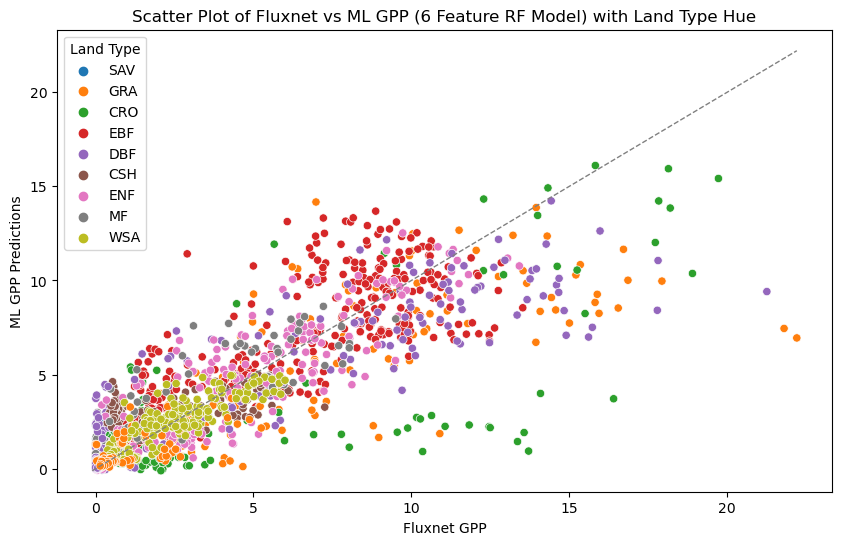

In [203]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=xg6_valid, x='GPP', y='Preds', hue='LandType', palette='tab10')

max_val = max(xg6_valid['GPP'].max(), xg6_valid['Preds'].max())
min_val = min(xg6_valid['GPP'].min(), xg6_valid['Preds'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1)

plt.xlabel('Fluxnet GPP')
plt.ylabel('ML GPP Predictions')
plt.title('Scatter Plot of Fluxnet vs ML GPP (6 Feature XGBoost Model) with Land Type Hue')
plt.legend(title='Land Type')
plt.show()

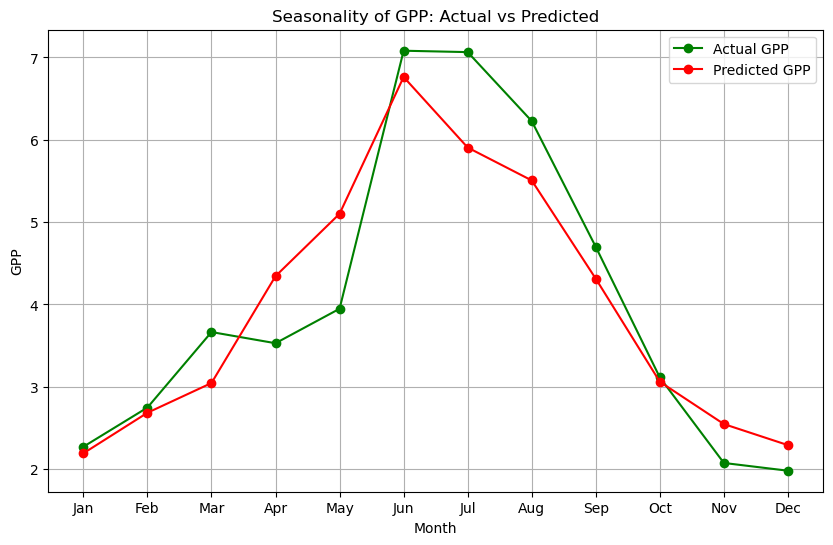

In [204]:
xg6_valid = xg6_valid.merge(valid_y['Date'], left_index=True, right_index=True, how='left')

xg6_valid['Date'] = pd.to_datetime(xg6_valid['Date'])
xg6_valid['Month'] = xg6_valid['Date'].dt.month

monthly_gpp = xg6_valid.groupby('Month').agg({
    'GPP': 'mean',
    'Preds': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_gpp['Month'], monthly_gpp['GPP'], marker='o', label='Actual GPP', color='green')
plt.plot(monthly_gpp['Month'], monthly_gpp['Preds'], marker='o', label='Predicted GPP', color='red')
plt.title('Seasonality of GPP: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('GPP')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

In [205]:
grouped = xg6_valid.groupby('LandType')

metrics = []

for name, group in grouped:
    actuals = group['GPP'].values
    predictions = group['Preds'].values
    
    # Calculate metrics 
    if len(actuals) > 1 and np.var(actuals) > 0:
        r2 = r2_score(actuals, predictions)
    else:
        r2 = np.nan
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mean_bias = np.mean(predictions - actuals)
    
    metrics.append({
        'LandType': name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Bias': mean_bias,
        'Quantity' : len(group)
    })

land_type_metrics = pd.DataFrame(metrics)

In [206]:
r2_metrics = land_type_metrics[land_type_metrics['LandType'] != 'SAV']

overall_r2_std = r2_metrics['R2'].std()

overall_mae_std = land_type_metrics['MAE'].std()

overall_rmse_std = land_type_metrics['RMSE'].std()

overall_bias_std = land_type_metrics['Bias'].std()

overall_metrics = pd.DataFrame({
    'LandType': ['Mean', 'Std Dev'],
    'R2': [r2_xg6, overall_r2_std],
    'MAE': [mae_xg6, overall_mae_std],
    'RMSE': [rmse_xg6, overall_rmse_std],
    'Bias': [mean_bias_xg6, overall_bias_std]
})

final_df = pd.concat([land_type_metrics, overall_metrics], ignore_index=True)
final_df

LandType         R2       MAE      RMSE      Bias  Quantity
0       CRO   0.395051  3.185263  4.453157 -1.827787     110.0
1       CSH   0.191210  1.297066  1.629893  0.467696     120.0
2       DBF   0.762598  1.794134  2.650859 -0.538978     200.0
3       EBF   0.597400  1.659828  2.207205  0.522093     360.0
4       ENF   0.792684  1.084469  1.487110 -0.004171     230.0
5       GRA   0.655988  1.737788  2.861885 -0.996897     223.0
6        MF   0.624846  1.282054  1.639299  0.829694      85.0
7       SAV -20.217615  1.085851  1.163918  1.085851      82.0
8       WSA   0.793103  0.545873  0.704462  0.007396     233.0
9      Mean   0.688594  1.475684  2.267776 -0.077149       NaN
10  Std Dev   0.211696  0.737279  1.121620  0.932802       NaN

LGBM 5 column

In [207]:
x_lg5 = valid_x[['LAI_HighVeg', 'LAI_LowVeg', 'DewTemp2m', 'EvapVegTrans', 'Albedo']]
y = valid_x['GPP_DT_VUT_REF']

In [208]:
xlg5_train, xlg5_test, ylg5_train, ylg5_test = train_test_split(x_lg5, y, test_size=0.2, random_state=31)

In [209]:
LGBM = lgb.LGBMRegressor(verbose=-1)

params = {
    'n_estimators': [50, 100, 150, 200, 250, 300],  
    'max_depth': [-1, 5, 10, 15, 20],  
    'num_leaves': list(np.arange(10, 100, 10)),  
    'min_child_samples': list(np.arange(5, 50, 5)),  
    'learning_rate': np.linspace(0.01, 0.2, 10), 
    'subsample': np.linspace(0.6, 1.0, 5),  
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  
    'boosting_type': ['gbdt', 'dart'],  
    'reg_alpha': [0, 0.01, 0.1, 0.5],  
    'reg_lambda': [0, 0.01, 0.1, 0.5]
}

random_search = RandomizedSearchCV(
    estimator=LGBM,
    param_distributions=params,
    n_iter=40, 
    scoring='neg_mean_squared_error',
    cv=5, 
    verbose=0,
    random_state=31,
    n_jobs=-1  
)

random_search.fit(xlg5_train, ylg5_train)

best_params = random_search.best_params_
best_params

{'subsample': 0.9,
 'reg_lambda': 0.01,
 'reg_alpha': 0.1,
 'num_leaves': 50,
 'n_estimators': 50,
 'min_child_samples': 20,
 'max_depth': 20,
 'learning_rate': 0.1577777777777778,
 'colsample_bytree': 1.0,
 'boosting_type': 'gbdt'}

In [210]:
lg5 = lgb.LGBMRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    num_leaves = best_params['num_leaves'],
    n_estimators = best_params['n_estimators'],
    min_child_samples = best_params['min_child_samples'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    colsample_bytree = best_params['colsample_bytree'],
    boosting_type = best_params['boosting_type'],
    random_state = 31
)

kf = KFold(n_splits=10, shuffle=True, random_state=31)

rmse_list = []
mae_list = []
r2_list = []
mean_bias_list = []

for fold, (train_index, test_index) in enumerate(kf.split(xlg5_train), 1): 
    fold_start = time.time() 
    
    x_train, x_test = xlg5_train.iloc[train_index], xlg5_train.iloc[test_index]
    y_train, y_test = ylg5_train.iloc[train_index], ylg5_train.iloc[test_index]
    
    lg5.fit(x_train, y_train)
    
    y_pred = lg5.predict(x_test)
    
    # Calculate metrics
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    mean_bias = round(np.mean(y_pred - y_test), 4)
    
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mean_bias_list.append(mean_bias)
    
    fold_end = time.time()  
    fold_time = round(fold_end - fold_start, 2)  # Calculate time taken per fold
    print(f"Fold {fold} complete. Time taken = {fold_time} seconds")

Fold 1 complete. Time taken = 0.31 seconds
Fold 2 complete. Time taken = 0.38 seconds
Fold 3 complete. Time taken = 0.54 seconds
Fold 4 complete. Time taken = 0.36 seconds
Fold 5 complete. Time taken = 0.34 seconds
Fold 6 complete. Time taken = 0.36 seconds
Fold 7 complete. Time taken = 0.34 seconds
Fold 8 complete. Time taken = 0.32 seconds
Fold 9 complete. Time taken = 0.32 seconds
Fold 10 complete. Time taken = 0.32 seconds


In [211]:
rmse_avg = round(np.mean(rmse_list),4)
rmse_std = round(np.std(rmse_list),4)
mae_avg = round(np.mean(mae_list),4)
mae_std = round(np.std(mae_list),4)
r2_avg = round(np.mean(r2_list),4)
r2_std = round(np.std(r2_list),4)
mean_bias_avg = round(np.mean(mean_bias_list),4)
mean_bias_std = round(np.std(mean_bias_list),4)

metrics_lg5 = pd.DataFrame({
    'RMSE': rmse_list + [rmse_avg, rmse_std],
    'MAE': mae_list + [mae_avg, mae_std],
    'R²': r2_list + [r2_avg, r2_std],
    'Mean Bias': mean_bias_list + [mean_bias_avg, mean_bias_std]
})

metrics_lg5.index = [f'Fold {i+1}' for i in range(10)] + ['Mean', 'Std']
metrics_lg5

RMSE     MAE      R²  Mean Bias
Fold 1   1.7591  1.1080  0.7576     0.0648
Fold 2   1.7632  1.0789  0.8057    -0.2834
Fold 3   1.6984  1.0179  0.7633     0.1445
Fold 4   1.7659  1.1536  0.7997    -0.0771
Fold 5   1.5863  1.0247  0.7881     0.1553
Fold 6   1.7060  1.1478  0.7969     0.0645
Fold 7   1.8758  1.0894  0.7529    -0.0488
Fold 8   2.1308  1.2836  0.7330    -0.0446
Fold 9   1.8140  1.0957  0.7788     0.0419
Fold 10  1.8032  1.1643  0.7889    -0.0732
Mean     1.7903  1.1164  0.7765    -0.0056
Std      0.1354  0.0731  0.0225     0.1228

In [212]:
lg5.fit(x_lg5,y)

lg5_valid = valid_y[['LAI_HighVeg', 'LAI_LowVeg', 'DewTemp2m', 'EvapVegTrans', 'Albedo']]
y_valid = valid_y['GPP_DT_VUT_REF']

lg5_preds = lg5.predict(lg5_valid)

In [213]:
# Calculate metrics
rmse_lg5 = np.sqrt(mean_squared_error(y_valid, lg5_preds))
mae_lg5 = mean_absolute_error(y_valid, lg5_preds)
r2_lg5 = r2_score(y_valid, lg5_preds)

# Calculate mean bias
mean_bias_lg5 = np.mean(lg5_preds - y_valid)

# Print the evaluation metrics
print('Results for Best 5 Feature LGBM Model:')
print(f'RMSE: {round(rmse_lg5,4)}')
print(f'MAE: {round(mae_lg5,4)}')
print(f'R²: {round(r2_lg5,4)}')
print(f'Mean Bias: {round(mean_bias_lg5,4)}')

Results for Best 6 Feature RF Model:
RMSE: 2.3343
MAE: 1.4878
R²: 0.6701
Mean Bias: -0.0859


In [214]:
lg5_valid['GPP'] = y_valid
lg5_valid['Preds'] = lg5_preds

lg5_valid = lg5_valid.merge(valid_y[['LandType','Site']], left_index=True, right_index=True, how='left')

C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\1195255631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lg5_valid['GPP'] = y_valid
C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\1195255631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lg5_valid['Preds'] = lg5_preds


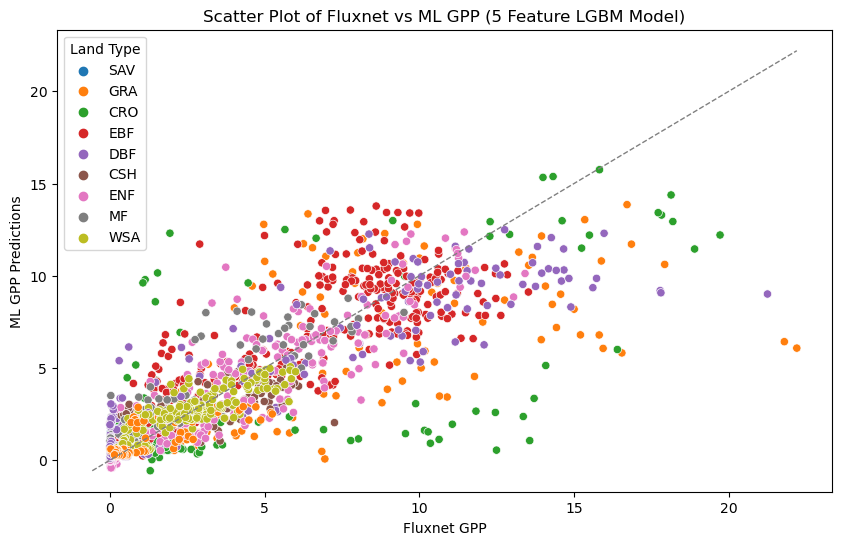

In [215]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=lg5_valid, x='GPP', y='Preds', hue='LandType', palette='tab10')

max_val = max(lg5_valid['GPP'].max(), lg5_valid['Preds'].max())
min_val = min(lg5_valid['GPP'].min(), lg5_valid['Preds'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1)

plt.xlabel('Fluxnet GPP')
plt.ylabel('ML GPP Predictions')
plt.title('Scatter Plot of Fluxnet vs ML GPP (5 Feature LGBM Model)')
plt.legend(title='Land Type')
plt.show()

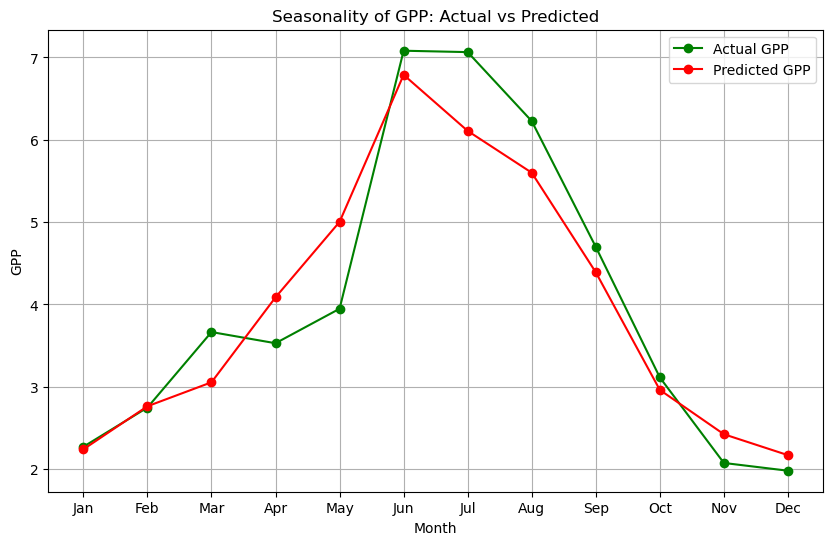

In [216]:
lg5_valid = lg5_valid.merge(valid_y['Date'], left_index=True, right_index=True, how='left')

lg5_valid['Date'] = pd.to_datetime(lg5_valid['Date'])
lg5_valid['Month'] = lg5_valid['Date'].dt.month

monthly_gpp = lg5_valid.groupby('Month').agg({
    'GPP': 'mean',
    'Preds': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_gpp['Month'], monthly_gpp['GPP'], marker='o', label='Actual GPP', color='green')
plt.plot(monthly_gpp['Month'], monthly_gpp['Preds'], marker='o', label='Predicted GPP', color='red')
plt.title('Seasonality of GPP: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('GPP')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

In [217]:
grouped = lg5_valid.groupby('LandType')

metrics = []

for name, group in grouped:
    actuals = group['GPP'].values
    predictions = group['Preds'].values
    
    # Calculate metrics 
    if len(actuals) > 1 and np.var(actuals) > 0:
        r2 = r2_score(actuals, predictions)
    else:
        r2 = np.nan
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mean_bias = np.mean(predictions - actuals)
    
    metrics.append({
        'LandType': name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Bias': mean_bias,
        'Quantity' : len(group)
    })

land_type_metrics = pd.DataFrame(metrics)

In [218]:
r2_metrics = land_type_metrics[land_type_metrics['LandType'] != 'SAV']

overall_r2_std = r2_metrics['R2'].std()

overall_mae_std = land_type_metrics['MAE'].std()

overall_rmse_std = land_type_metrics['RMSE'].std()

overall_bias_std = land_type_metrics['Bias'].std()

overall_metrics = pd.DataFrame({
    'LandType': ['Mean', 'Std Dev'],
    'R2': [r2_lg5, overall_r2_std],
    'MAE': [mae_lg5, overall_mae_std],
    'RMSE': [rmse_lg5, overall_rmse_std],
    'Bias': [mean_bias_lg5, overall_bias_std]
})

final_df = pd.concat([land_type_metrics, overall_metrics], ignore_index=True)
final_df

LandType         R2       MAE      RMSE      Bias  Quantity
0       CRO   0.317143  3.313042  4.731222 -1.471768     110.0
1       CSH   0.367225  1.234528  1.441671  0.095081     120.0
2       DBF   0.797447  1.638931  2.448577 -0.442073     200.0
3       EBF   0.605108  1.642500  2.185974  0.485648     360.0
4       ENF   0.770375  1.112545  1.565076 -0.145299     230.0
5       GRA   0.561237  1.979417  3.232066 -0.998946     223.0
6        MF   0.649633  1.216621  1.584218  1.001503      85.0
7       SAV -17.567316  1.047476  1.088802  1.047476      82.0
8       WSA   0.789182  0.541423  0.711106  0.035052     233.0
9      Mean   0.670068  1.487777  2.334258 -0.085856       NaN
10  Std Dev   0.185771  0.788624  1.238449  0.844814       NaN

6 Column

In [219]:
x_lg6 = valid_x[['LAI_HighVeg', 'DewTemp2m', 'Albedo', 'VPD', 'U10_Wind', 'VolSoilWaterL3']]
y = valid_x['GPP_DT_VUT_REF']

In [220]:
xlg6_train, xlg6_test, ylg6_train, ylg6_test = train_test_split(x_lg6, y, test_size=0.2, random_state=31)

In [221]:
LGBM = lgb.LGBMRegressor(verbose=-1)

params = {
    'n_estimators': [50, 100, 150, 200, 250, 300],  
    'max_depth': [-1, 5, 10, 15, 20],  
    'num_leaves': list(np.arange(10, 100, 10)),  
    'min_child_samples': list(np.arange(5, 50, 5)),  
    'learning_rate': np.linspace(0.01, 0.2, 10), 
    'subsample': np.linspace(0.6, 1.0, 5),  
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  
    'boosting_type': ['gbdt', 'dart'],  
    'reg_alpha': [0, 0.01, 0.1, 0.5],  
    'reg_lambda': [0, 0.01, 0.1, 0.5]
}

random_search = RandomizedSearchCV(
    estimator=LGBM,
    param_distributions=params,
    n_iter=40,  
    scoring='neg_mean_squared_error',  
    cv=5, 
    verbose=0,
    random_state=31,
    n_jobs=-1 
)

random_search.fit(xlg6_train, ylg6_train)

best_params = random_search.best_params_
best_params

{'subsample': 0.8,
 'reg_lambda': 0.5,
 'reg_alpha': 0.5,
 'num_leaves': 80,
 'n_estimators': 200,
 'min_child_samples': 5,
 'max_depth': 10,
 'learning_rate': 0.1577777777777778,
 'colsample_bytree': 0.7,
 'boosting_type': 'gbdt'}

In [222]:
lg6 = lgb.LGBMRegressor(
    subsample = best_params['subsample'],
    reg_lambda = best_params['reg_lambda'],
    reg_alpha = best_params['reg_alpha'],
    num_leaves = best_params['num_leaves'],
    n_estimators = best_params['n_estimators'],
    min_child_samples = best_params['min_child_samples'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    colsample_bytree = best_params['colsample_bytree'],
    boosting_type = best_params['boosting_type'],
    random_state = 31
)

kf = KFold(n_splits=10, shuffle=True, random_state=31)

rmse_list = []
mae_list = []
r2_list = []
mean_bias_list = []

for fold, (train_index, test_index) in enumerate(kf.split(xlg6_train), 1): 
    fold_start = time.time() 
    
    x_train, x_test = xlg6_train.iloc[train_index], xlg6_train.iloc[test_index]
    y_train, y_test = ylg6_train.iloc[train_index], ylg6_train.iloc[test_index]
    
    lg6.fit(x_train, y_train)
    
    y_pred = lg6.predict(x_test)

    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    mean_bias = round(np.mean(y_pred - y_test), 4)
    
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mean_bias_list.append(mean_bias)
    
    fold_end = time.time()  
    fold_time = round(fold_end - fold_start, 2)  # Calculate time taken per fold
    print(f"Fold {fold} complete. Time taken = {fold_time} seconds")

Fold 1 complete. Time taken = 1.9 seconds
Fold 2 complete. Time taken = 2.35 seconds
Fold 3 complete. Time taken = 1.89 seconds
Fold 4 complete. Time taken = 1.85 seconds
Fold 5 complete. Time taken = 1.81 seconds
Fold 6 complete. Time taken = 1.89 seconds
Fold 7 complete. Time taken = 2.0 seconds
Fold 8 complete. Time taken = 2.05 seconds
Fold 9 complete. Time taken = 1.97 seconds
Fold 10 complete. Time taken = 2.25 seconds


In [223]:
rmse_avg = round(np.mean(rmse_list),4)
rmse_std = round(np.std(rmse_list),4)
mae_avg = round(np.mean(mae_list),4)
mae_std = round(np.std(mae_list),4)
r2_avg = round(np.mean(r2_list),4)
r2_std = round(np.std(r2_list),4)
mean_bias_avg = round(np.mean(mean_bias_list),4)
mean_bias_std = round(np.std(mean_bias_list),4)

metrics_lg6 = pd.DataFrame({
    'RMSE': rmse_list + [rmse_avg, rmse_std],
    'MAE': mae_list + [mae_avg, mae_std],
    'R²': r2_list + [r2_avg, r2_std],
    'Mean Bias': mean_bias_list + [mean_bias_avg, mean_bias_std]
})

metrics_lg6.index = [f'Fold {i+1}' for i in range(10)] + ['Mean', 'Std']
metrics_lg6

RMSE     MAE      R²  Mean Bias
Fold 1   1.3002  0.8869  0.8676     0.0557
Fold 2   1.6769  1.0221  0.8243    -0.2535
Fold 3   1.5054  0.9440  0.8140     0.0950
Fold 4   1.6736  1.0808  0.8201     0.0369
Fold 5   1.5208  0.9368  0.8052     0.1506
Fold 6   1.5015  0.9992  0.8426     0.0330
Fold 7   1.5507  0.9622  0.8311    -0.0531
Fold 8   1.7353  1.0826  0.8229     0.0133
Fold 9   1.5645  0.9937  0.8355    -0.0197
Fold 10  1.5640  0.9940  0.8412    -0.0582
Mean     1.5593  0.9902  0.8305     0.0000
Std      0.1153  0.0586  0.0167     0.1041

In [224]:
lg6.fit(x_lg6,y)

lg6_valid = valid_y[['LAI_HighVeg', 'DewTemp2m', 'Albedo', 'VPD', 'U10_Wind', 'VolSoilWaterL3']]
y_valid = valid_y['GPP_DT_VUT_REF']

lg6_preds = lg6.predict(lg6_valid)

In [225]:
# Calculate metrics
rmse_lg6 = np.sqrt(mean_squared_error(y_valid, lg6_preds))
mae_lg6 = mean_absolute_error(y_valid, lg6_preds)
r2_lg6 = r2_score(y_valid, lg6_preds)

# Calculate mean bias
mean_bias_lg6 = np.mean(lg6_preds - y_valid)

# Print the evaluation metrics
print('Results for Best 6 Feature LGBM Model:')
print(f'RMSE: {round(rmse_lg6,4)}')
print(f'MAE: {round(mae_lg6,4)}')
print(f'R²: {round(r2_lg6,4)}')
print(f'Mean Bias: {round(mean_bias_lg6,4)}')

Results for Best 6 Feature RF Model:
RMSE: 2.518
MAE: 1.6651
R²: 0.6161
Mean Bias: -0.0463


C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\148632077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lg6_valid['GPP'] = y_valid
C:\Users\joearthur\AppData\Local\Temp\ipykernel_31512\148632077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lg6_valid['Preds'] = lg6_preds


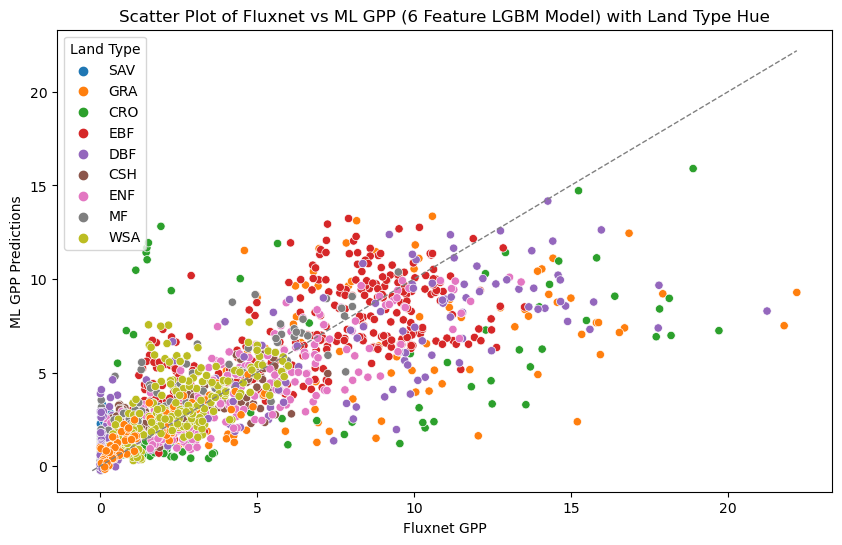

In [226]:
lg6_valid['GPP'] = y_valid
lg6_valid['Preds'] = lg6_preds

lg6_valid = lg6_valid.merge(valid_y[['LandType','Site']], left_index=True, right_index=True, how='left')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lg6_valid, x='GPP', y='Preds', hue='LandType', palette='tab10')

max_val = max(lg6_valid['GPP'].max(), lg6_valid['Preds'].max())
min_val = min(lg6_valid['GPP'].min(), lg6_valid['Preds'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1)

plt.xlabel('Fluxnet GPP')
plt.ylabel('ML GPP Predictions')
plt.title('Scatter Plot of Fluxnet vs ML GPP (6 Feature LGBM Model) with Land Type Hue')
plt.legend(title='Land Type')
plt.show()

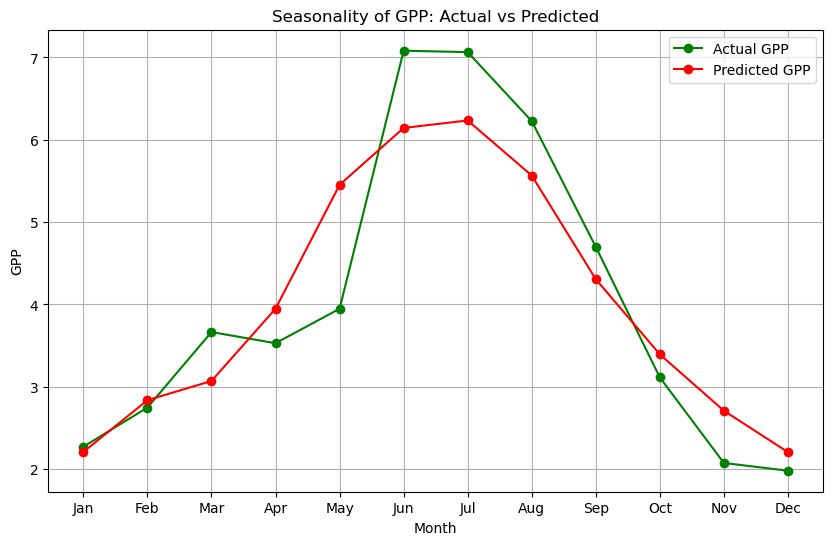

In [227]:
lg6_valid = lg6_valid.merge(valid_y['Date'], left_index=True, right_index=True, how='left')

lg6_valid['Date'] = pd.to_datetime(lg6_valid['Date'])
lg6_valid['Month'] = lg6_valid['Date'].dt.month

monthly_gpp = lg6_valid.groupby('Month').agg({
    'GPP': 'mean',
    'Preds': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_gpp['Month'], monthly_gpp['GPP'], marker='o', label='Actual GPP', color='green')
plt.plot(monthly_gpp['Month'], monthly_gpp['Preds'], marker='o', label='Predicted GPP', color='red')
plt.title('Seasonality of GPP: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('GPP')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

In [228]:
grouped = lg6_valid.groupby('LandType')

metrics = []

for name, group in grouped:
    actuals = group['GPP'].values
    predictions = group['Preds'].values
    
    # Calculate metrics 
    if len(actuals) > 1 and np.var(actuals) > 0:
        r2 = r2_score(actuals, predictions)
    else:
        r2 = np.nan
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mean_bias = np.mean(predictions - actuals)
    
    metrics.append({
        'LandType': name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Bias': mean_bias,
        'Quantity' : len(group)
    })

land_type_metrics = pd.DataFrame(metrics)

In [229]:
r2_metrics = land_type_metrics[land_type_metrics['LandType'] != 'SAV']

overall_r2_std = r2_metrics['R2'].std()

overall_mae_std = land_type_metrics['MAE'].std()

overall_rmse_std = land_type_metrics['RMSE'].std()

overall_bias_std = land_type_metrics['Bias'].std()

overall_metrics = pd.DataFrame({
    'LandType': ['Mean', 'Std Dev'],
    'R2': [r2_lg6, overall_r2_std],
    'MAE': [mae_lg6, overall_mae_std],
    'RMSE': [rmse_lg6, overall_rmse_std],
    'Bias': [mean_bias_lg6, overall_bias_std]
})

final_df = pd.concat([land_type_metrics, overall_metrics], ignore_index=True)
final_df

LandType         R2       MAE      RMSE      Bias  Quantity
0       CRO   0.245736  3.518543  4.972449 -1.428423     110.0
1       CSH   0.419922  1.142273  1.380335  0.532301     120.0
2       DBF   0.705530  2.045689  2.952334 -0.774162     200.0
3       EBF   0.581979  1.751599  2.249081  0.367866     360.0
4       ENF   0.774338  1.184054  1.551514 -0.394819     230.0
5       GRA   0.541771  1.979520  3.302985 -1.055437     223.0
6        MF   0.585673  1.336530  1.722761  1.178113      85.0
7       SAV -36.510393  1.381185  1.547569  1.366111      82.0
8       WSA   0.160128  0.992825  1.419341  0.659413     233.0
9      Mean   0.616078  1.665114  2.518012 -0.046268       NaN
10  Std Dev   0.213761  0.776079  1.206203  0.999666       NaN

Feature analysis

On best performer

RF6

Feature Importances:
          Feature  Importance
1            Evap    0.261524
0     LAI_HighVeg    0.210540
5  VolSoilWaterL4    0.170882
2       DewTemp2m    0.145444
3          Albedo    0.127169
4       Elevation    0.084441


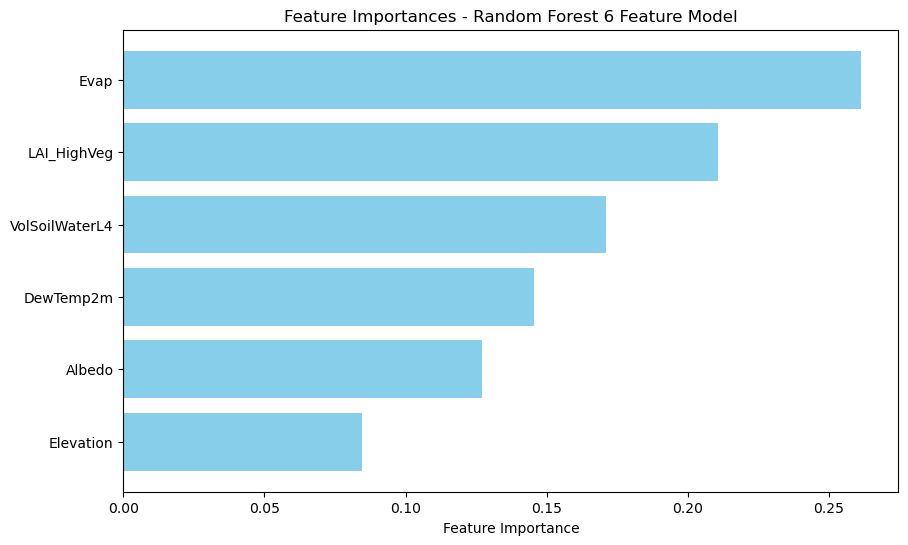

In [130]:
importances = rf6.feature_importances_

importance_df = pd.DataFrame({
    'Feature': xrf6_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Feature Importances - Random Forest 6 Feature Model')
plt.show()

SHAP

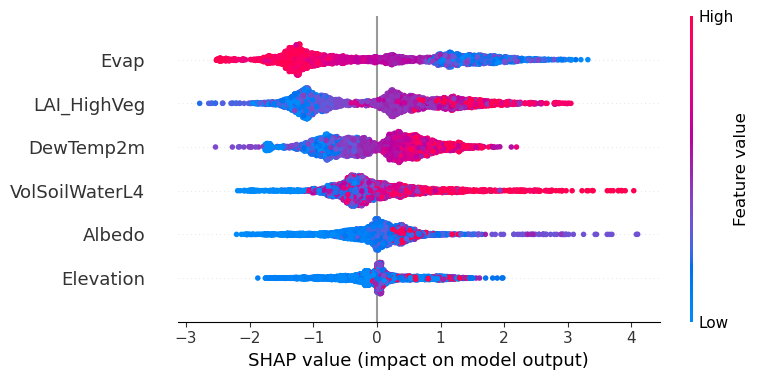

In [132]:
explainer = shap.TreeExplainer(rf6)

shap_values = explainer.shap_values(x_rf6)

shap.summary_plot(shap_values, x_rf6)

In [238]:
shap.force_plot(explainer.expected_value, shap_values[0], x_rf6.iloc[0])

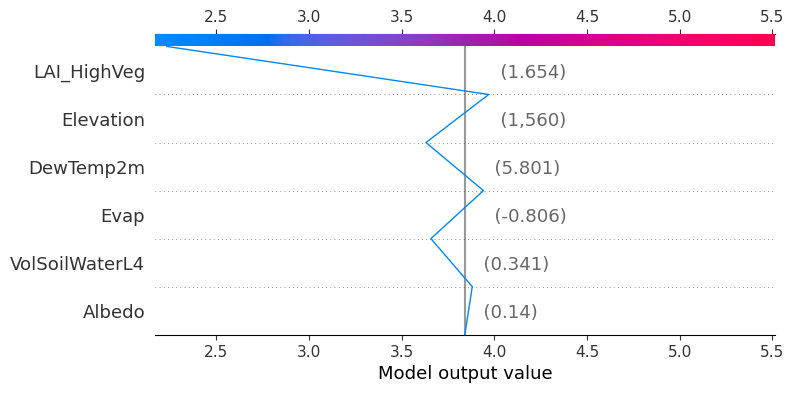

In [52]:
shap.decision_plot(explainer.expected_value, shap_values[1500], x_rf6.iloc[1500])

In [53]:
valid_x.iloc[100]

Date              2013-10-18 00:00:00
Site                           IT_COL
LandType                          DBF
GPP_DT_VUT_REF                1.89006
Latitude                      41.8494
Longitude                     13.5881
U10_Wind                    -0.105595
DewTemp2m                    5.800676
Evap                        -0.806427
EvapVegTrans                      0.0
Albedo                       0.140099
LAI_HighVeg                  1.654419
LAI_LowVeg                   2.577271
SoilTempL3                    13.7592
VolSoilWaterL3               0.272888
VolSoilWaterL4                0.34107
Elevation                      1560.0
VPD                          5.357455
Name: 2172, dtype: object

In [56]:
mean_values = x_rf6[['Evap', 'LAI_HighVeg', 'VolSoilWaterL4', 'Elevation', 'Albedo', 'DewTemp2m']].mean()
print(mean_values)

Evap               -0.829977
LAI_HighVeg         2.442200
VolSoilWaterL4      0.274635
Elevation         609.168600
Albedo              0.169475
DewTemp2m           6.654144
dtype: float64


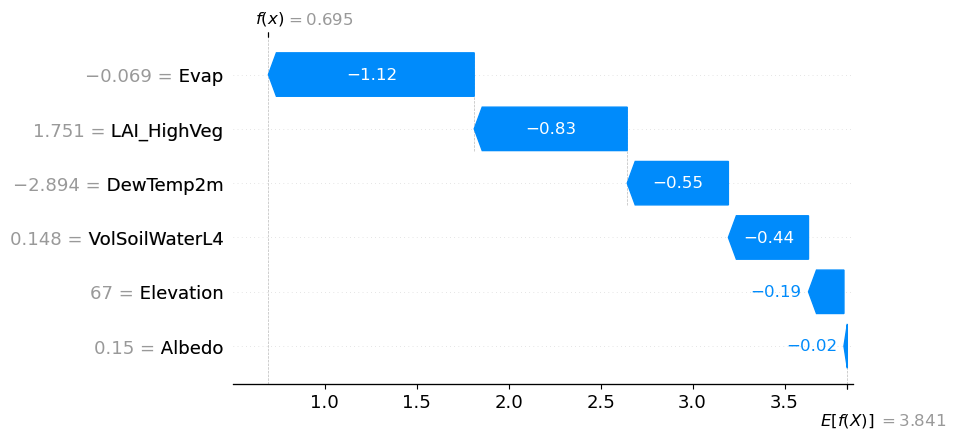

In [135]:
shap.waterfall_plot(shap.Explanation(values=shap_values[100], base_values=explainer.expected_value, data=x_rf6.iloc[100]))

In [266]:
valid_x.iloc[280]

Date              2012-05-11 00:00:00
Site                           CH_CHA
LandType                          GRA
GPP_DT_VUT_REF                2.72456
Latitude                      47.2102
Longitude                      8.4104
U10_Wind                     0.172997
DewTemp2m                   11.709178
Evap                        -2.139834
EvapVegTrans                 0.002398
Albedo                       0.167062
LAI_HighVeg                  2.826538
LAI_LowVeg                   3.267792
SoilTempL3                   9.766415
VolSoilWaterL3               0.357473
VolSoilWaterL4               0.400409
Elevation                       393.0
VPD                          7.760695
Name: 362, dtype: object

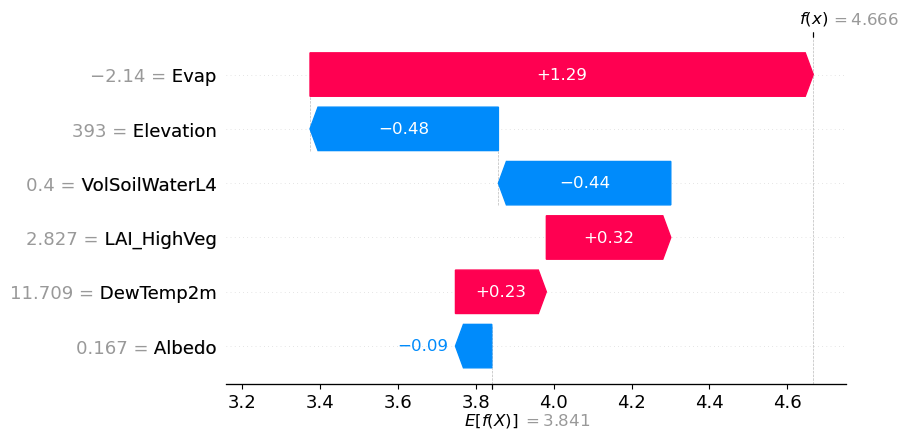

In [262]:
shap.waterfall_plot(shap.Explanation(values=shap_values[280], base_values=explainer.expected_value, data=x_rf6.iloc[280]))

In [67]:
x_rf6_lt = x_rf6.merge(valid_x[['LandType','Site']], left_index=True, right_index=True, how='left')

# Ensures SHAP only used the columns used for modelling, not LandType
num_cols = x_rf6.columns

monthly_shap_values = x_rf6_lt.groupby('LandType').apply(
    lambda x: explainer.shap_values(x[num_cols]).mean(axis=0)
)

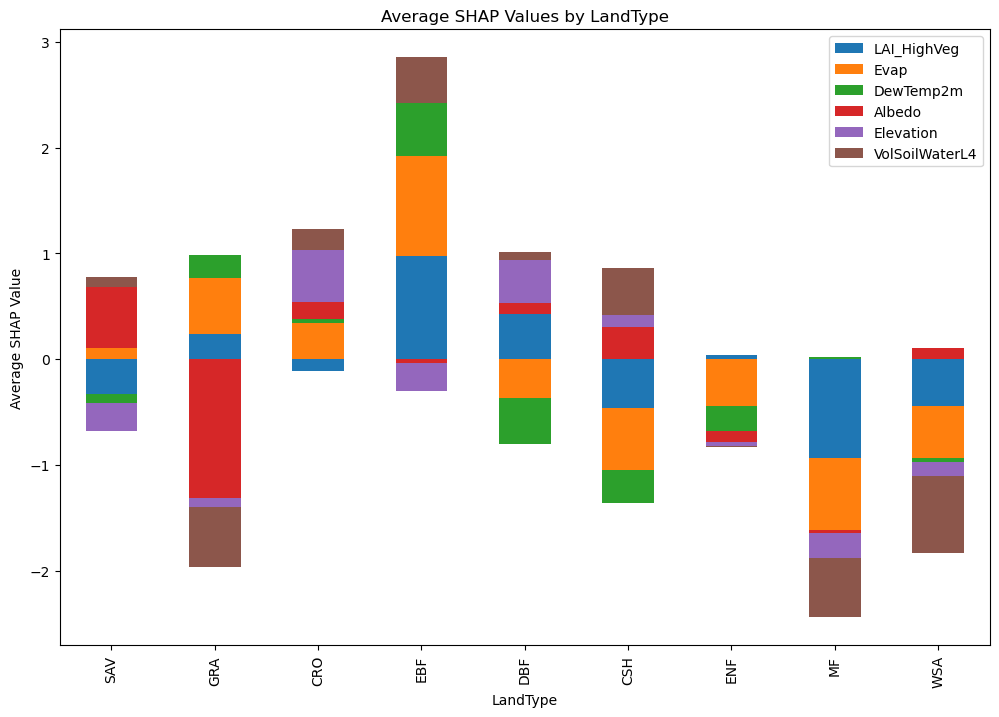

In [65]:
monthly_shap_df = pd.DataFrame(list(monthly_shap_values), index=x_rf6_lt['LandType'].unique(), columns=x_rf6.columns)

# Plotting
monthly_shap_df.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("Average SHAP Values by LandType")
plt.ylabel("Average SHAP Value")
plt.xlabel("LandType")
plt.show()